## Comp2-1 量表类型数据

主要适配于临床数据的建模和刻画。典型的应用场景探究rad_score最终临床诊断的作用。

## Onekey步骤

1. 数据校验，检查数据格式是否正确。
3. 查看一些统计信息，检查数据时候存在异常点。
4. 正则化，将数据变化到服从 N~(0, 1)。
5. 通过相关系数，例如spearman、person等筛选出特征。
6. 构建训练集和测试集，这里使用的是随机划分，正常多中心验证，需要大家根据自己的场景构建两份数据。
7. 通过Lasso筛选特征，选取其中的非0项作为后续模型的特征。
8. 使用机器学习算法，例如LR、SVM、RF等进行任务学习。
9. 模型结果可视化，例如AUC、ROC曲线，混淆矩阵等。


# 筛选临床特征

需要根据自己的情况，筛选特征，一般情况筛选pvalue<0.05的。

In [1]:
import pandas as pd
import numpy as np
from collections import namedtuple
from onekey_algo import OnekeyDS as okds
from onekey_algo import get_param_in_cwd
import onekey_algo.custom.components as okcomp
from onekey_algo.custom.components.comp1 import fillna
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 300

## 一、数据校验
首先需要检查诊断数据，如果显示`检查通过！`择可以正常运行之后的，否则请根据提示调整数据。

数据文件中的数据都是数值类型，或者可以映射成数值类型，这里的`label`某些情况下可能是非数值的，需要自定义数值函数。

**注意：在使用树模型时，可以存在缺失，但是线性模型不允许缺失，请自行根据需要填充缺省值**

In [2]:
# 读取数据，B超诊断阳性=1，bc_data.csv是要读取的数据。
task_type = 'Clinic'
data_file = r'data/clinic_sel.csv'
labels = ['label']
featrues_not_use = ['ID']

structed_data = pd.read_csv(data_file, header=0)
structed_data

ID  H_W  Size  group  label
0       1.nii.gz    0  0.74  train      0
1       2.nii.gz    1  0.58    val      0
2       3.nii.gz    1  0.65    val      0
3       4.nii.gz    1  0.68  train      1
4       5.nii.gz    1  0.76    val      1
..           ...  ...   ...    ...    ...
755  1411.nii.gz    1  0.60   test      0
756  1412.nii.gz    1  2.10   test      1
757  1413.nii.gz    1  0.60   test      0
758  1414.nii.gz    0  1.70   test      0
759  1415.nii.gz    0  2.70   test      1

[760 rows x 5 columns]

### 特征维度

In [3]:
# 删掉ID这一列。
ids = structed_data['ID']
structed_data = structed_data.drop(featrues_not_use, axis=1)
structed_data

H_W  Size  group  label
0      0  0.74  train      0
1      1  0.58    val      0
2      1  0.65    val      0
3      1  0.68  train      1
4      1  0.76    val      1
..   ...   ...    ...    ...
755    1  0.60   test      0
756    1  2.10   test      1
757    1  0.60   test      0
758    0  1.70   test      0
759    0  2.70   test      1

[760 rows x 4 columns]

## 二、数据统计

1. count，统计样本个数。
2. mean、std, 对应特征的均值、方差
3. min, 25%, 50%, 75%, max，对应特征的最小值，25,50,75分位数，最大值。

In [4]:
structed_data.describe()

H_W     Size    label
count  760.000  760.000  760.000
mean     0.595    1.165    0.508
std      0.491    0.830    0.500
min      0.000    0.260    0.000
25%      0.000    0.640    0.000
50%      1.000    0.900    1.000
75%      1.000    1.400    1.000
max      1.000    6.300    1.000

## 三、正则化

临床特征可选是否正则化，默认不进行

`normalize_df` 为onekey中正则化的API，将数据变化到0均值1方差。正则化的方法为

$column = \frac{column - mean}{std}$

In [5]:
# from onekey_algo.custom.components.comp1 import normalize_df
# data = normalize_df(structed_data, not_norm=labels + ['group'])
# data = data.dropna(axis=1)
# data.describe()
data = structed_data
data

H_W  Size  group  label
0      0  0.74  train      0
1      1  0.58    val      0
2      1  0.65    val      0
3      1  0.68  train      1
4      1  0.76    val      1
..   ...   ...    ...    ...
755    1  0.60   test      0
756    1  2.10   test      1
757    1  0.60   test      0
758    0  1.70   test      0
759    0  2.70   test      1

[760 rows x 4 columns]

## 四、相关系数

计算相关系数的方法有3种可供选择
1. pearson （皮尔逊相关系数）: standard correlation coefficient

2. kendall (肯德尔相关性系数) : Kendall Tau correlation coefficient

3. spearman (斯皮尔曼相关性系数): Spearman rank correlation

三种相关系数参考：https://blog.csdn.net/zmqsdu9001/article/details/82840332

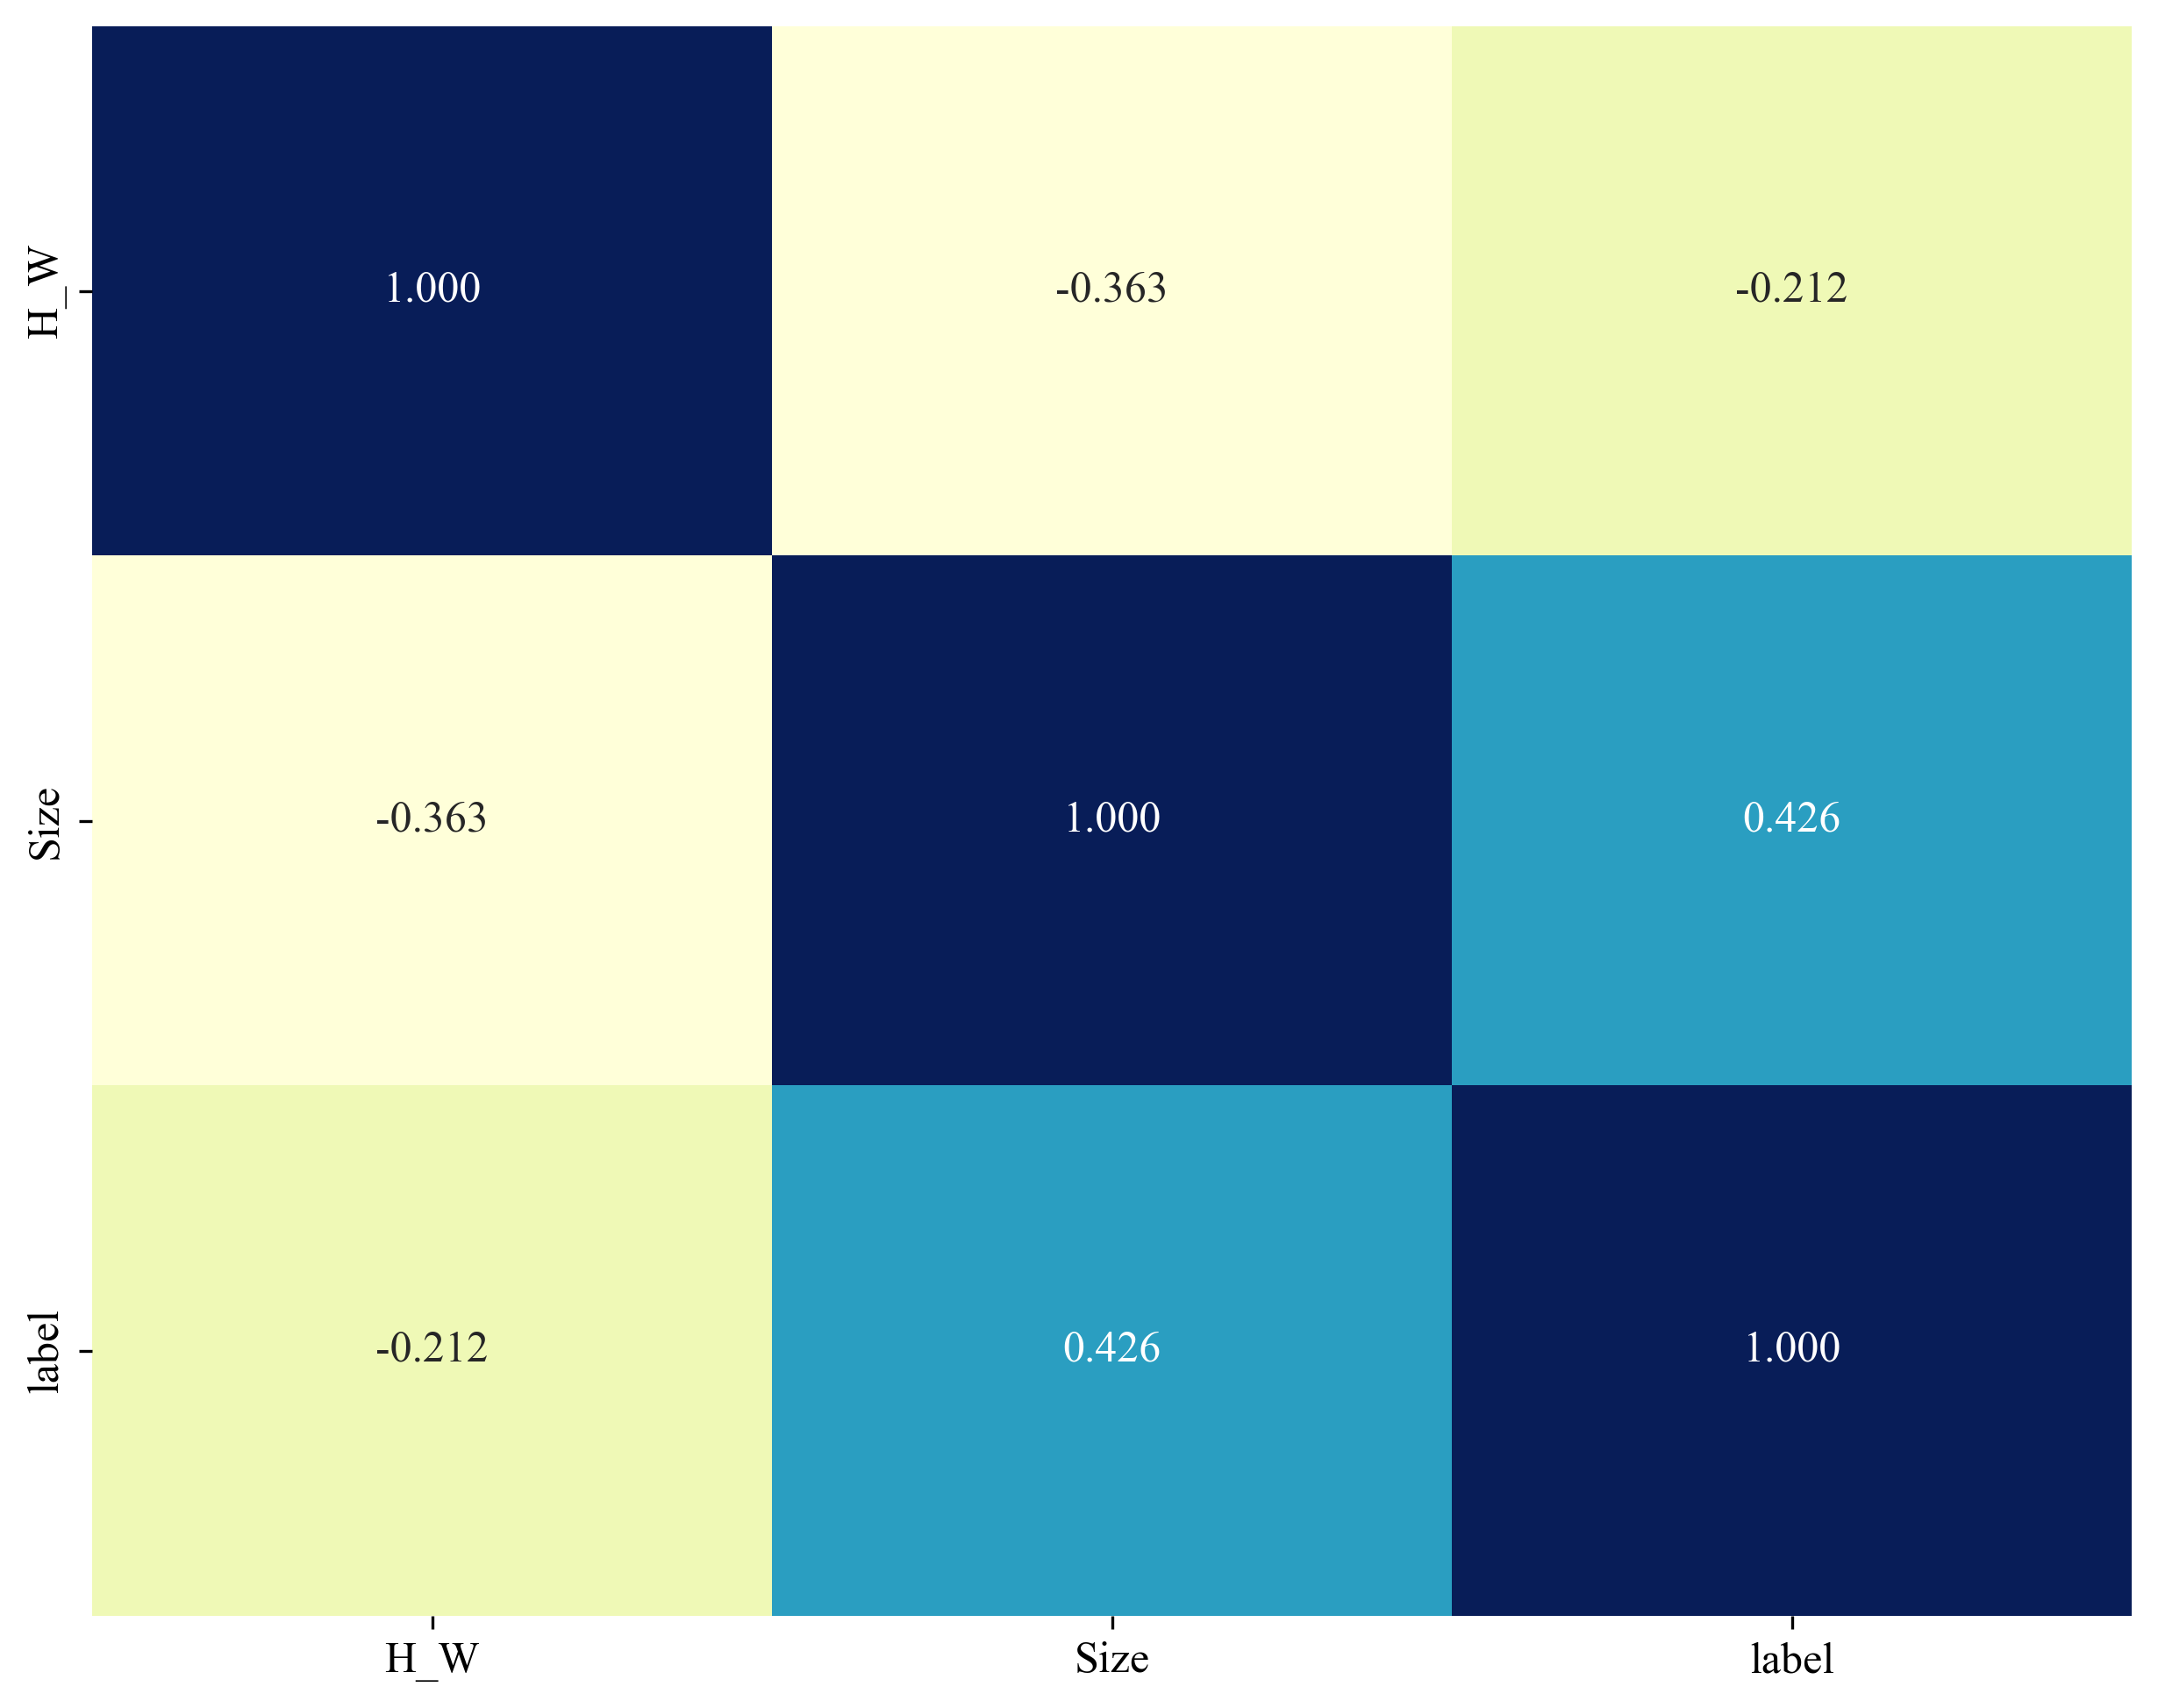

In [6]:
# 如果需要选择相关系数使用对应的相关系数即可。
# pearson_corr = data.corr('pearson')
# kendall_corr = data.corr('kendall')
spearman_corr = data[[c for c in data.columns if c !='IM']].corr('spearman')

import seaborn as sns
import matplotlib.pyplot as plt
from onekey_algo.custom.components.comp1 import draw_matrix
plt.figure(figsize=(10.0, 8.0))

# 选择可视化的相关系数
draw_matrix(spearman_corr, annot=True, cmap='YlGnBu', cbar=False)
plt.savefig(f'img/Clinic_feature_corr.svg', bbox_inches = 'tight')

## 五、构建数据

将样本的训练数据X与监督信息y分离出来，并且对训练数据进行划分，一般的划分原则为80%-20%

In [7]:
import numpy as np
import onekey_algo.custom.components as okcomp

n_classes = 2
train_data = data[(data['group'] == 'train')]
train_ids = ids.loc[list(train_data.index)]
train_data = train_data.reset_index()
train_data = train_data.drop('index', axis=1)
y_data = train_data[labels]
X_data = train_data.drop(labels + ['group'], axis=1)

test_data = data[data['group'] != 'train']
test_ids = ids.loc[list(test_data.index)]
test_data = test_data.reset_index()
test_data = test_data.drop('index', axis=1)
y_test_data = test_data[labels]
X_test_data = test_data.drop(labels + ['group'], axis=1)

y_all_data = data[labels]
X_all_data = data.drop(labels + ['group'], axis=1)

column_names = X_data.columns
print(f"训练集样本数：{X_data.shape}, 验证集样本数：{X_test_data.shape}")

训练集样本数：(442, 2), 验证集样本数：(318, 2)


## 六、模型筛选

根据筛选出来的数据，做模型的初步选择。当前主要使用到的是Onekey中的

1. SVM，支持向量机，引用参考。
2. KNN，K紧邻，引用参考。
3. Decision Tree，决策树，引用参考。
4. Random Forests, 随机森林，引用参考。
5. XGBoost, bosting方法。引用参考。
6. LightGBM, bosting方法，引用参考。

In [8]:
model_names = get_param_in_cwd('ml_models')
models = okcomp.comp1.create_clf_model(model_names)
model_names = list(models.keys())

### 交叉验证

`n_trails`指定随机次数，每次采用的是80%训练，随机20%进行测试，找到最好的模型，以及对应的最好的数据划分。

这里的数据并没有使用前面`Lasso`筛选出来的特征进行训练，理论来说，特征筛选仅对线性模型有一定作用，例如`SVM`、`LR`，但是对树模型没什么作用，例如`DecisionTree`、`Random`这些。所以默认不筛选。

```python
def get_bst_split(X_data: pd.DataFrame, y_data: pd.DataFrame,
            models: dict, test_size=0.2, metric_fn=accuracy_score, n_trails=10,
            cv: bool = False, shuffle: bool = False, metric_cut_off: float = None, random_state=None):
    """
    寻找数据集中最好的数据划分。
    Args:
        X_data: 训练数据
        y_data: 监督数据
        models: 模型名称，Dict类型、
        test_size: 测试集比例
        metric_fn: 评价模型好坏的函数，默认准确率，可选roc_auc_score。
        n_trails: 尝试多少次寻找最佳数据集划分。
        cv: 是否是交叉验证，默认是False，当为True时，n_trails为交叉验证的n_fold
        shuffle: 是否进行随机打乱
        metric_cut_off: 当metric_fn的值达到多少时进行截断。
        random_state: 随机种子

    Returns: {'max_idx': max_idx, "max_model": max_model, "max_metric": max_metric, "results": results}

    """
```

**注意：这里采用了【挑数据】，如果想要严谨，请修改`n_trails=1`。**

[2025-12-08 11:24:14 - <frozen onekey_algo.custom.components.comp1>: 662]	WARNING	当cv=True的时候，采用的是交叉验证的模式，此时test_size的参数是不生效的，我们将忽略这个test_size设置。如果需要手动指定测试集比例，请修改cv=False。


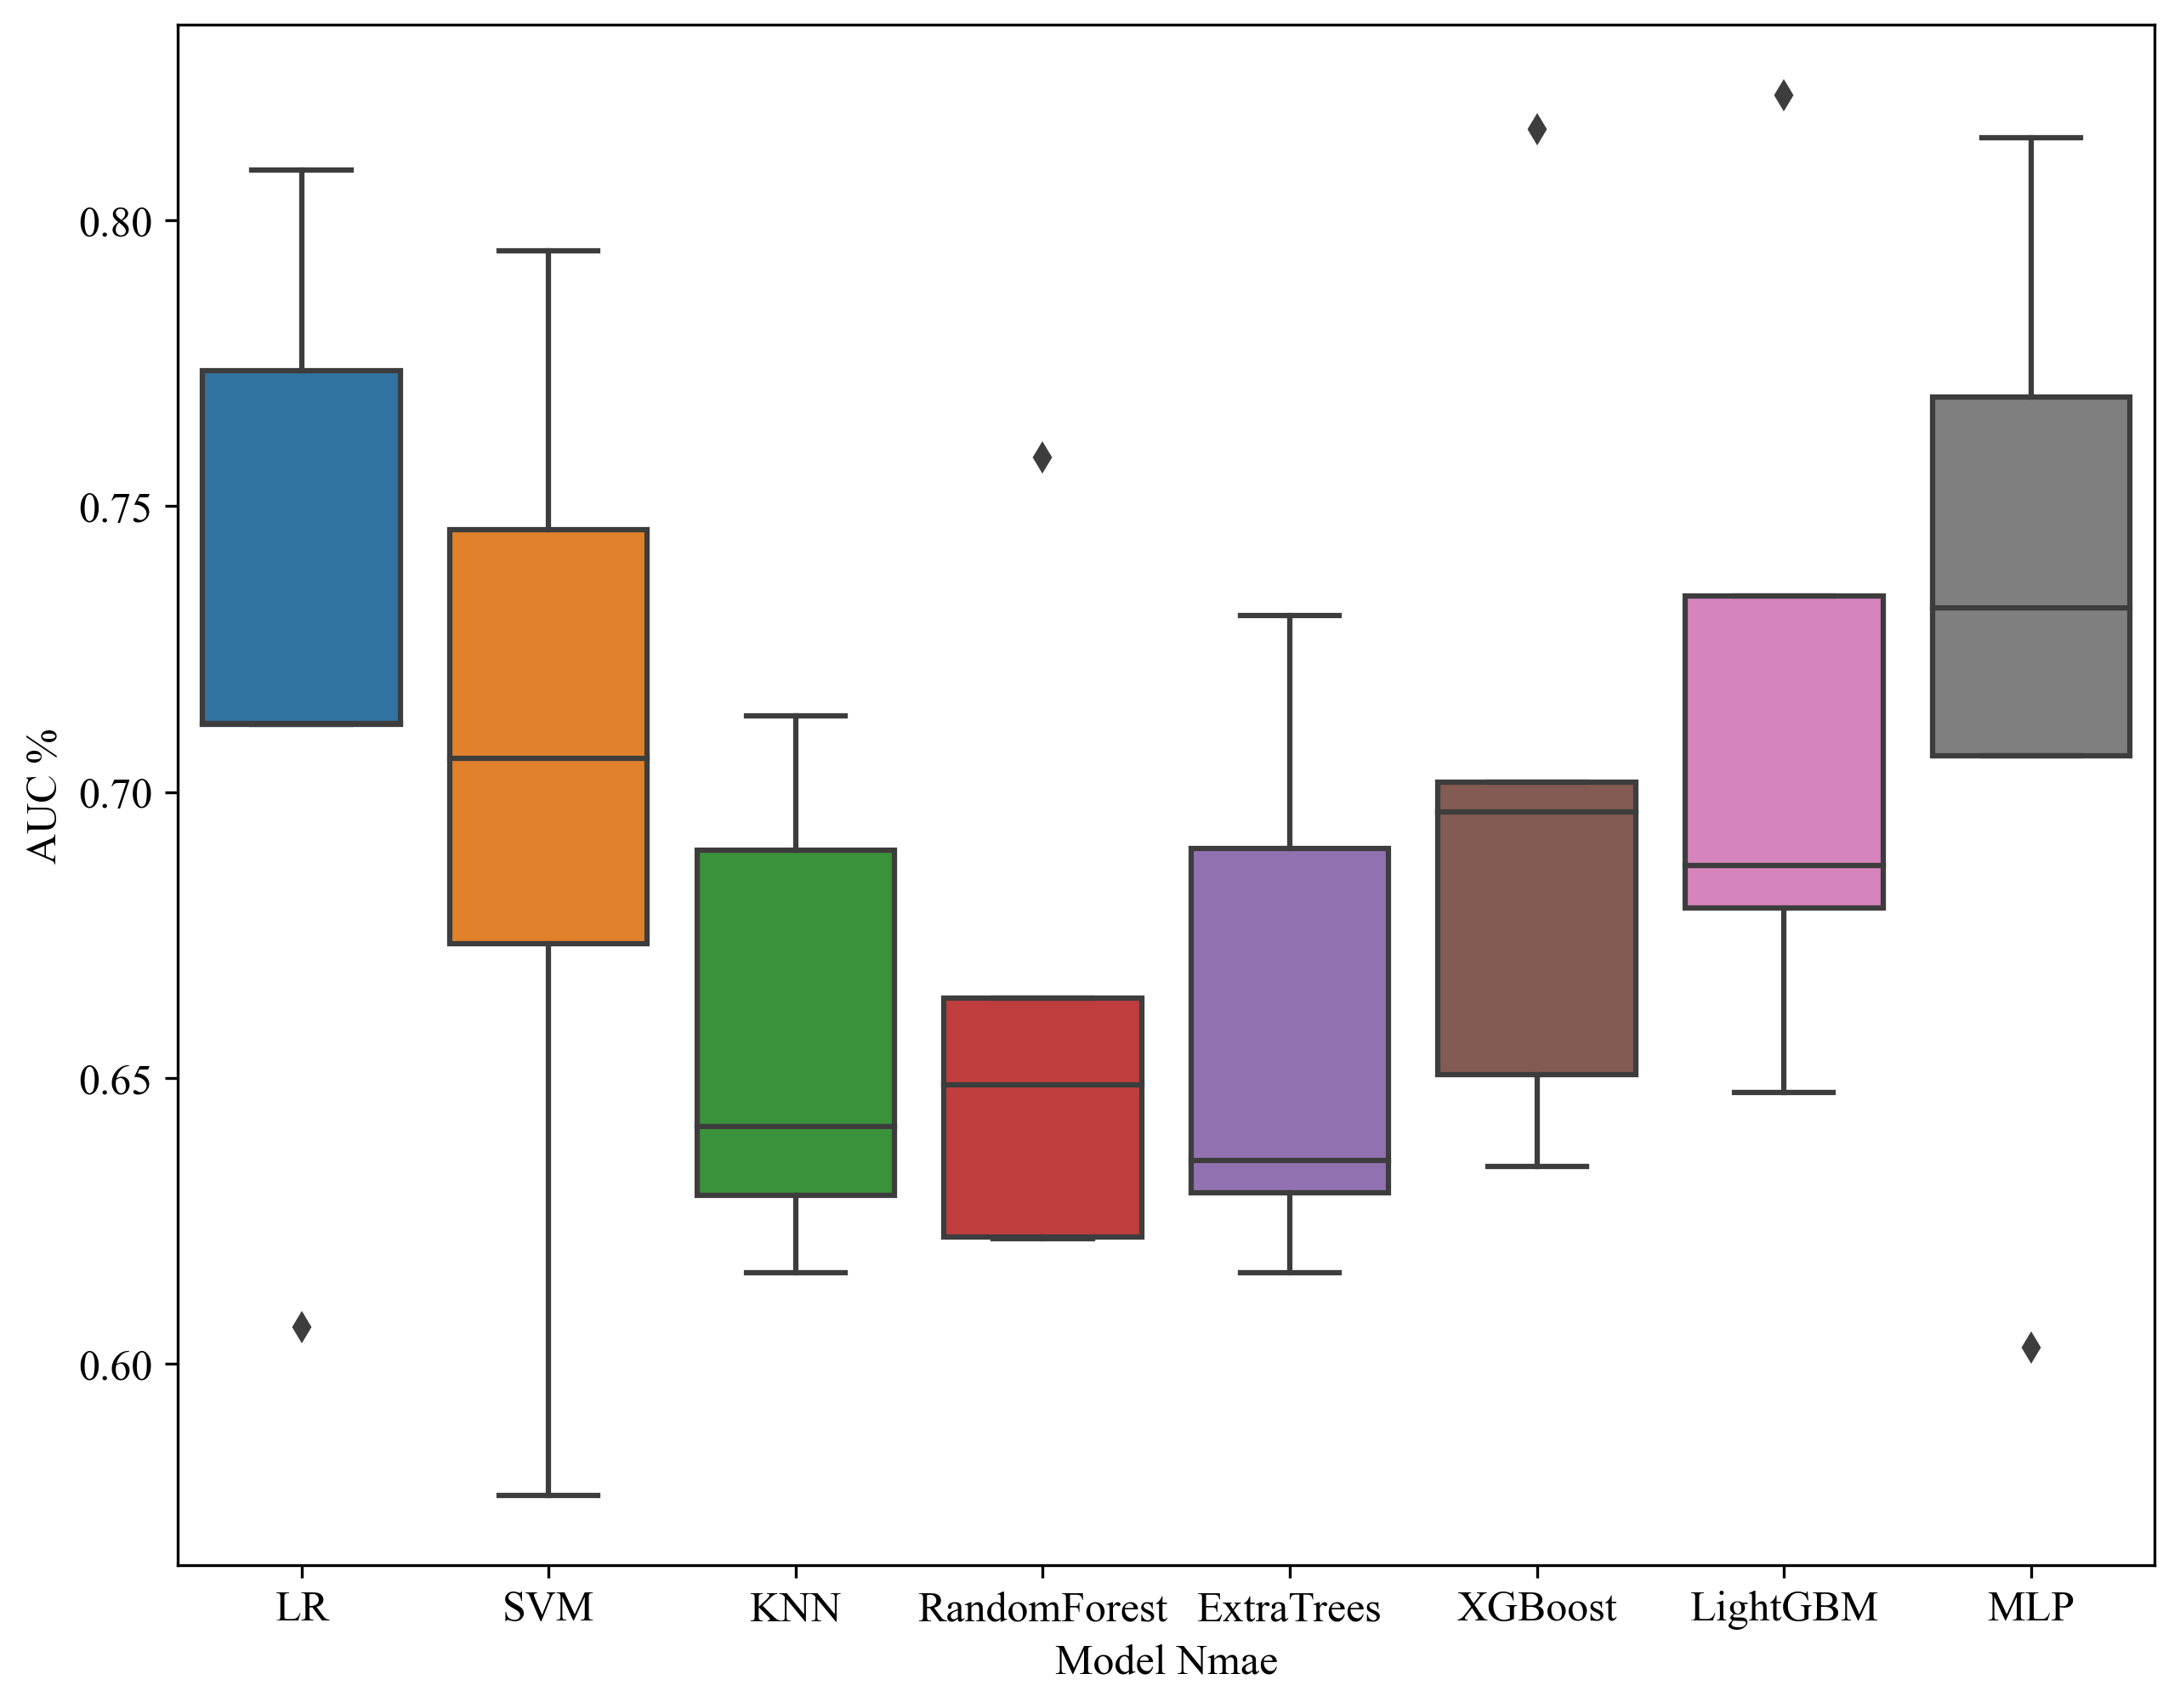

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score

# 随机使用n_trails次数据划分，找到最好的一次划分方法，并且保存在results中。
results = okcomp.comp1.get_bst_split(X_data, y_data, models, test_size=0.2, metric_fn=roc_auc_score, n_trails=5, cv=True, random_state=0)
_, (X_train_sel, X_test_sel, y_train_sel, y_test_sel) = results['results'][results['max_idx']]
X_train_sel, X_test_sel, y_train_sel, y_test_sel = X_data, X_test_data, y_data, y_test_data
trails, _ = zip(*results['results'])
cv_results = pd.DataFrame(trails, columns=model_names)
# 可视化每个模型在不同的数据划分中的效果。
sns.boxplot(data=cv_results)
plt.ylabel('AUC %')
plt.xlabel('Model Nmae')
plt.savefig(f'img/Clinic_model_cv.svg', bbox_inches = 'tight')

### 模型筛选

使用最好的数据划分，进行后续的模型研究。

**注意**: 一般情况下论文使用的是随机划分的数据，但也有些论文使用【刻意】筛选的数据划分。

In [239]:
import joblib
import os
from onekey_algo.custom.components.comp1 import plot_feature_importance, plot_learning_curve, smote_resample

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

targets = []
os.makedirs('models', exist_ok=True)
for l in labels:
    new_models = okcomp.comp1.create_clf_model_none_overfit(model_names)
    new_models['LR'] = LogisticRegression(penalty='none', max_iter=100)
    new_models['SVM'] = SVC(probability=True, max_iter=100, kernel='linear')
    new_models['RandomForest'] = RandomForestClassifier(n_estimators=5, max_depth=3,
                                                        min_samples_split=4, random_state=0)
    new_models['XGBoost'] = XGBClassifier(n_estimators=6, objective='binary:logistic', max_depth=4, min_child_weight=.2,
                                              use_label_encoder=False, eval_metric='error')
    new_models['LightGBM'] = LGBMClassifier(n_estimators=2,  max_depth=1, min_child_weight=0.5,)
    new_models['ExtraTrees'] = ExtraTreesClassifier(n_estimators=61, max_depth=7, min_samples_split=6, random_state=0)
    new_models['GradientBoosting'] = GradientBoostingClassifier(n_estimators=10, random_state=0)
    new_models['AdaBoost'] = AdaBoostClassifier(n_estimators=10, random_state=0)
    new_models['MLP'] = MLPClassifier(hidden_layer_sizes=(100, 100, 32, 16), max_iter=300, solver='sgd', random_state=0)
    model_names = list(new_models.keys())
    new_models = list(new_models.values())
    
    for mn, m in zip(model_names, new_models):
        X_train_smote, y_train_smote = X_train_sel, y_train_sel
        # 取消下一行的注释可以使用Smote进行采样，解决样本不均衡的问题。
        if get_param_in_cwd('use_smote', False):
            X_train_smote, y_train_smote = smote_resample(X_train_sel, y_train_sel)
        m.fit(X_train_smote, y_train_smote[l])
        # 保存训练的模型
        joblib.dump(m, f'models/{task_type}{mn}_{l}.pkl') 
        # 输出模型特征重要性，只针对高级树模型有用
#         plot_feature_importance(m, selected_features[0], save_dir='img')
#         plot_learning_curve(m, X_train_sel, y_train_sel, title=f'Learning Curve {mn}')
#         plt.savefig(f"img/Rad_{mn}_learning_curve.svg", bbox_inches='tight')
        plt.show()
    targets.append(new_models)

## 七、预测结果

* predictions，二维数据，每个label对应的每个模型的预测结果。
* pred_scores，二维数据，每个label对应的每个模型的预测概率值。

In [240]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from onekey_algo.custom.components.delong import calc_95_CI
from onekey_algo.custom.components.metrics import analysis_pred_binary

predictions = [[(model.predict(X_train_sel), model.predict(X_test_sel)) 
                for model in target] for label, target in zip(labels, targets)]
pred_scores = [[(model.predict_proba(X_train_sel), model.predict_proba(X_test_sel)) 
                for model in target] for label, target in zip(labels, targets)]

metric = []
pred_sel_idx = []
for label, prediction, scores in zip(labels, predictions, pred_scores):
    pred_sel_idx_label = []
    for mname, (train_pred, test_pred), (train_score, test_score) in zip(model_names, prediction, scores):
        # 计算训练集指数
        acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres = analysis_pred_binary(y_train_sel[label], 
                                                                                              train_score[:, 1])
        ci = f"{ci[0]:.4f} - {ci[1]:.4f}"
        metric.append((mname, acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres, f"{label}-train"))
                 
        # 计算验证集指标
        acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres = analysis_pred_binary(y_test_sel[label], 
                                                                                              test_score[:, 1])
        ci = f"{ci[0]:.4f} - {ci[1]:.4f}"
        metric.append((mname, acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres, f"{label}-test"))
        # 计算thres对应的sel idx
        pred_sel_idx_label.append(np.logical_or(test_score[:, 0] >= thres, test_score[:, 1] >= thres))
    
    pred_sel_idx.append(pred_sel_idx_label)
metric = pd.DataFrame(metric, index=None, columns=['model_name', 'Accuracy', 'AUC', '95% CI',
                                                   'Sensitivity', 'Specificity', 
                                                   'PPV', 'NPV', 'Precision', 'Recall', 'F1',
                                                   'Threshold', 'Task'])
metric

model_name  Accuracy    AUC           95% CI  Sensitivity  \
0                 LR     0.679  0.727  0.6806 - 0.7741        0.602   
1                 LR     0.726  0.781  0.7319 - 0.8308        0.655   
2                SVM     0.695  0.724  0.6772 - 0.7715        0.597   
3                SVM     0.720  0.778  0.7287 - 0.8280        0.630   
4                KNN     0.726  0.791  0.7515 - 0.8302        0.661   
5                KNN     0.695  0.736  0.6833 - 0.7877        0.667   
6       RandomForest     0.683  0.756  0.7124 - 0.8001        0.538   
7       RandomForest     0.701  0.752  0.6993 - 0.8041        0.630   
8         ExtraTrees     0.733  0.800  0.7593 - 0.8400        0.620   
9         ExtraTrees     0.708  0.764  0.7130 - 0.8155        0.739   
10           XGBoost     0.731  0.816  0.7772 - 0.8540        0.611   
11           XGBoost     0.704  0.765  0.7141 - 0.8165        0.733   
12          LightGBM     0.695  0.695  0.6525 - 0.7366        0.597   
13          LightGBM     0.695  0.696  0.6449 - 0.7463        0.679   
14  GradientBoosting     0.717  0.791  0.7496 - 0.8316        0.665   
15  GradientBoosting     0.698  0.775  0.7247 - 0.8246        0.697   
16          AdaBoost     0.699  0.747  0.7046 - 0.7890        0.584   
17          AdaBoost     0.673  0.724  0.6717 - 0.7765        0.636   
18               MLP     0.674  0.725  0.6786 - 0.7720        0.706   
19               MLP     0.736  0.784  0.7346 - 0.8332        0.624   

    Specificity    PPV    NPV  Precision  Recall     F1  Threshold  \
0         0.756  0.711  0.655      0.711   0.602  0.652      0.485   
1         0.804  0.783  0.683      0.783   0.655  0.713      0.513   
2         0.792  0.742  0.663      0.742   0.597  0.662      0.539   
3         0.817  0.788  0.672      0.788   0.630  0.700      0.539   
4         0.792  0.760  0.700      0.760   0.661  0.707      0.600   
5         0.725  0.724  0.669      0.724   0.667  0.694      0.600   
6         0.828  0.758  0.642      0.758   0.538  0.630      0.532   
7         0.778  0.754  0.661      0.754   0.630  0.686      0.532   
8         0.846  0.801  0.690      0.801   0.620  0.699      0.547   
9         0.673  0.709  0.705      0.709   0.739  0.724      0.451   
10        0.851  0.804  0.686      0.804   0.611  0.694      0.537   
11        0.673  0.708  0.701      0.708   0.733  0.720      0.466   
12        0.792  0.742  0.663      0.742   0.597  0.662      0.546   
13        0.712  0.718  0.673      0.718   0.679  0.698      0.546   
14        0.769  0.742  0.697      0.742   0.665  0.702      0.453   
15        0.699  0.714  0.682      0.714   0.697  0.706      0.487   
16        0.814  0.759  0.662      0.759   0.584  0.660      0.519   
17        0.712  0.705  0.645      0.705   0.636  0.669      0.509   
18        0.643  0.664  0.686      0.664   0.706  0.684      0.453   
19        0.856  0.824  0.679      0.824   0.624  0.710      0.565   

           Task  
0   label-train  
1    label-test  
2   label-train  
3    label-test  
4   label-train  
5    label-test  
6   label-train  
7    label-test  
8   label-train  
9    label-test  
10  label-train  
11   label-test  
12  label-train  
13   label-test  
14  label-train  
15   label-test  
16  label-train  
17   label-test  
18  label-train  
19   label-test

### 绘制曲线

绘制的不同模型的准确率柱状图和折线图曲线。

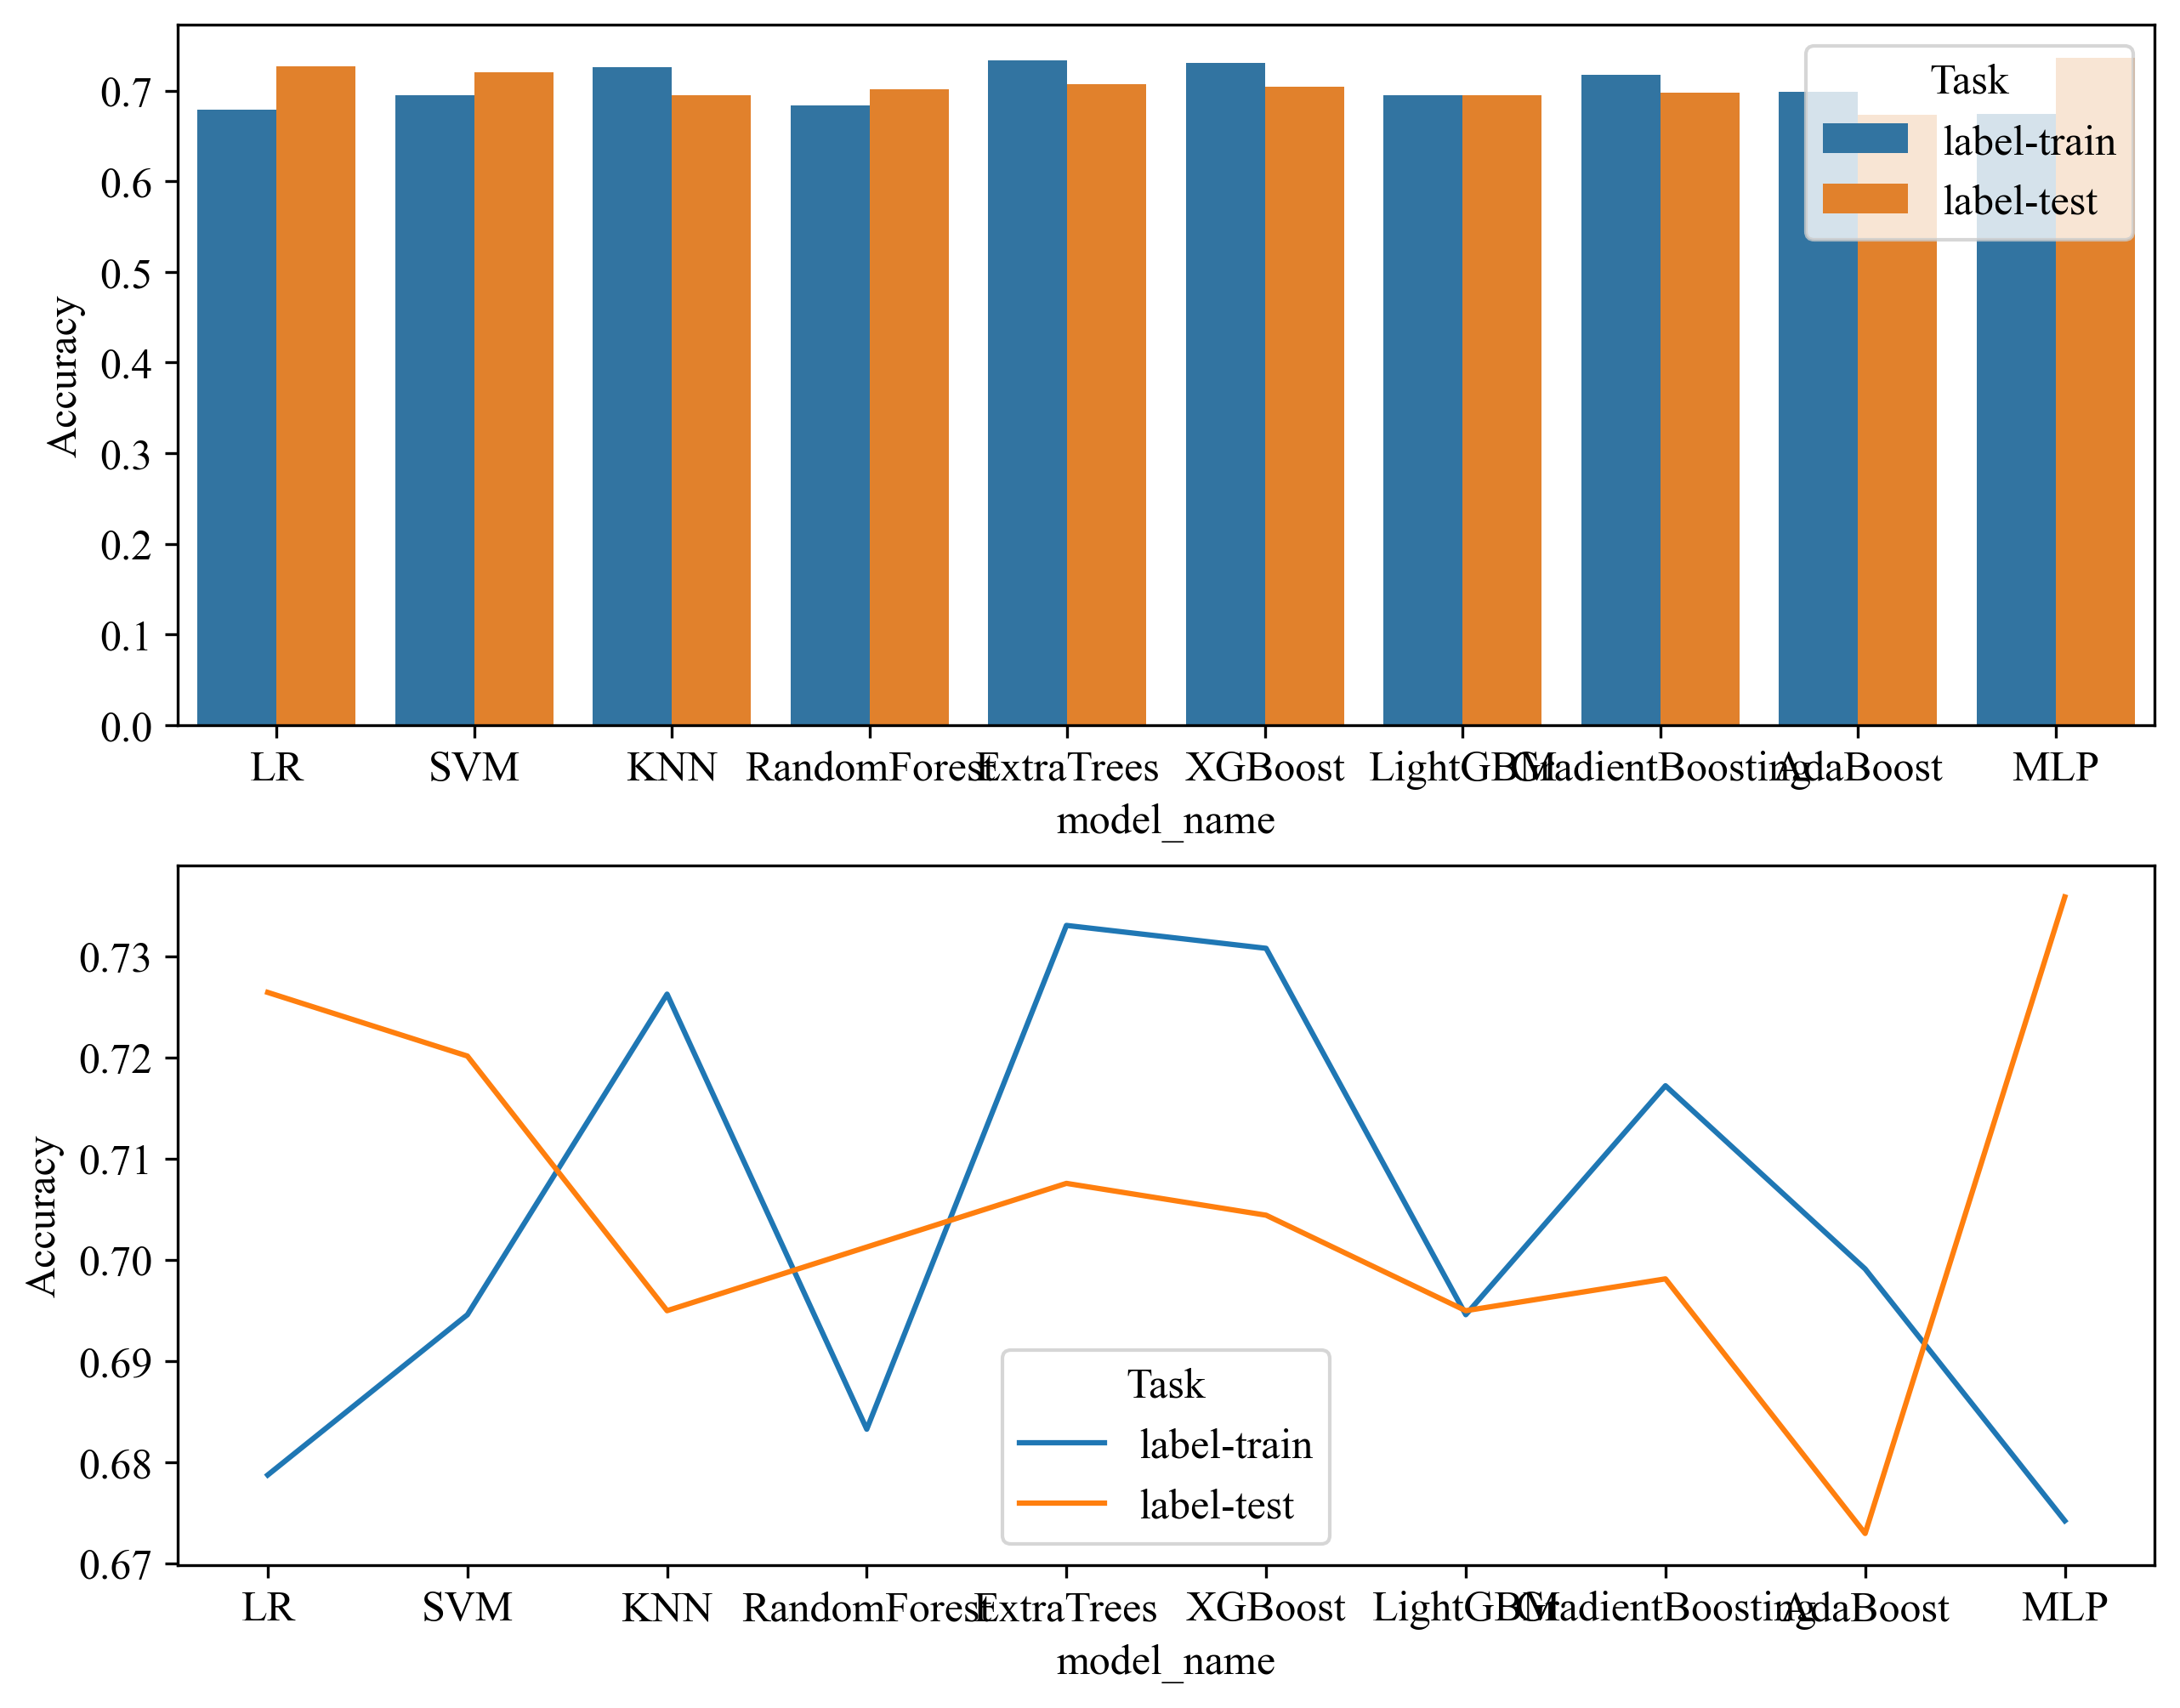

In [241]:
import seaborn as sns

plt.subplot(211)
sns.barplot(x='model_name', y='Accuracy', data=metric, hue='Task')
plt.subplot(212)
sns.lineplot(x='model_name', y='Accuracy', data=metric, hue='Task')
plt.savefig(f'img/Clinic_model_acc.svg', bbox_inches = 'tight')

## 绘制ROC曲线
确定最好的模型，并且绘制曲线。

```python
def draw_roc(y_test, y_score, title='ROC', labels=None):
```

`sel_model = ['SVM', 'KNN']`参数为想要绘制的模型对应的参数。

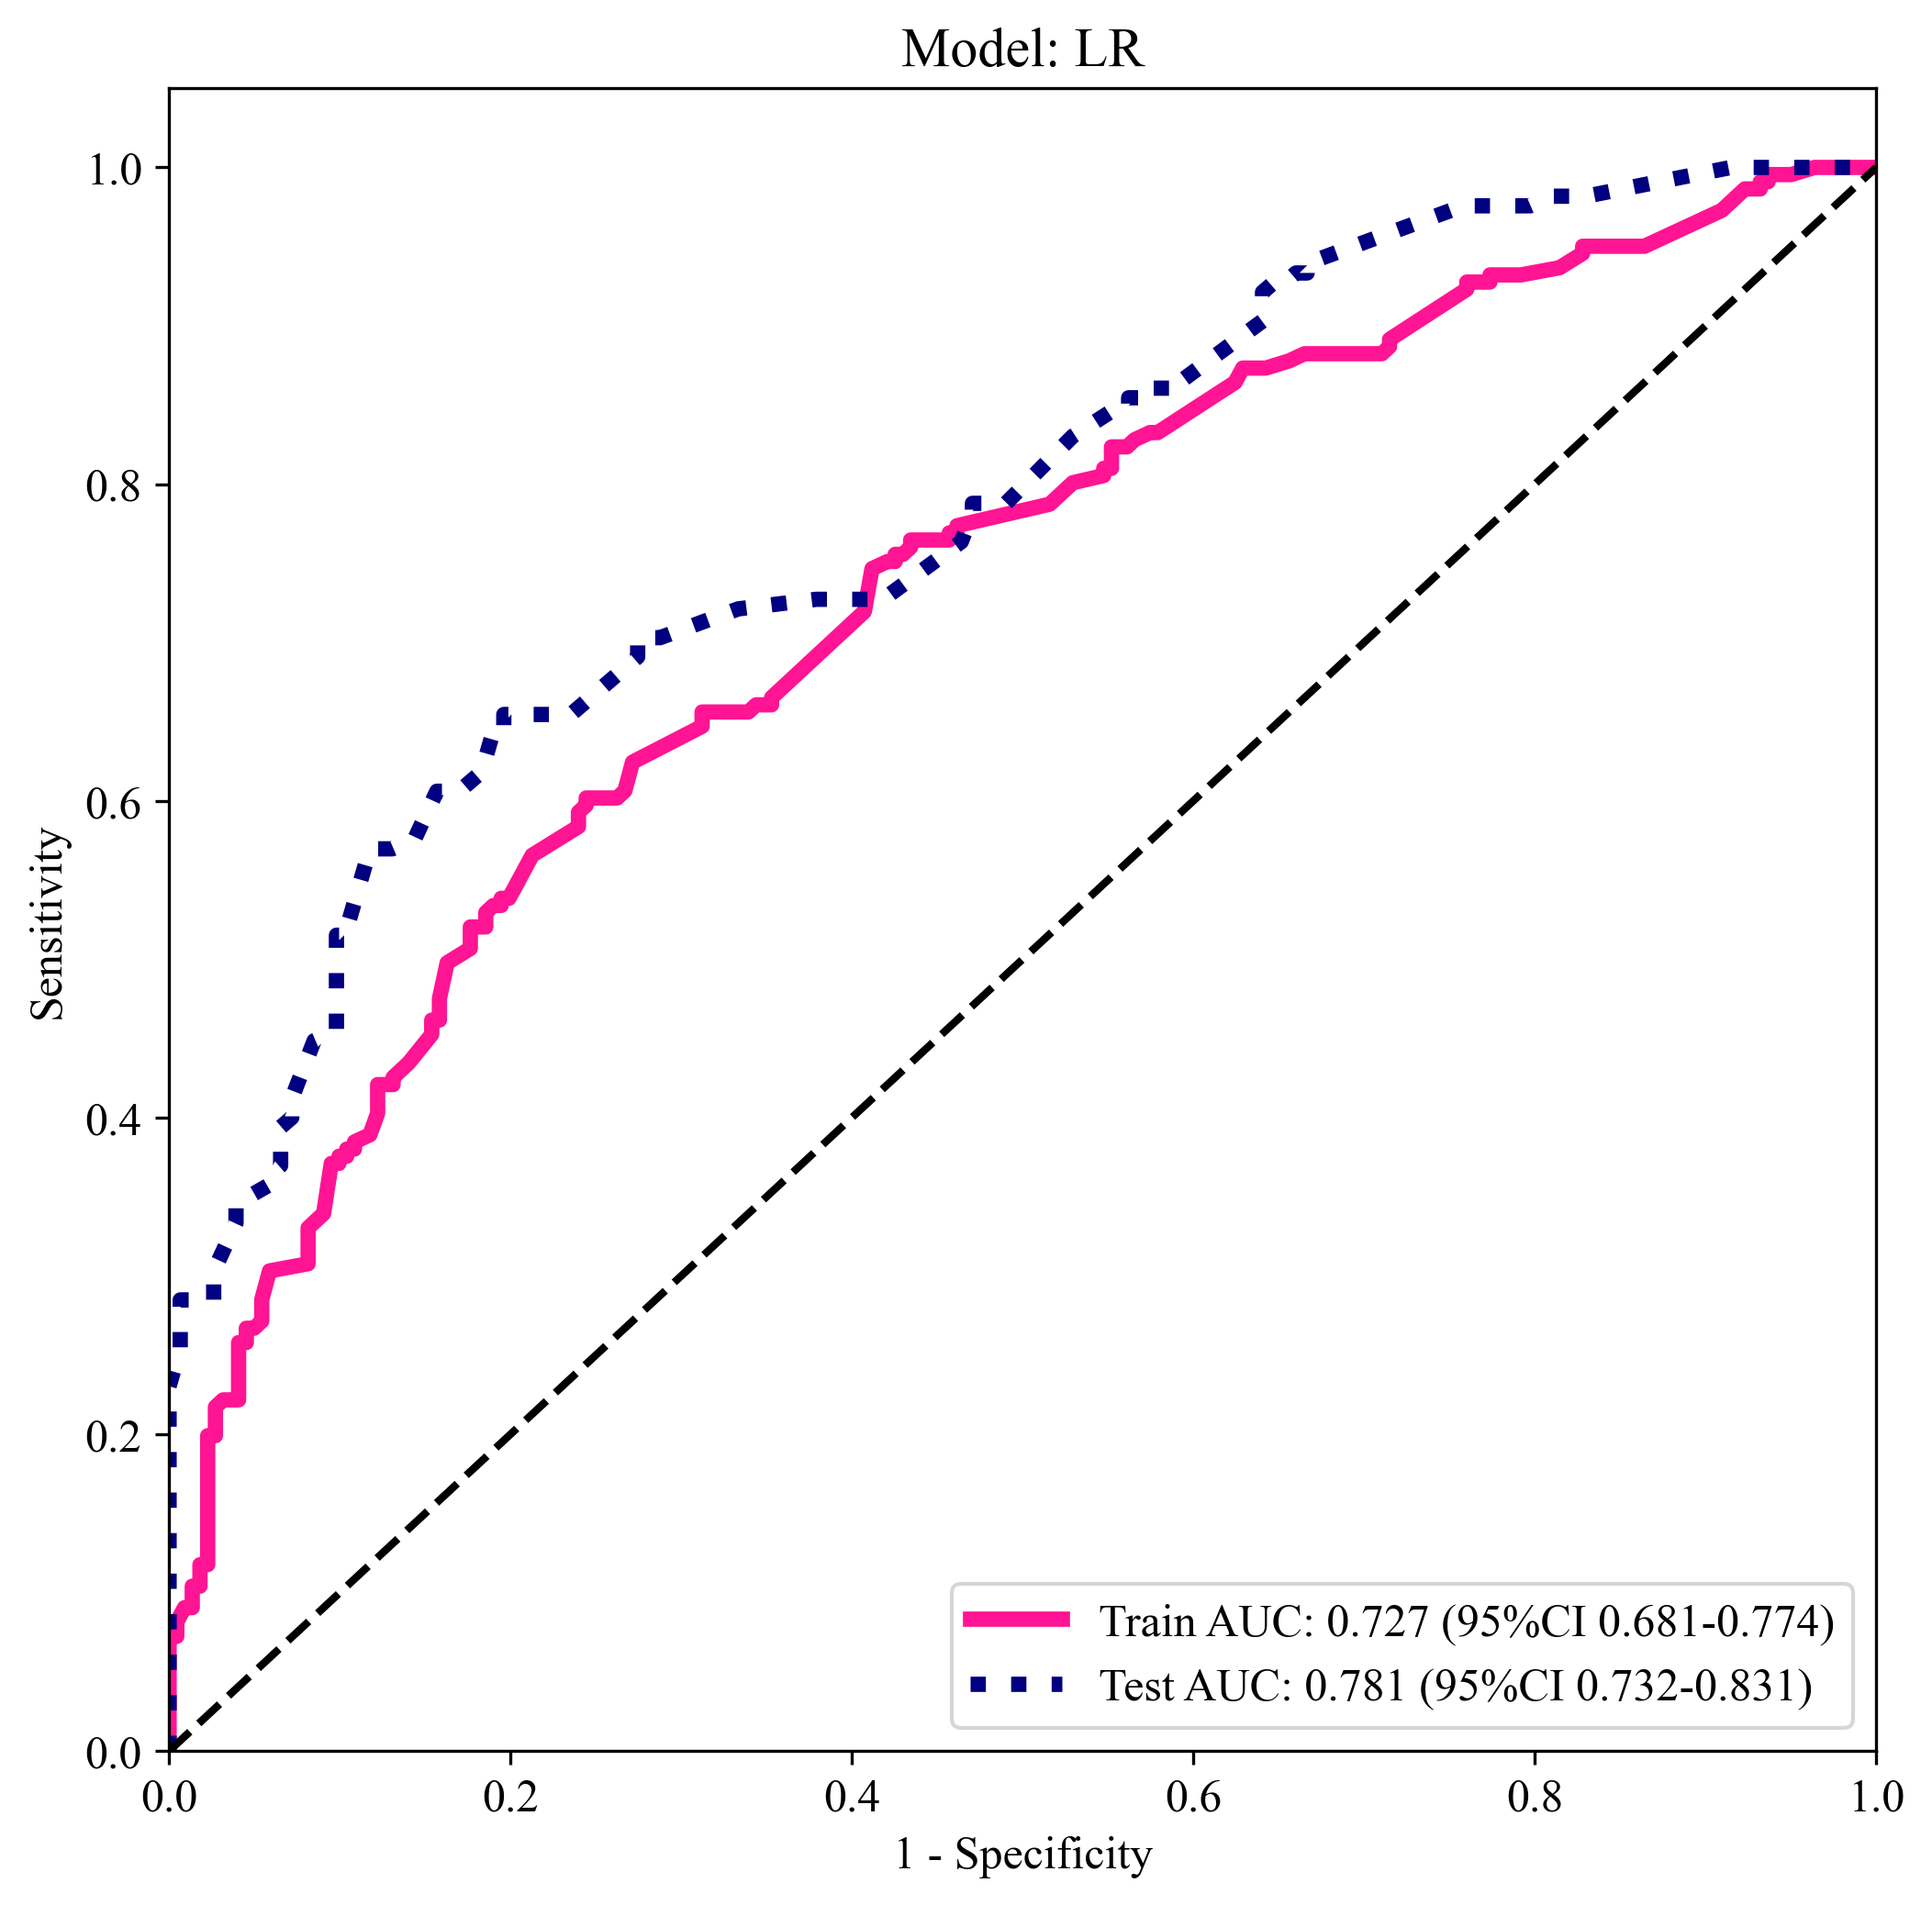

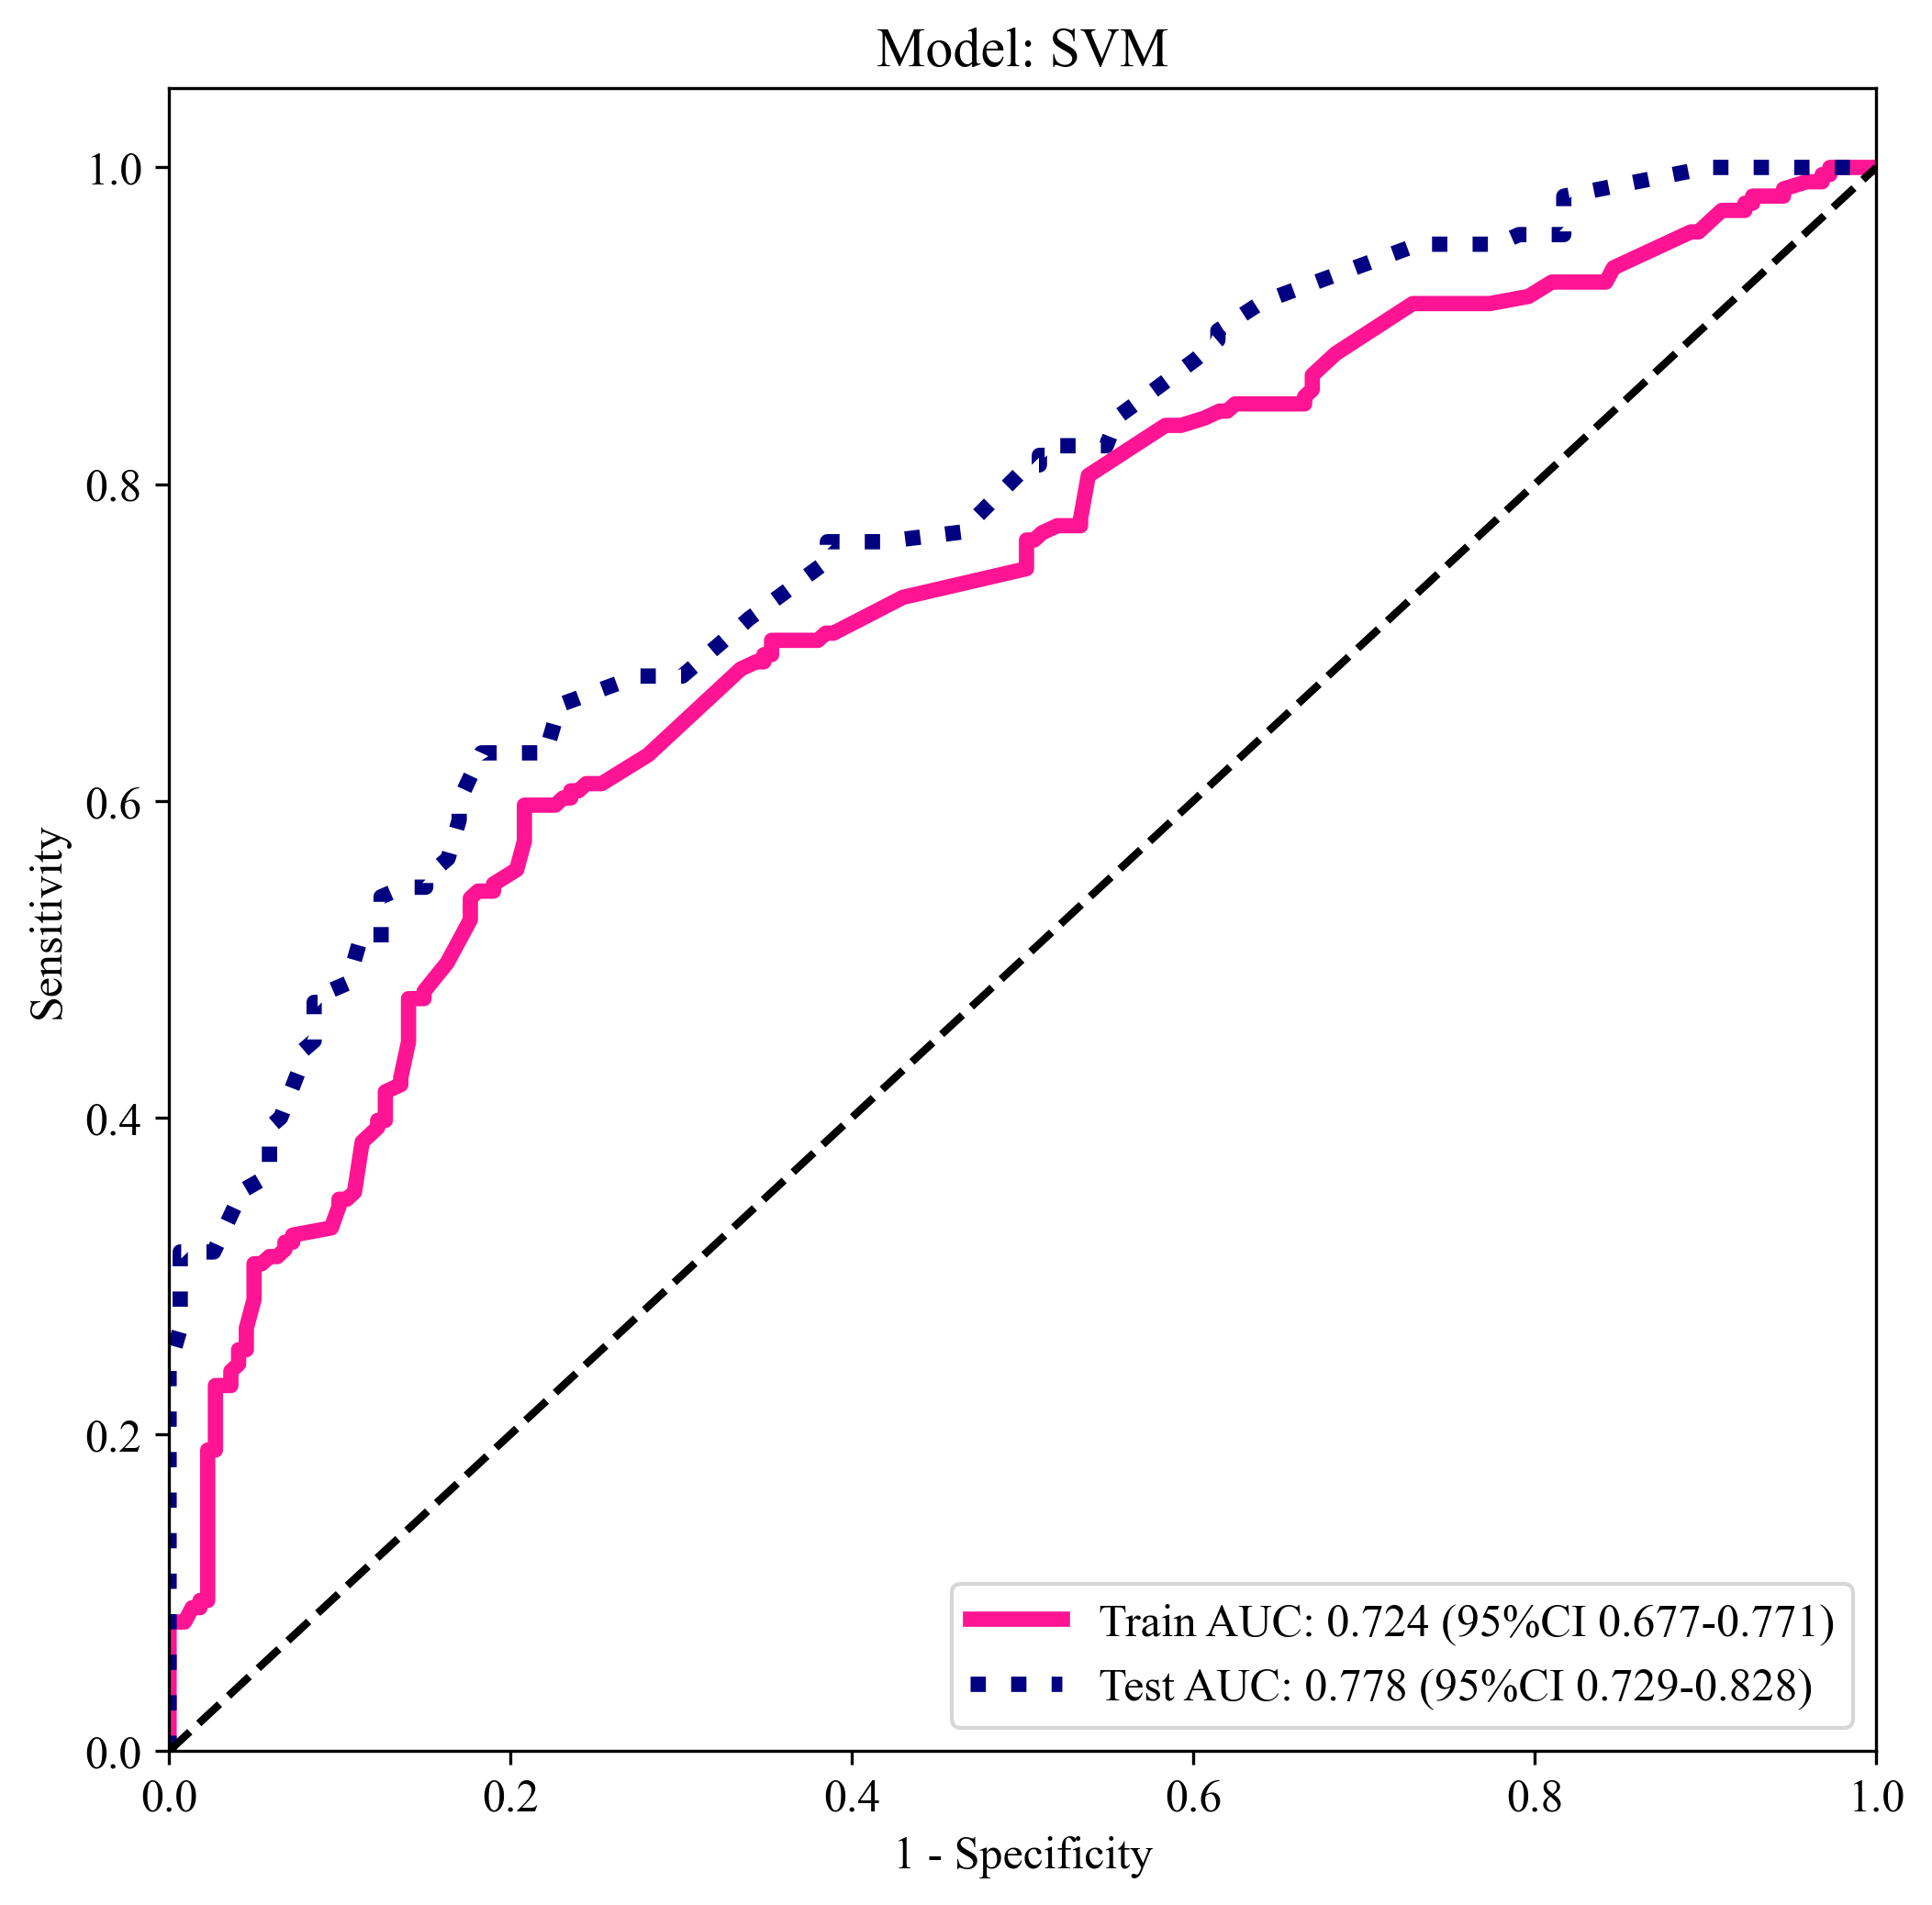

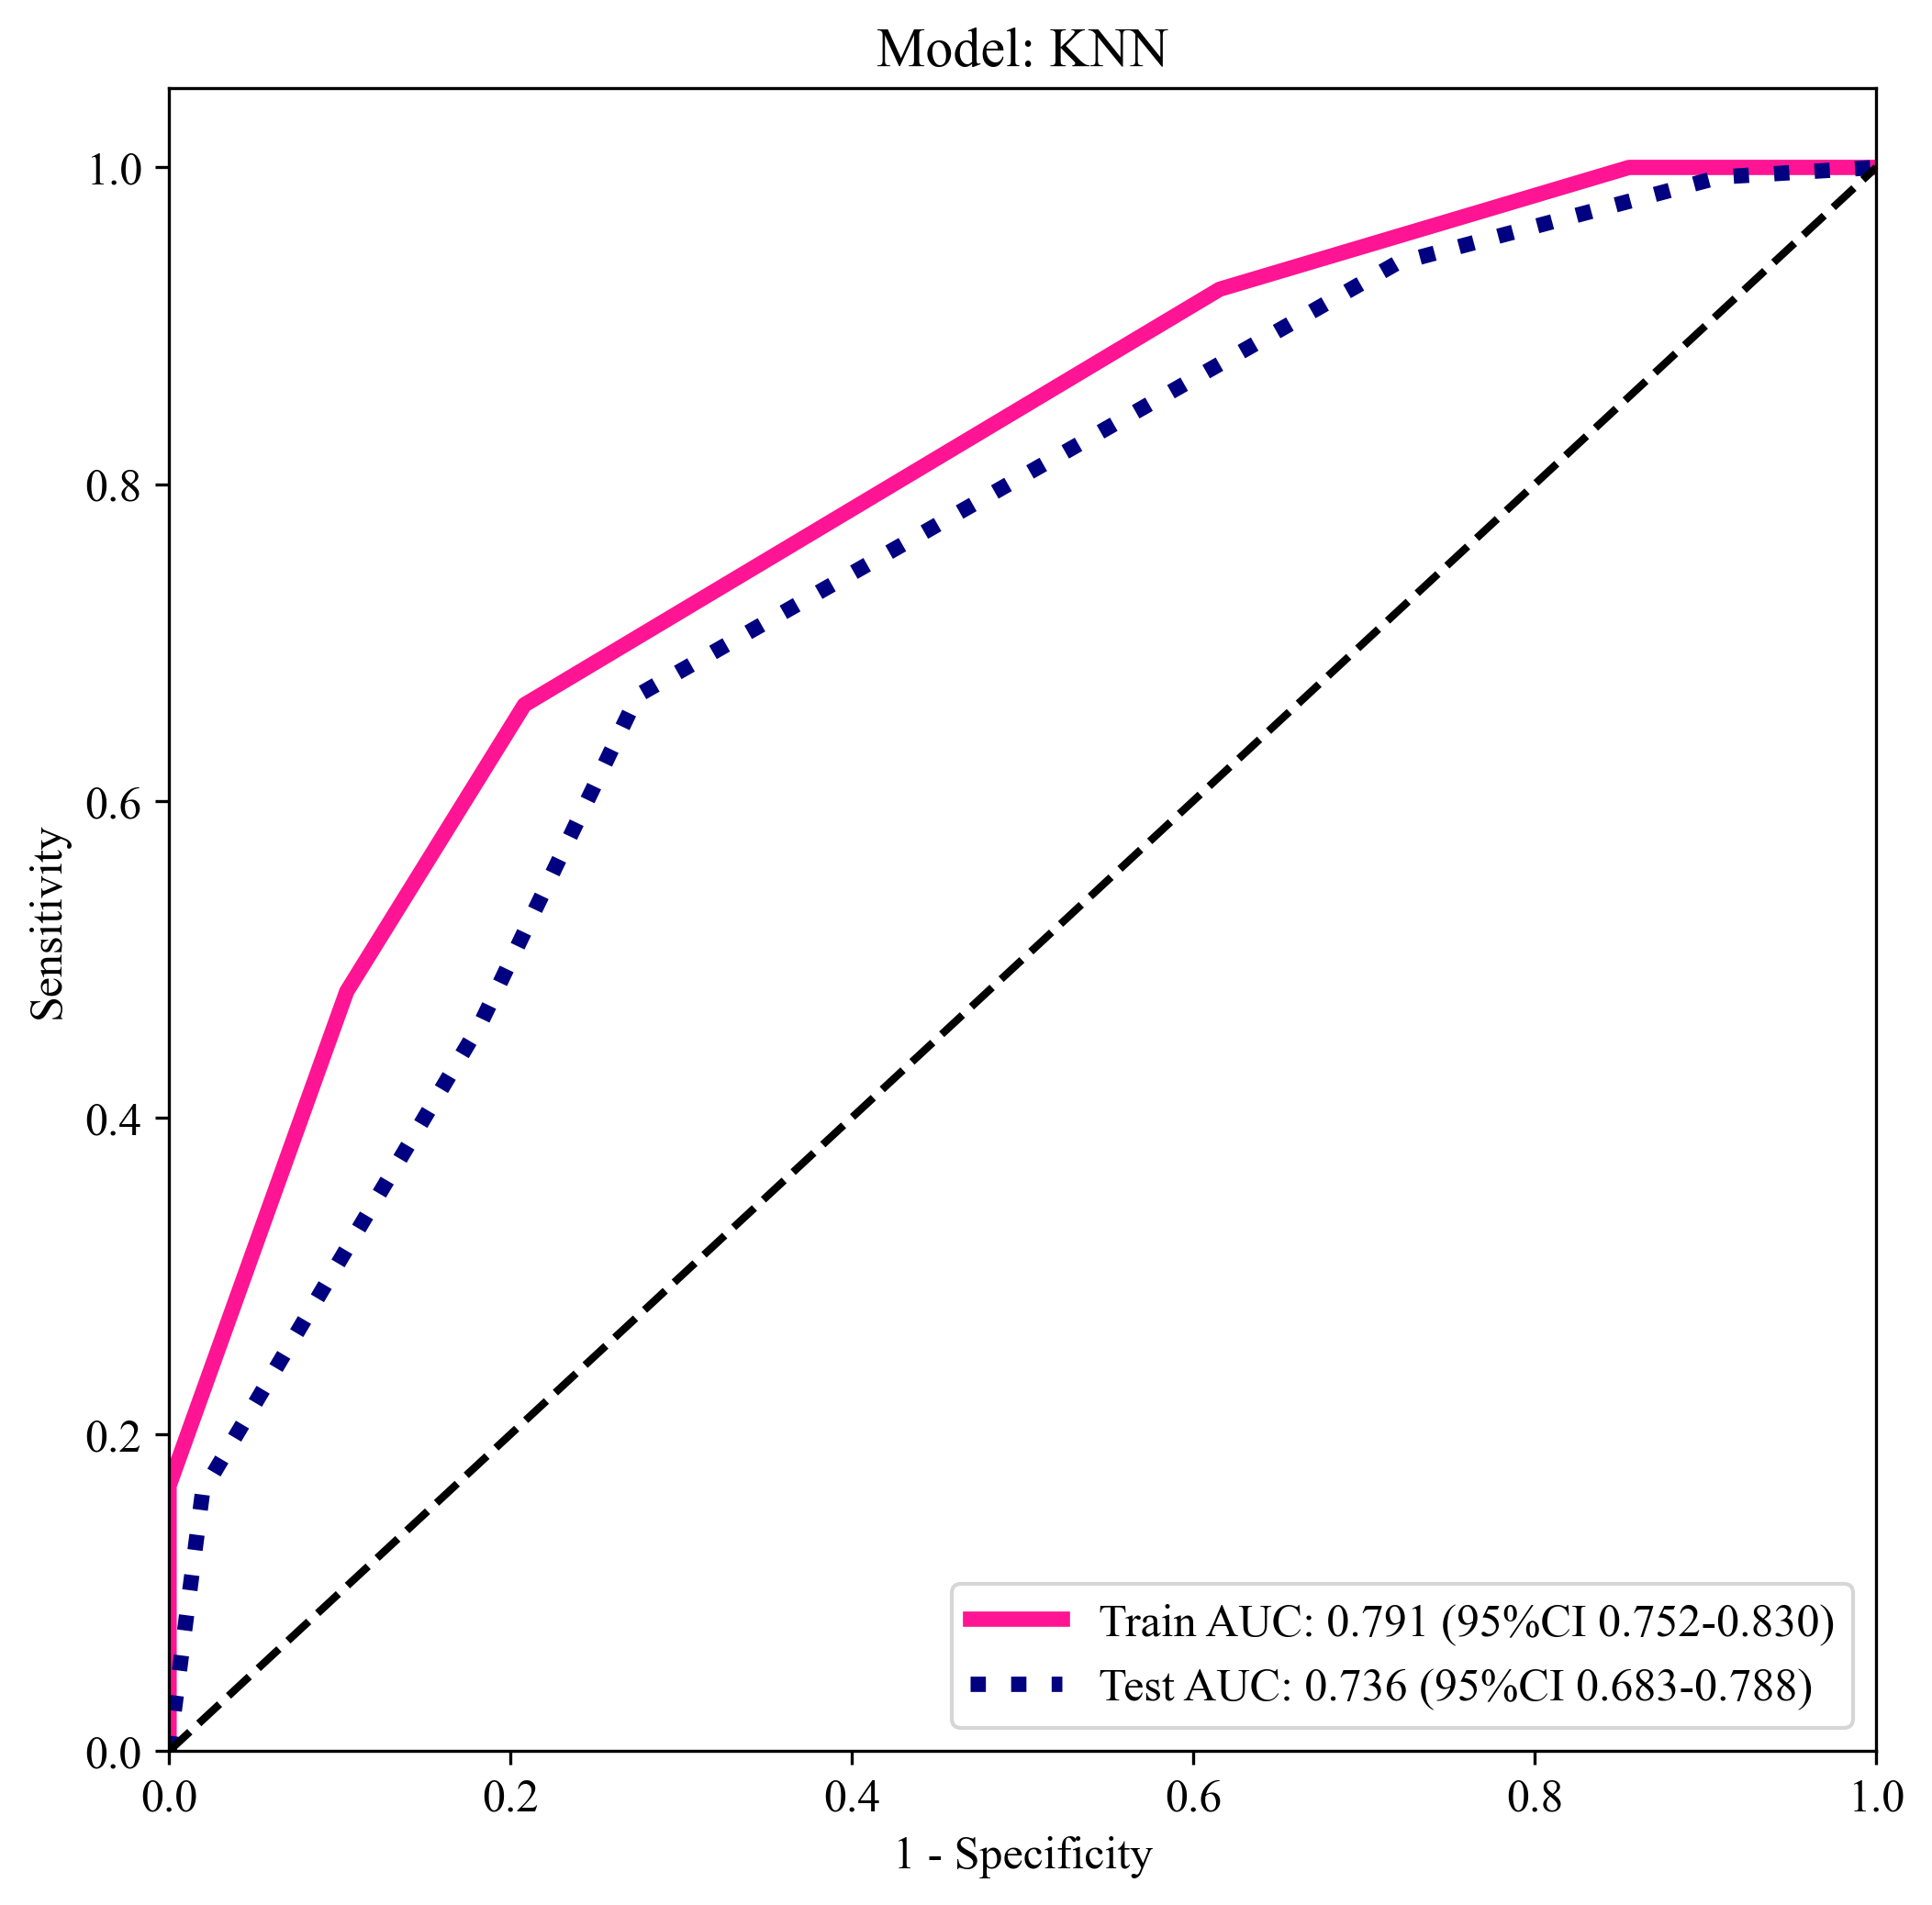

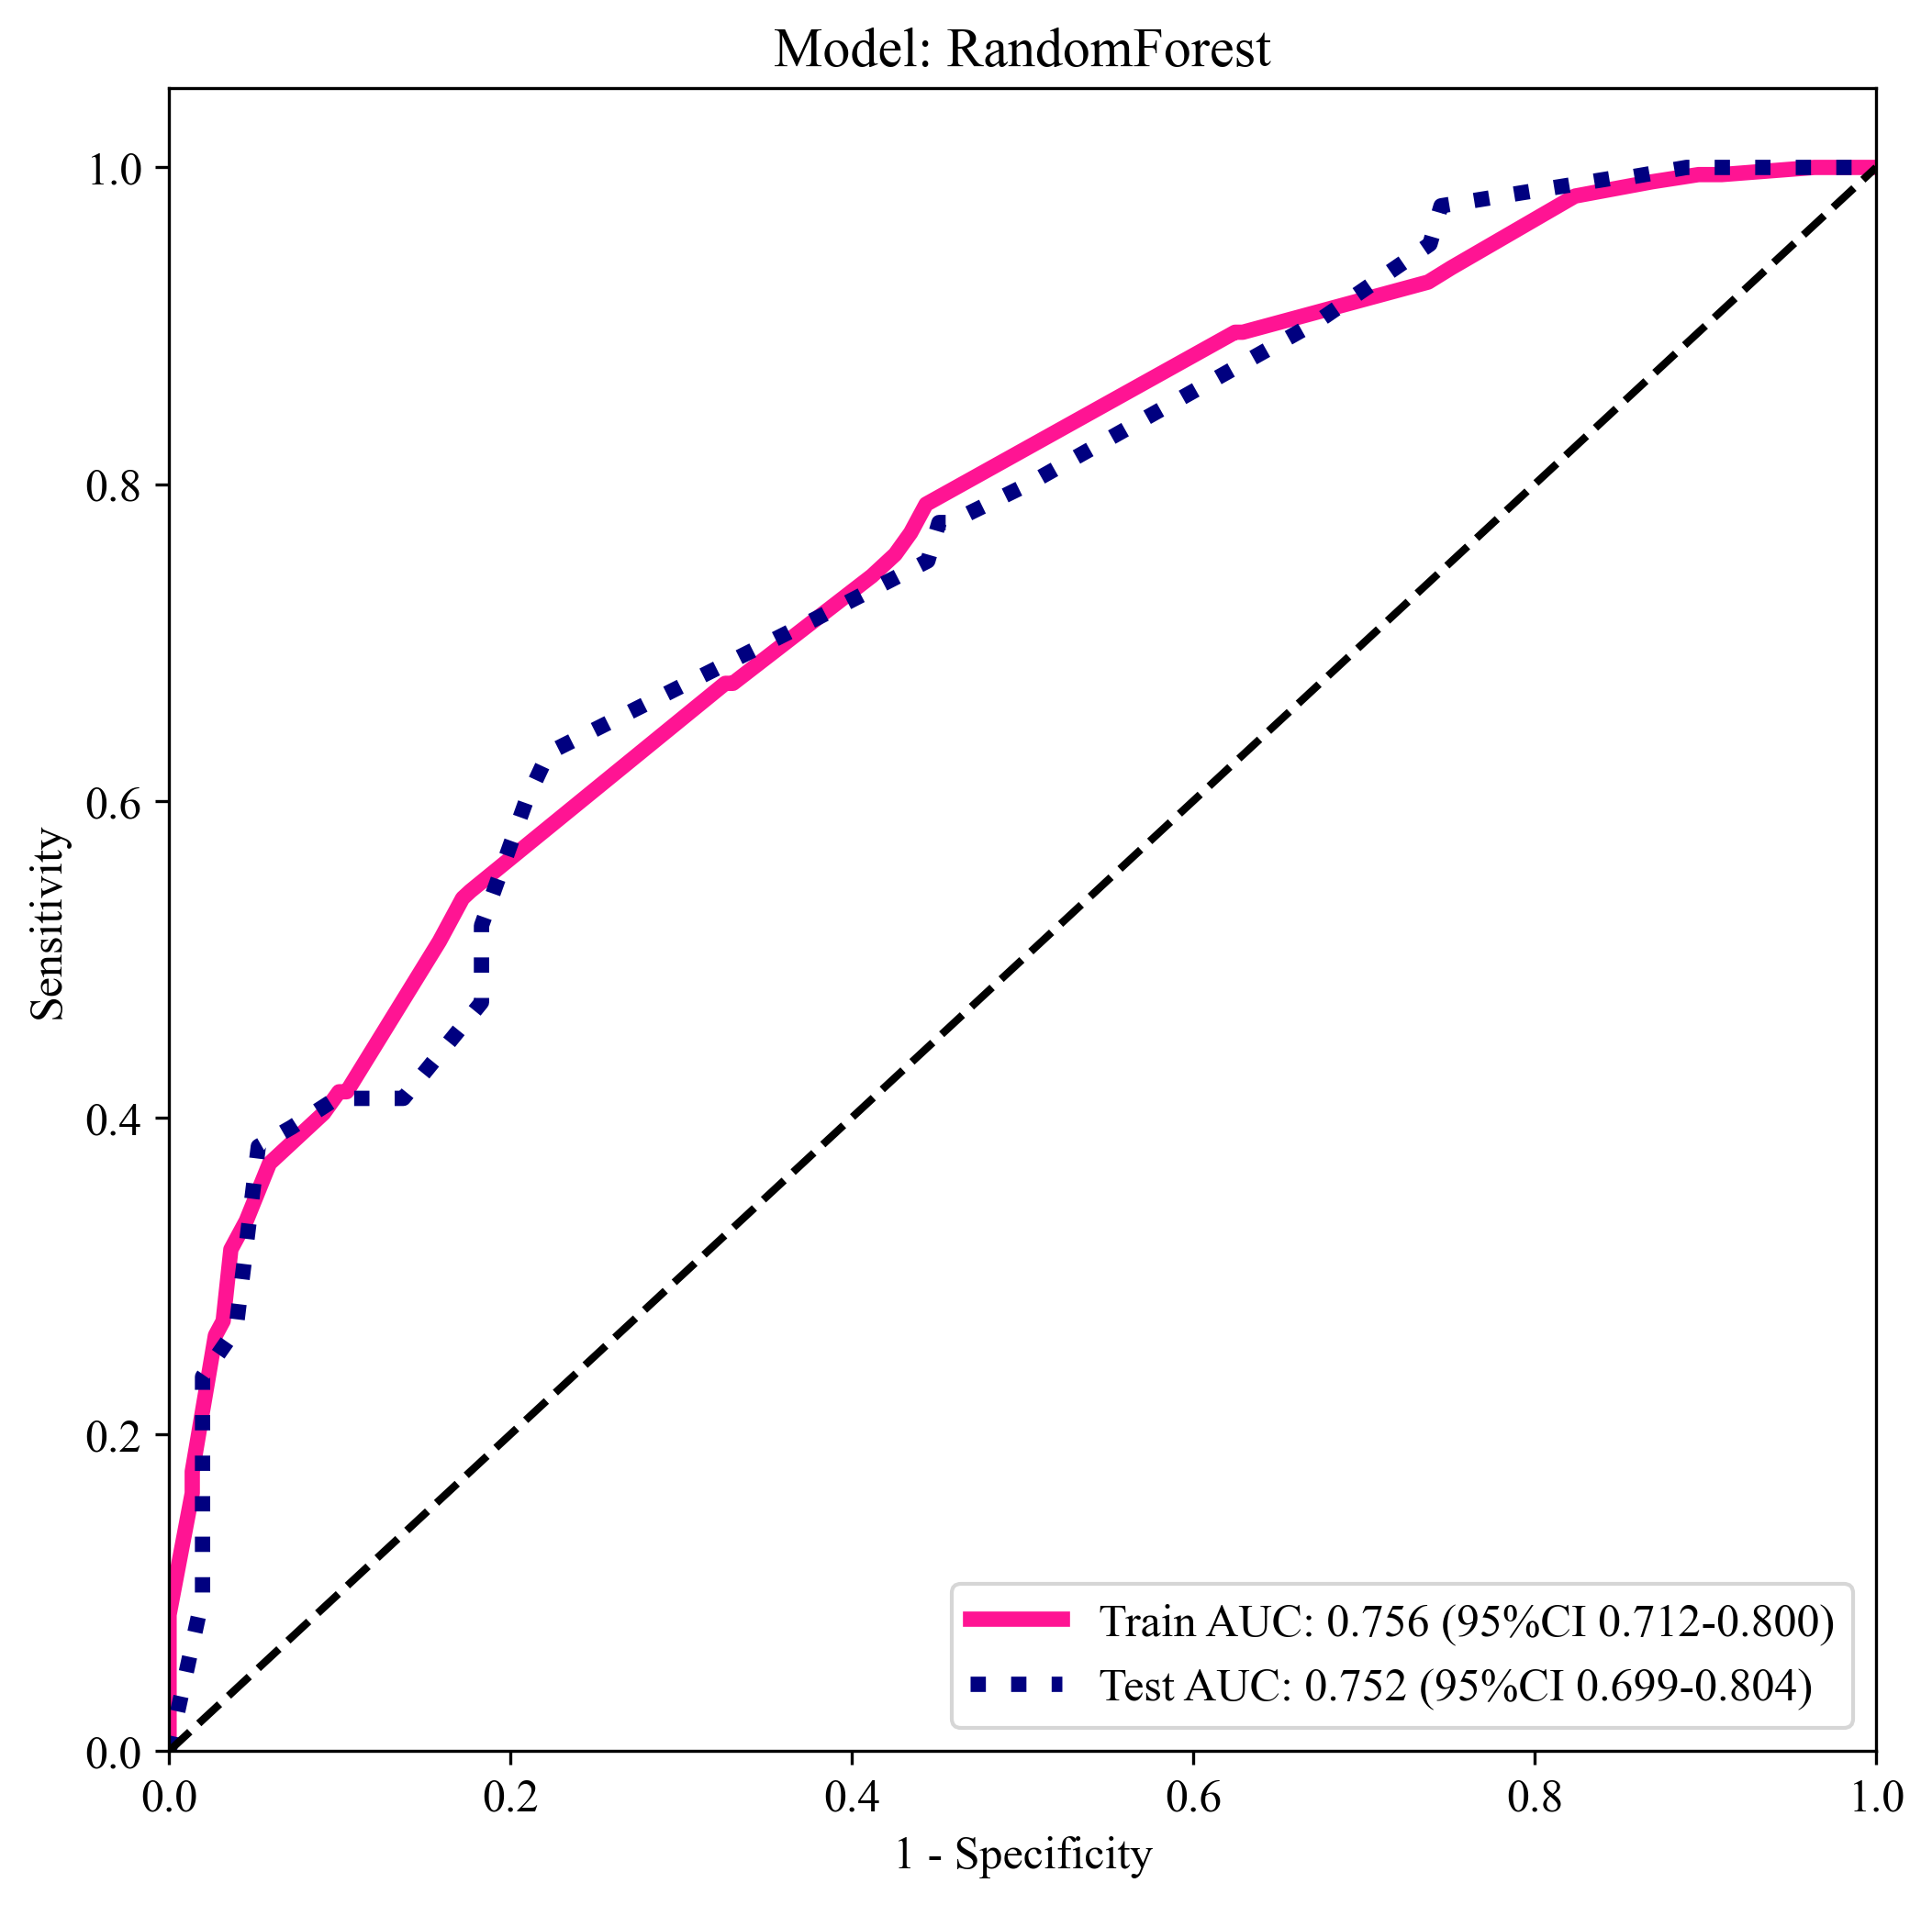

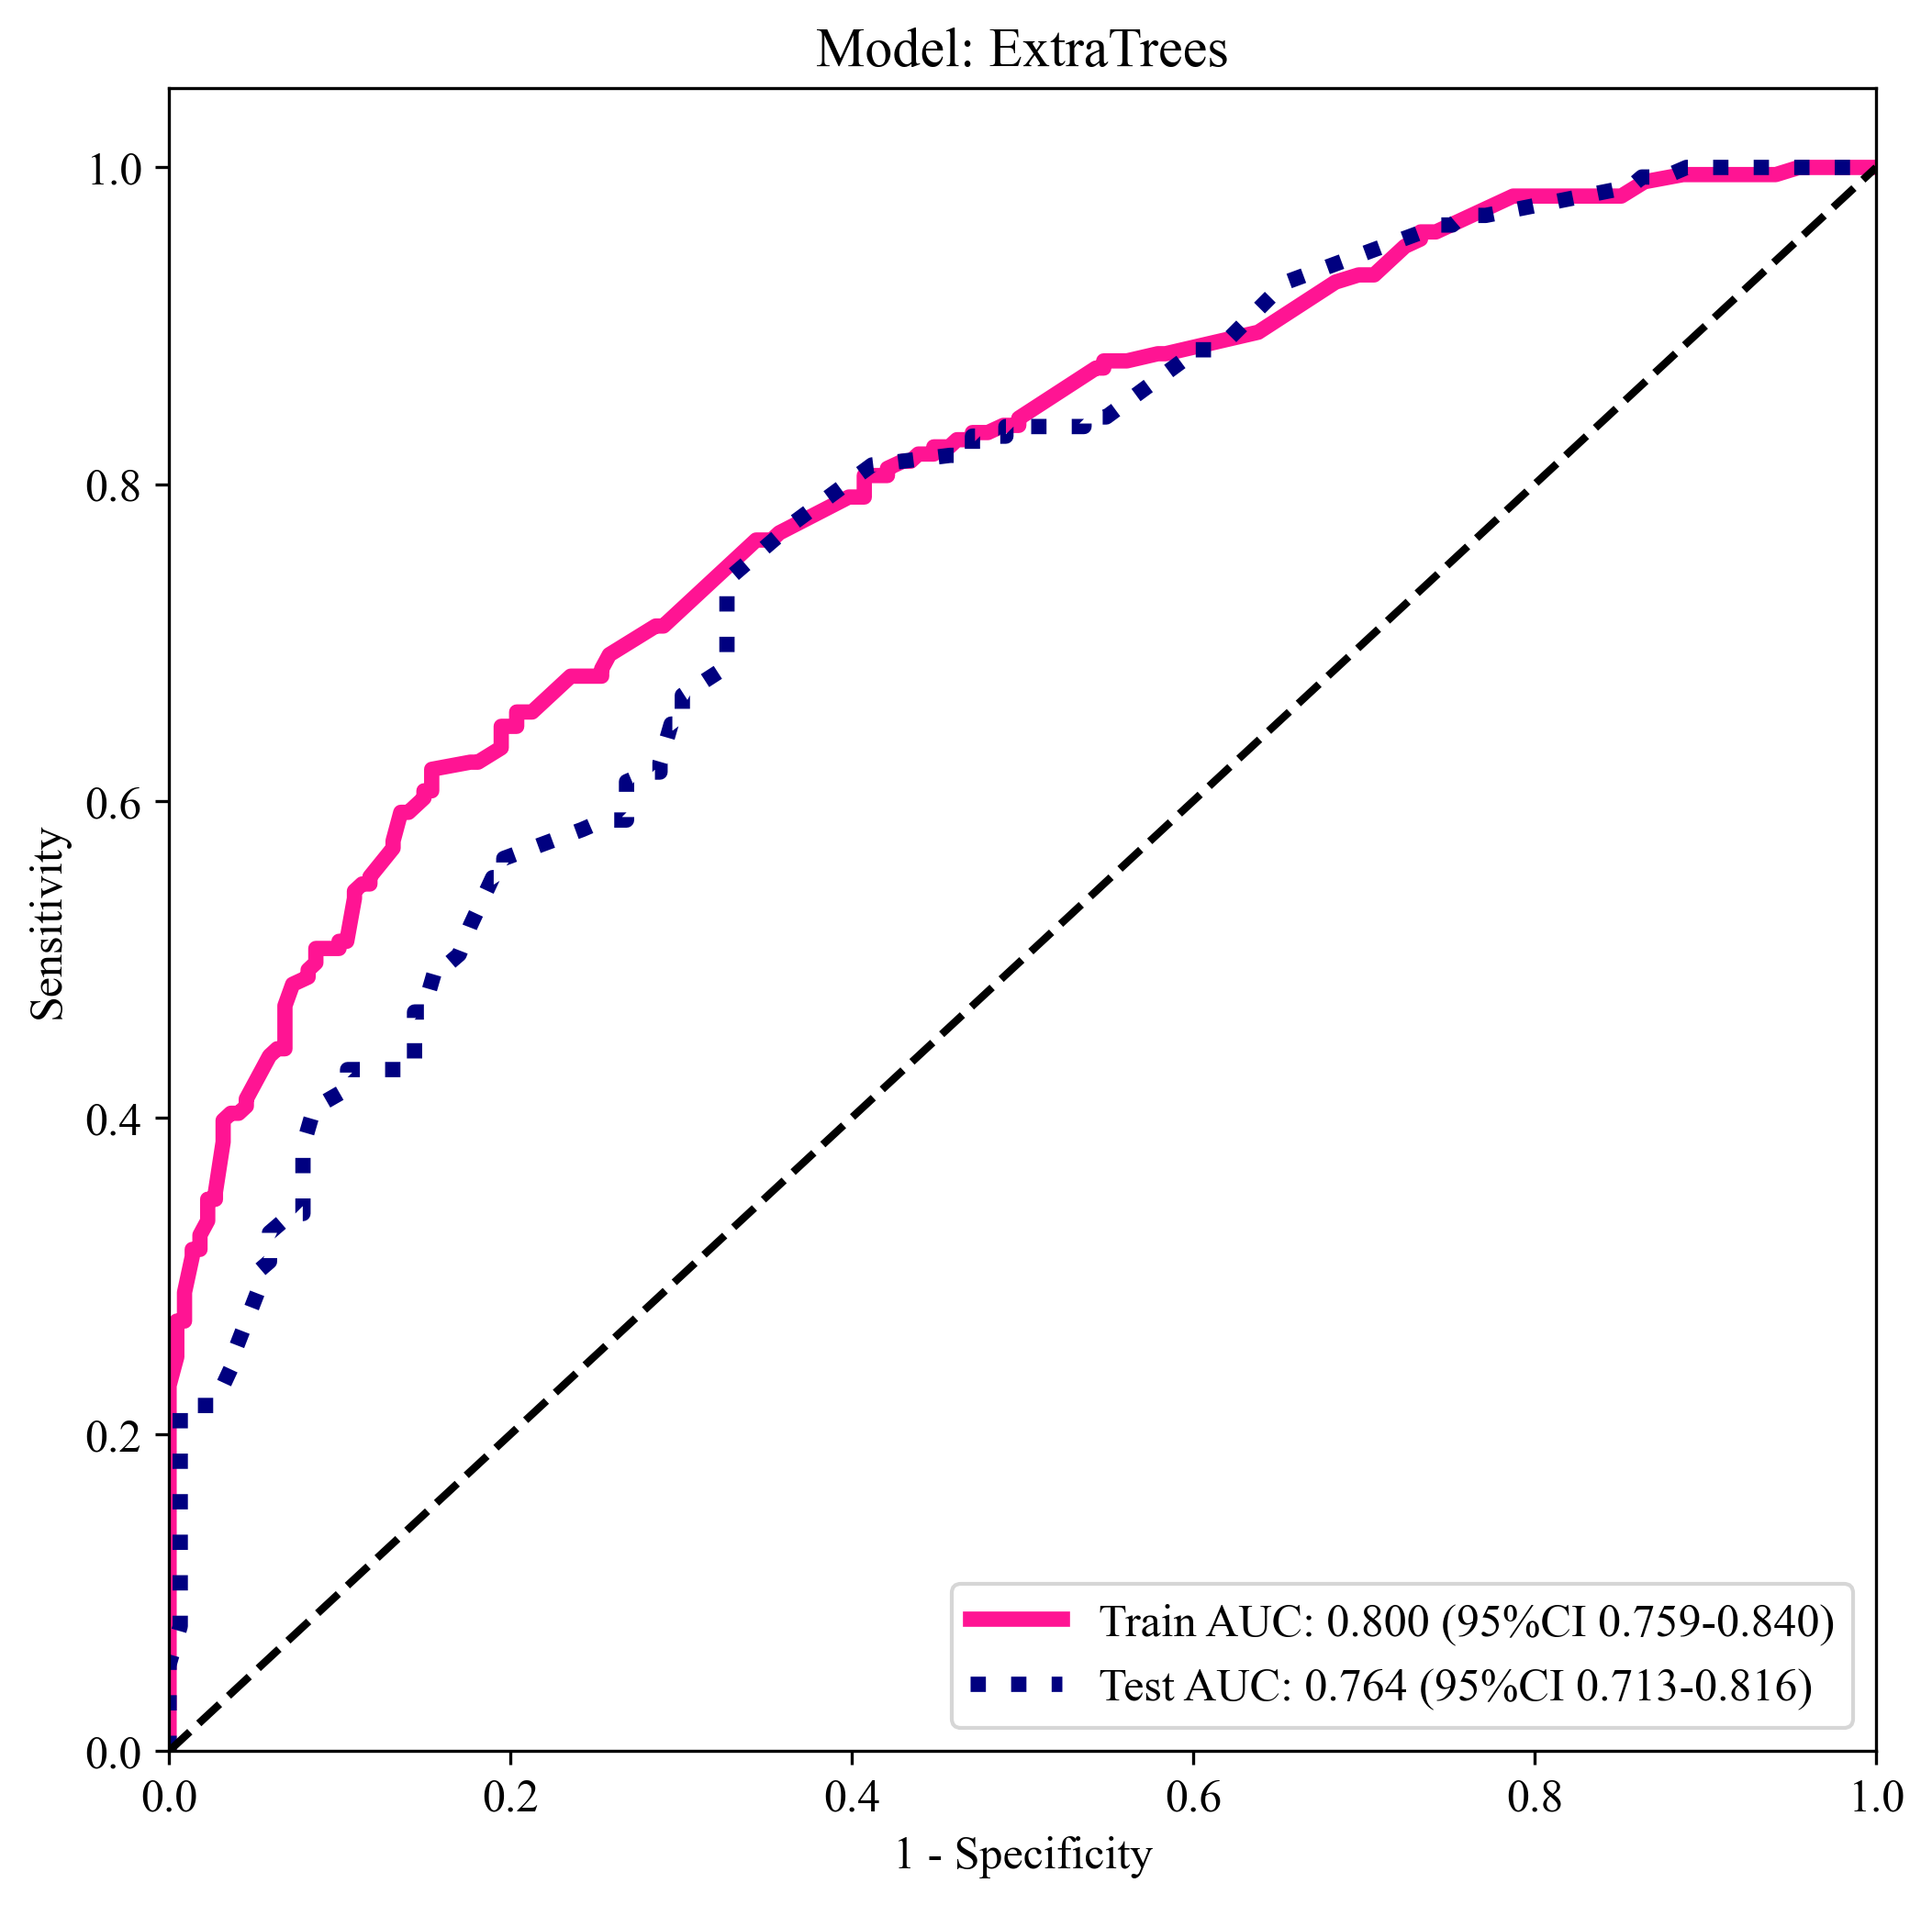

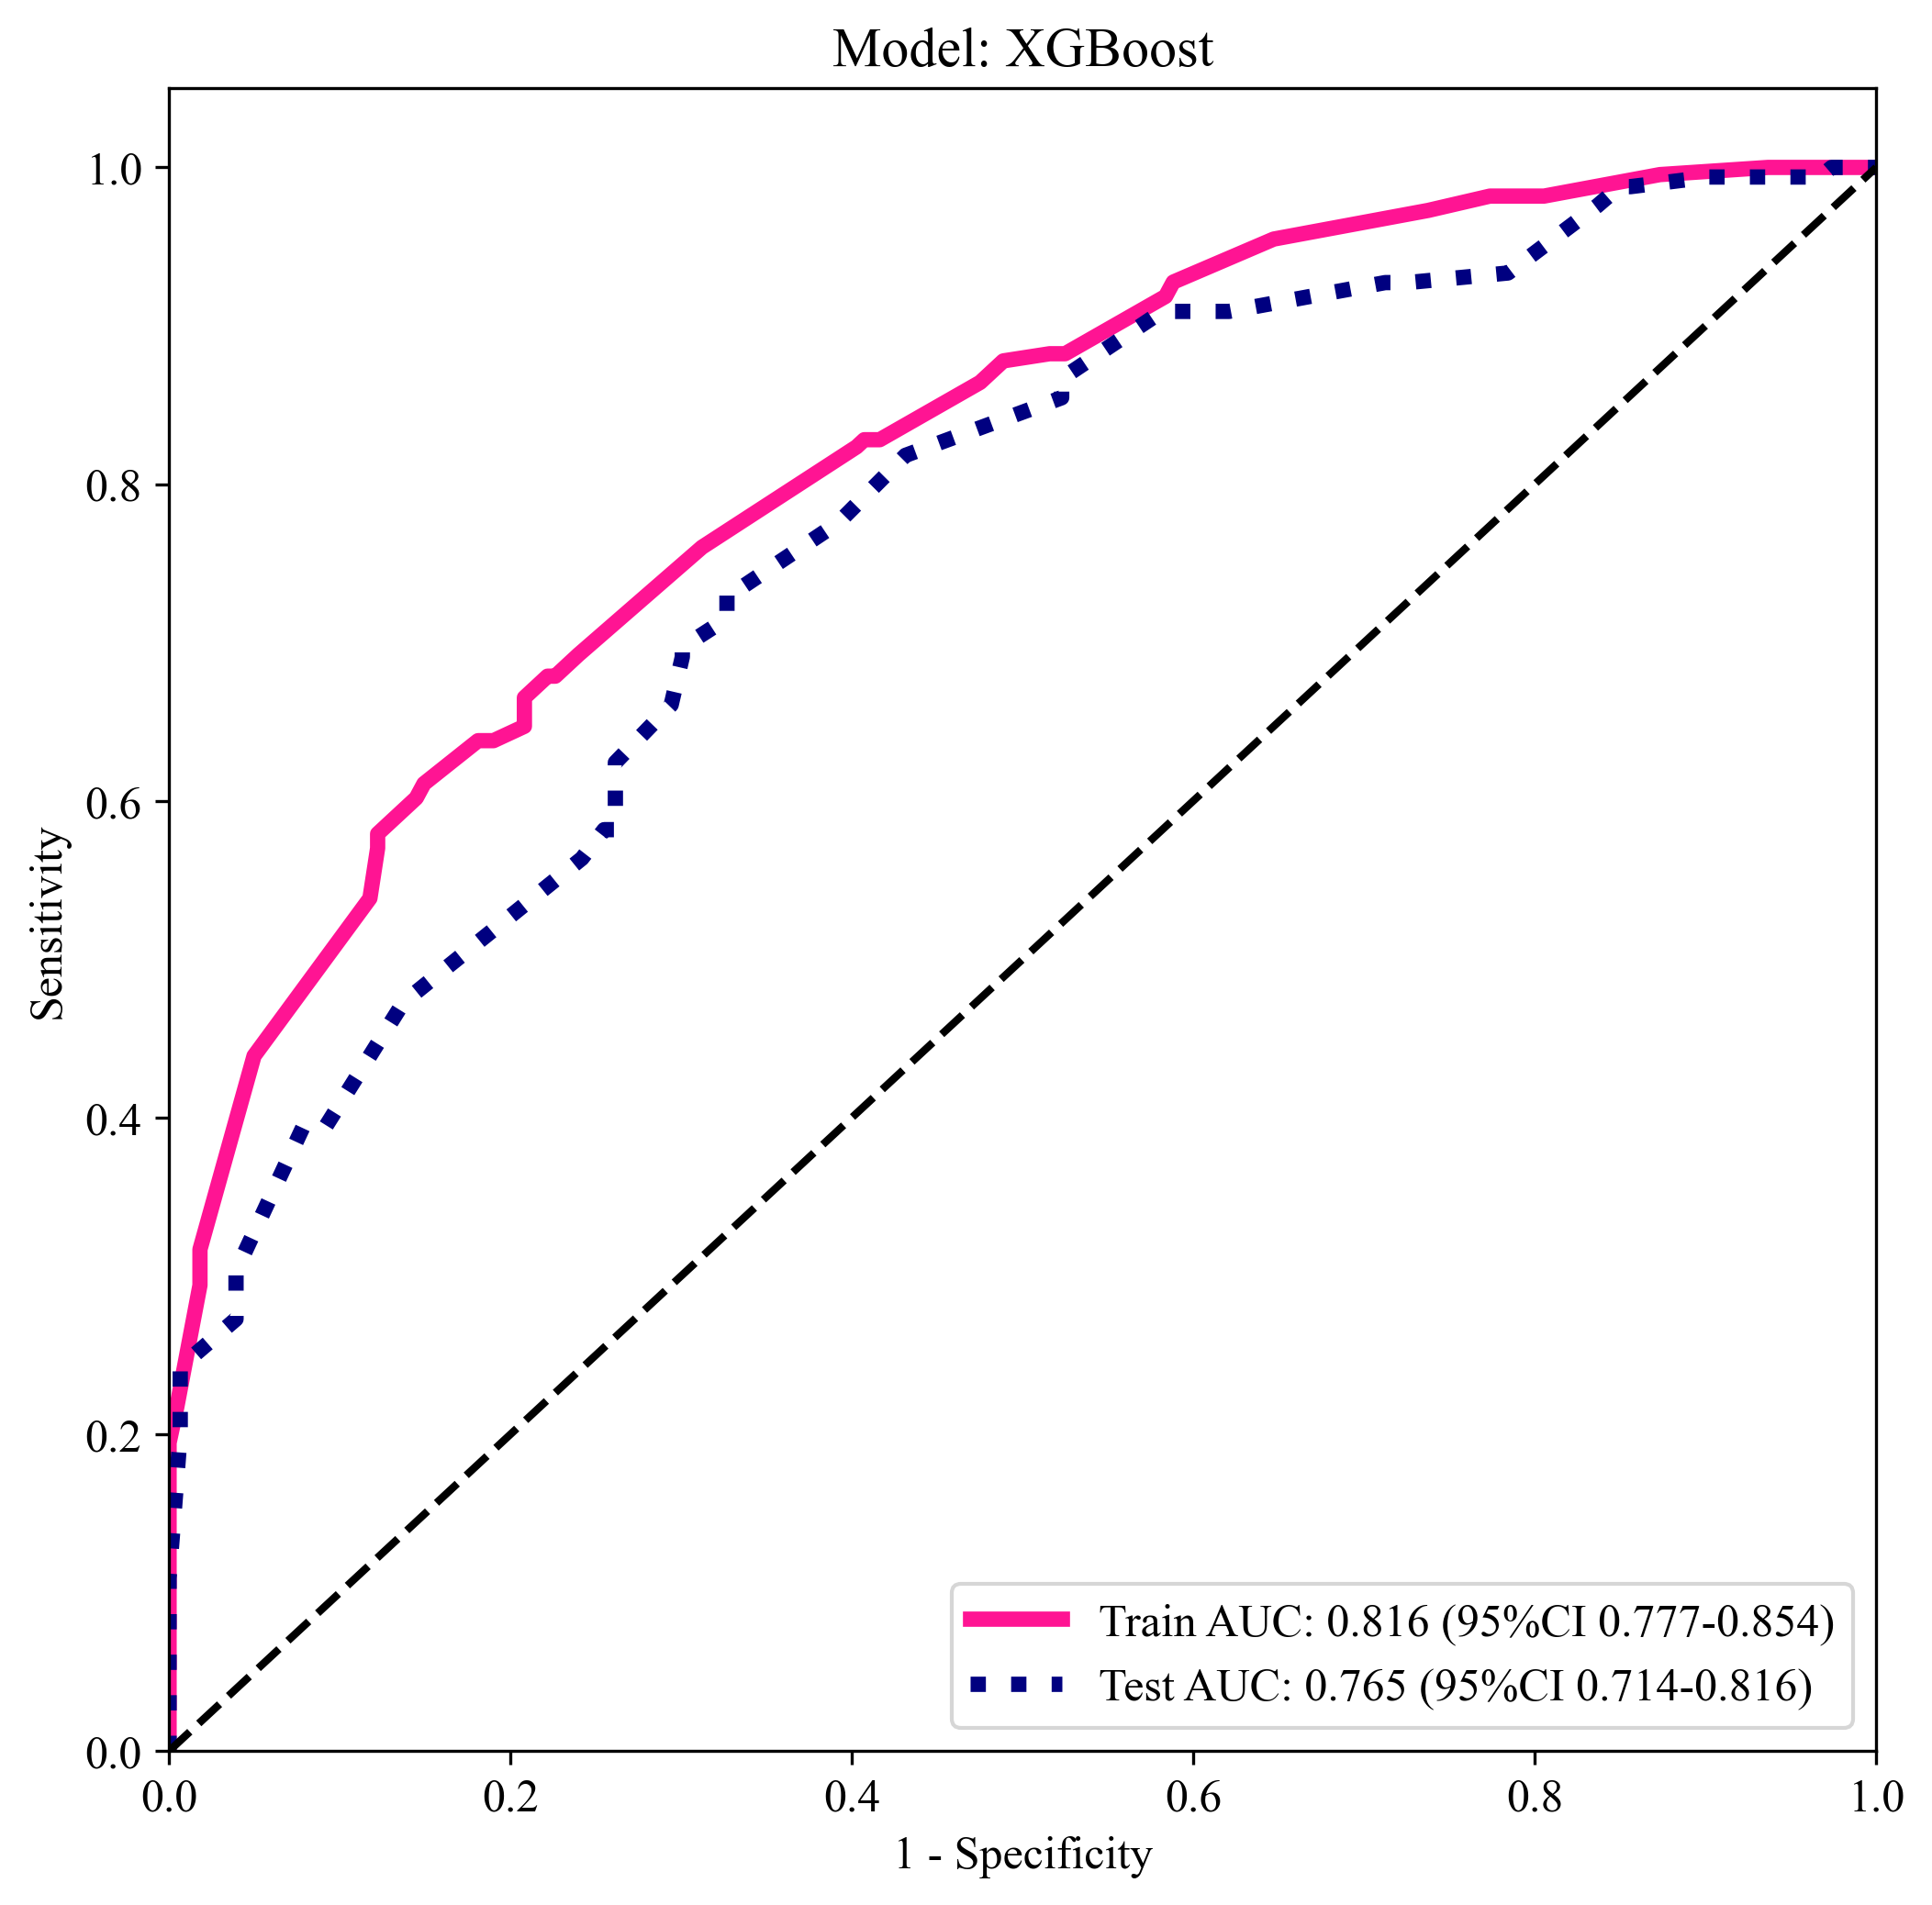

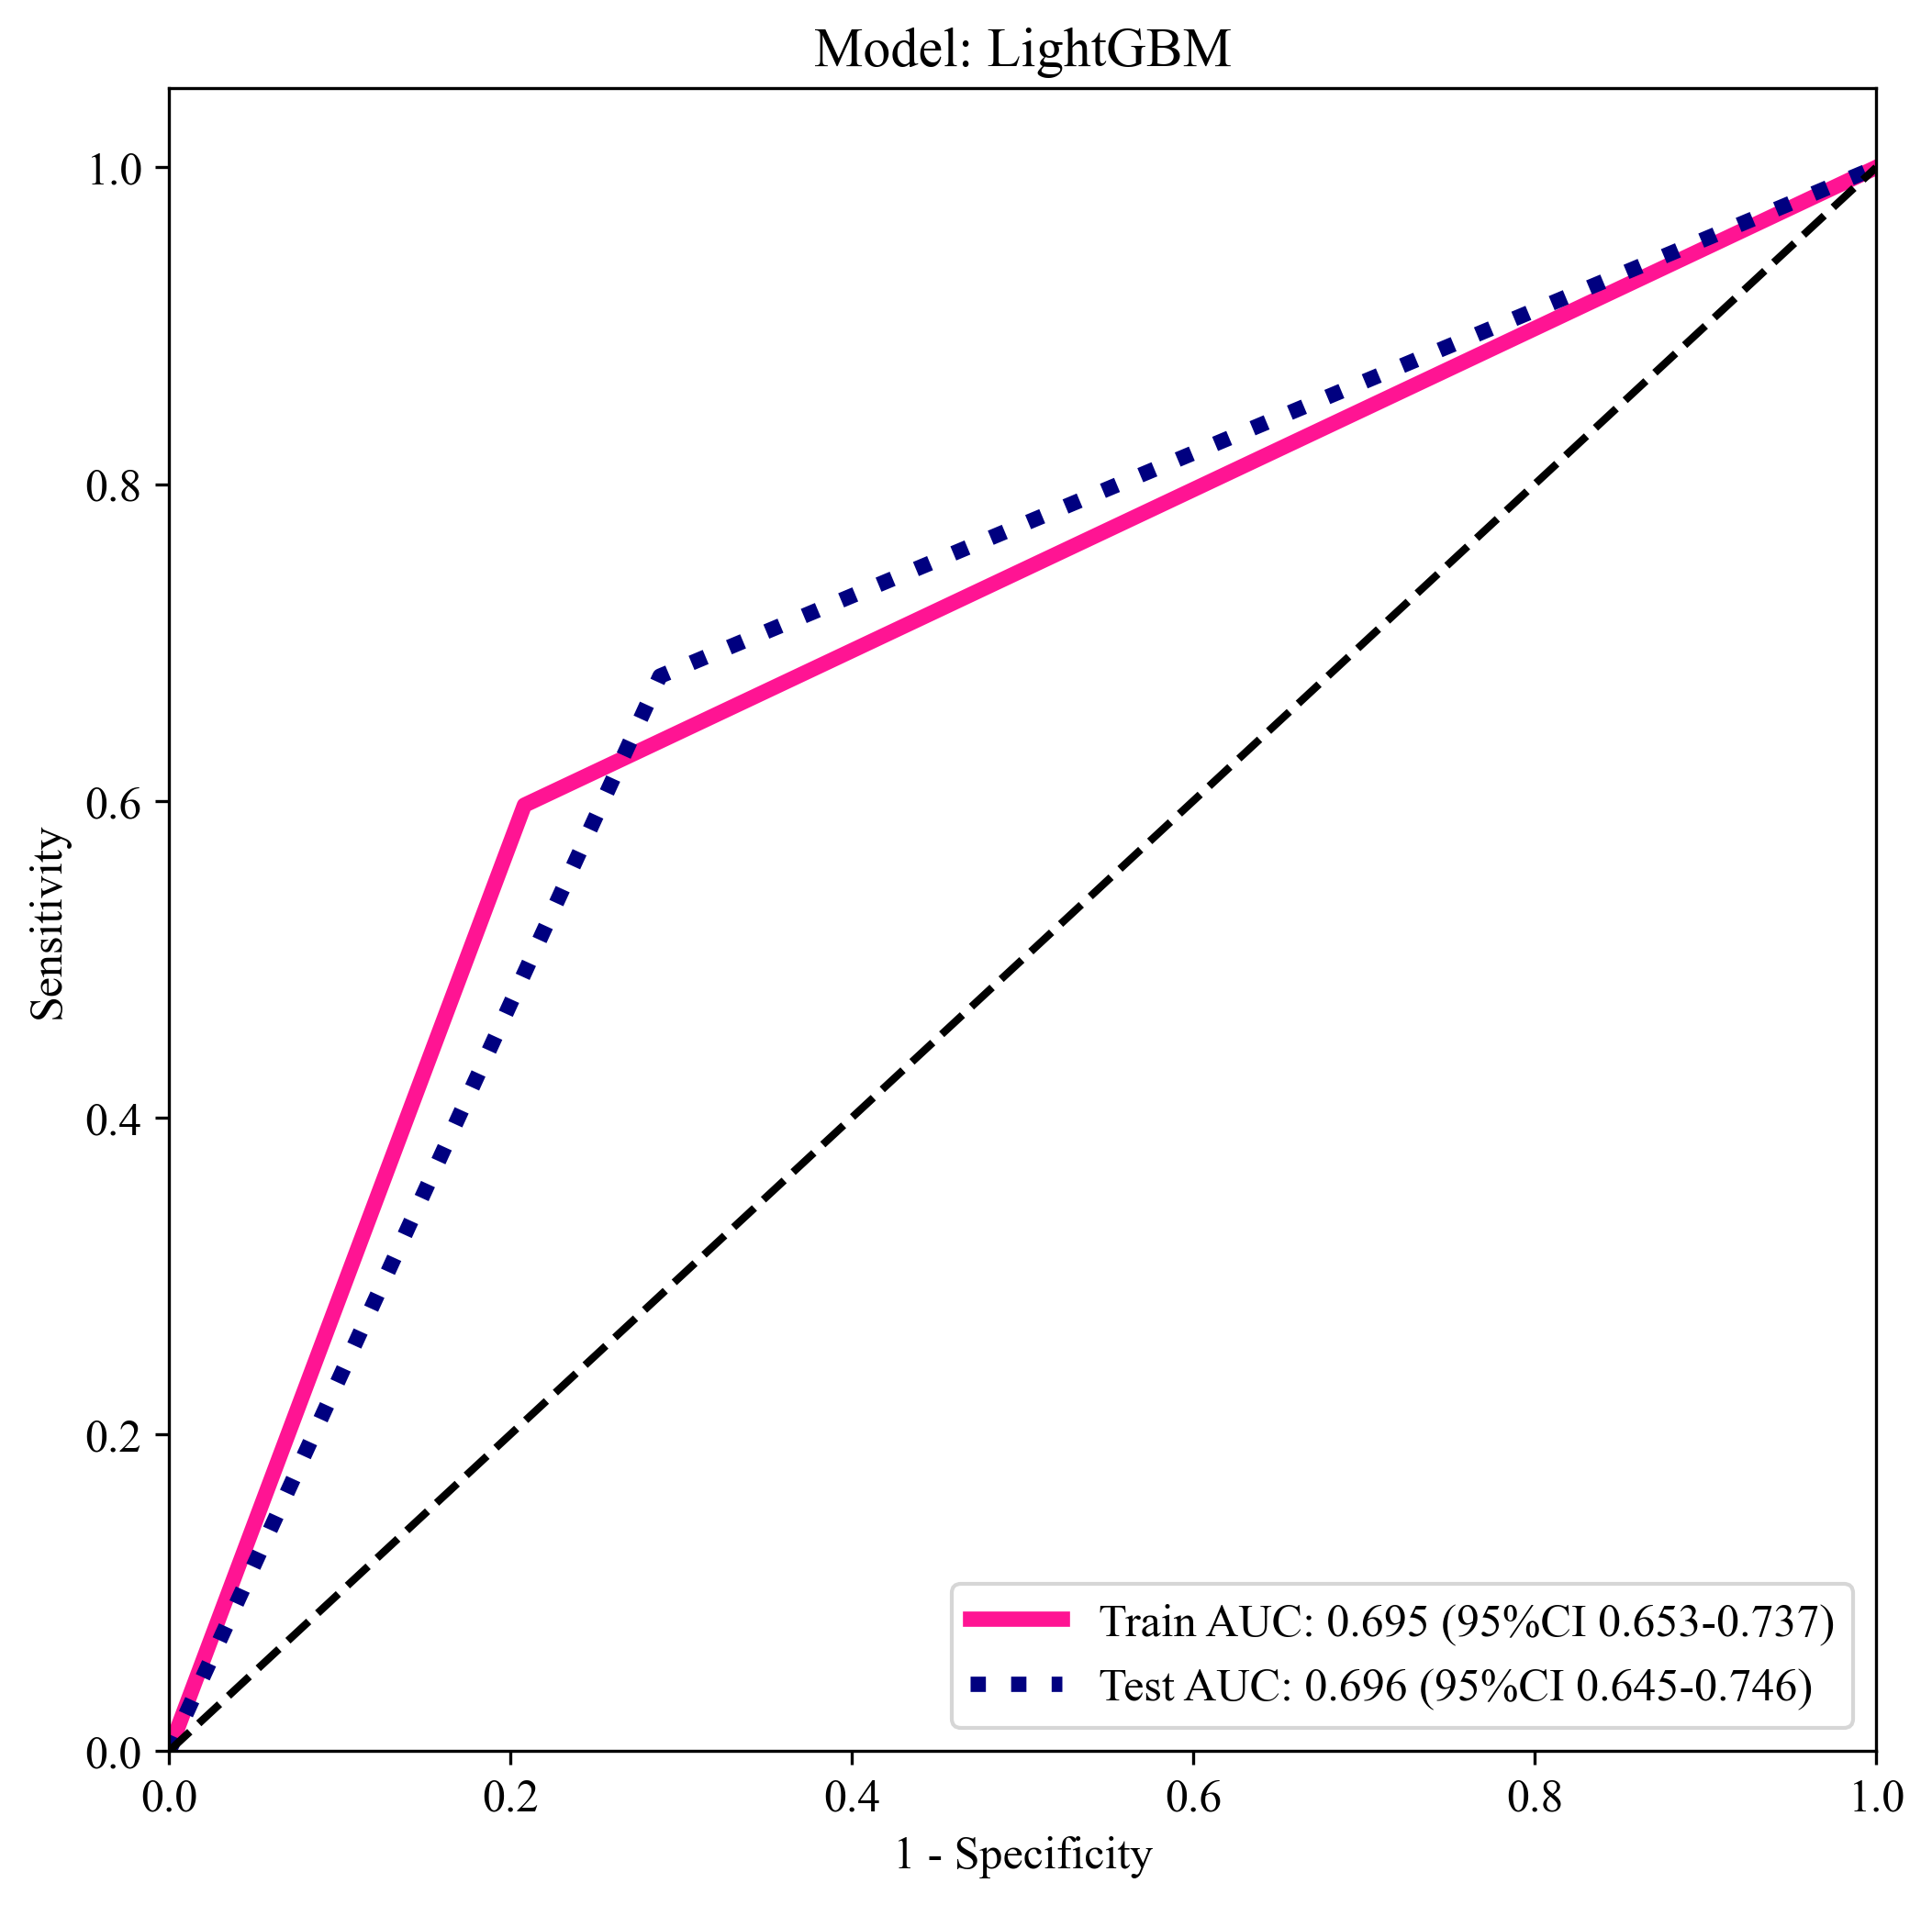

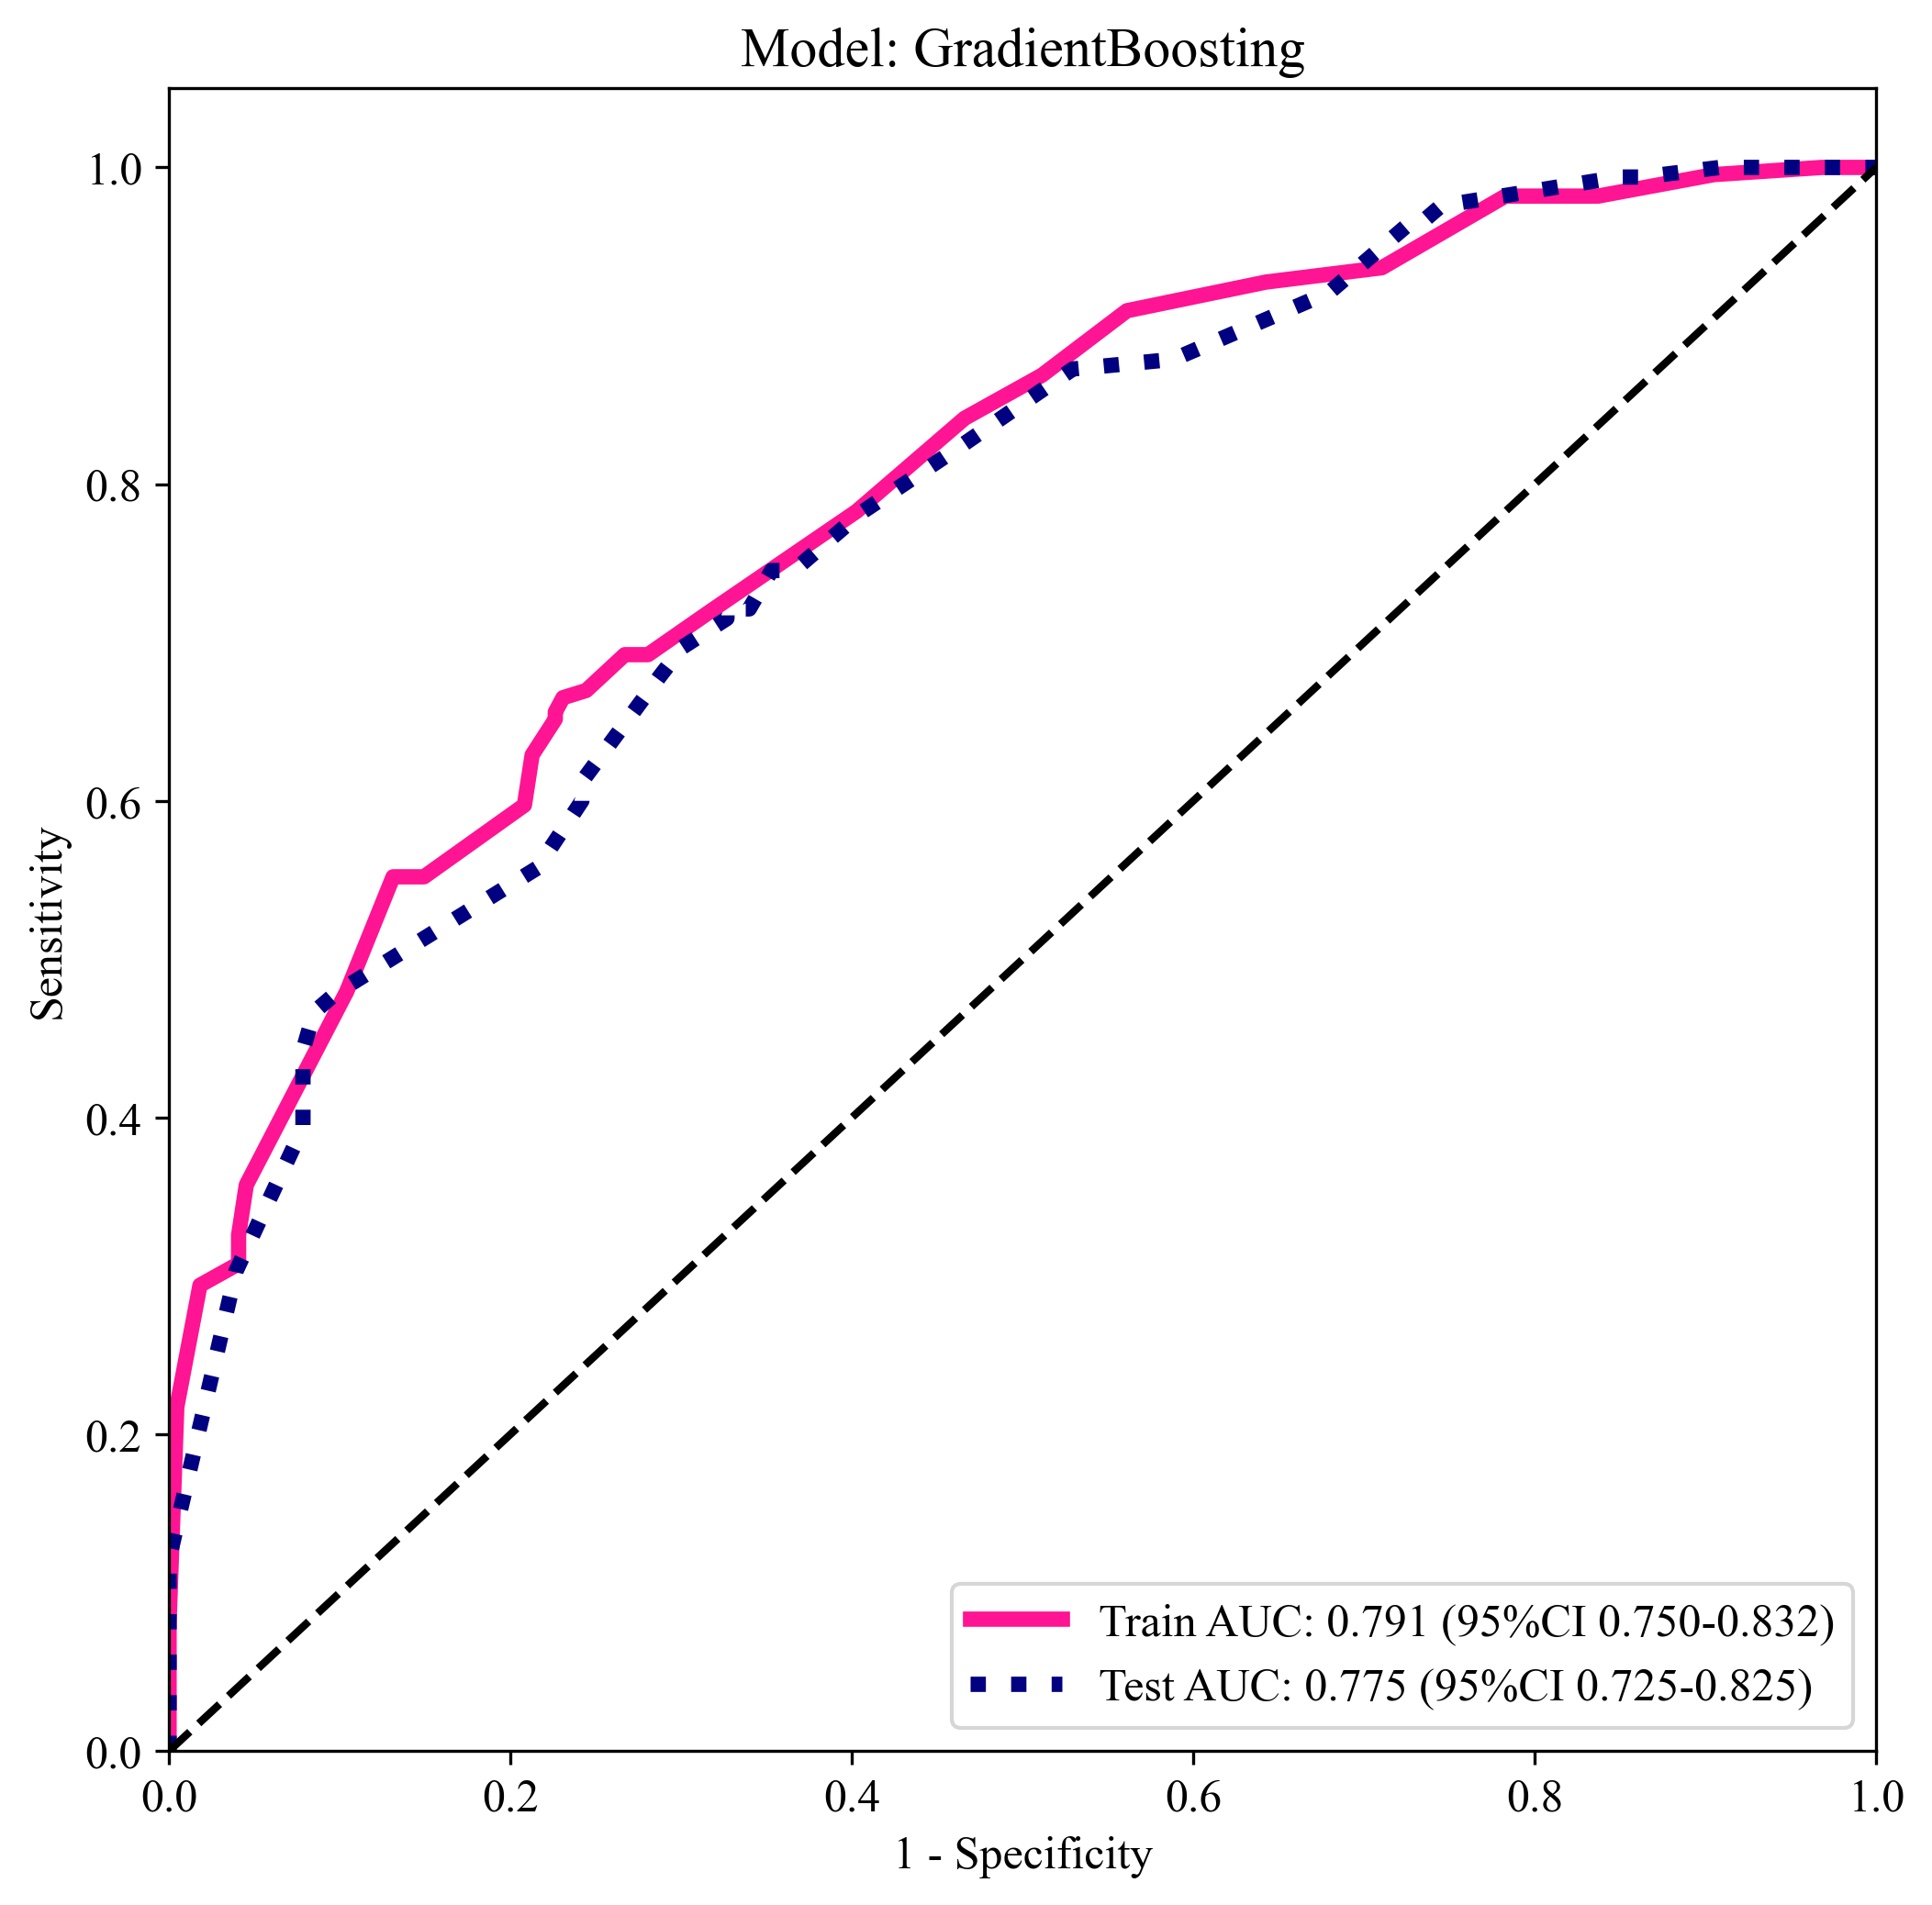

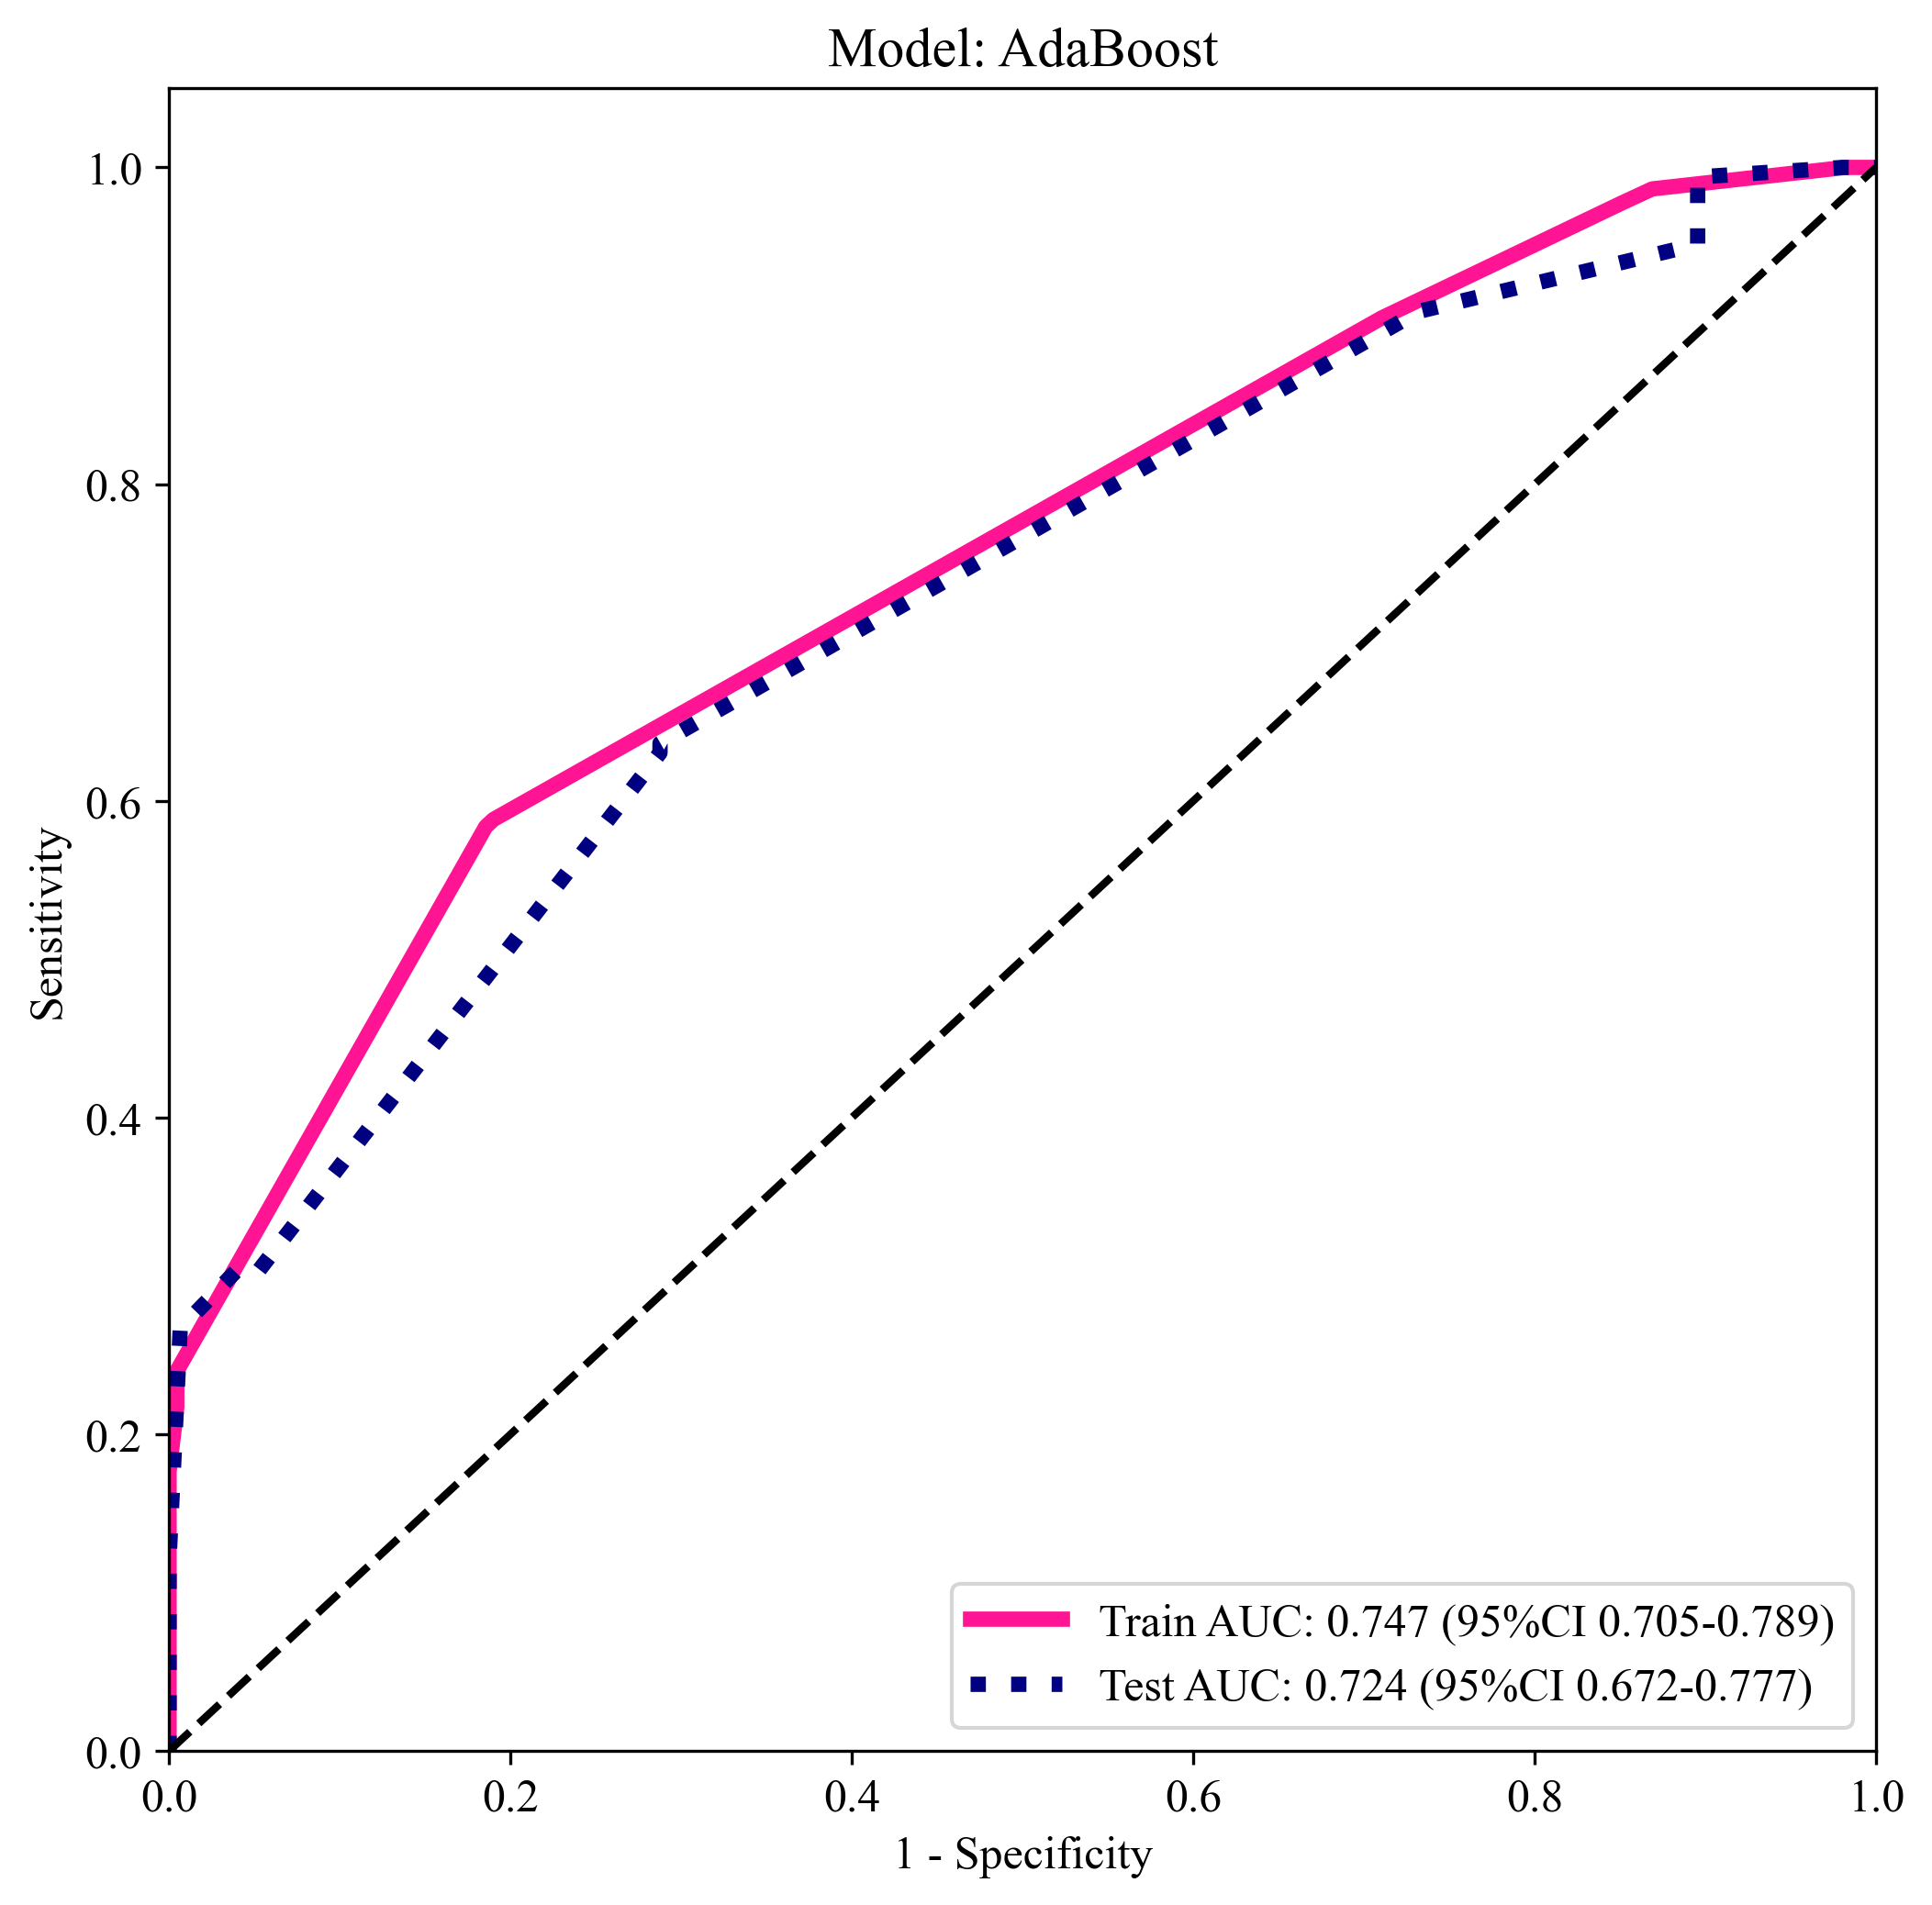

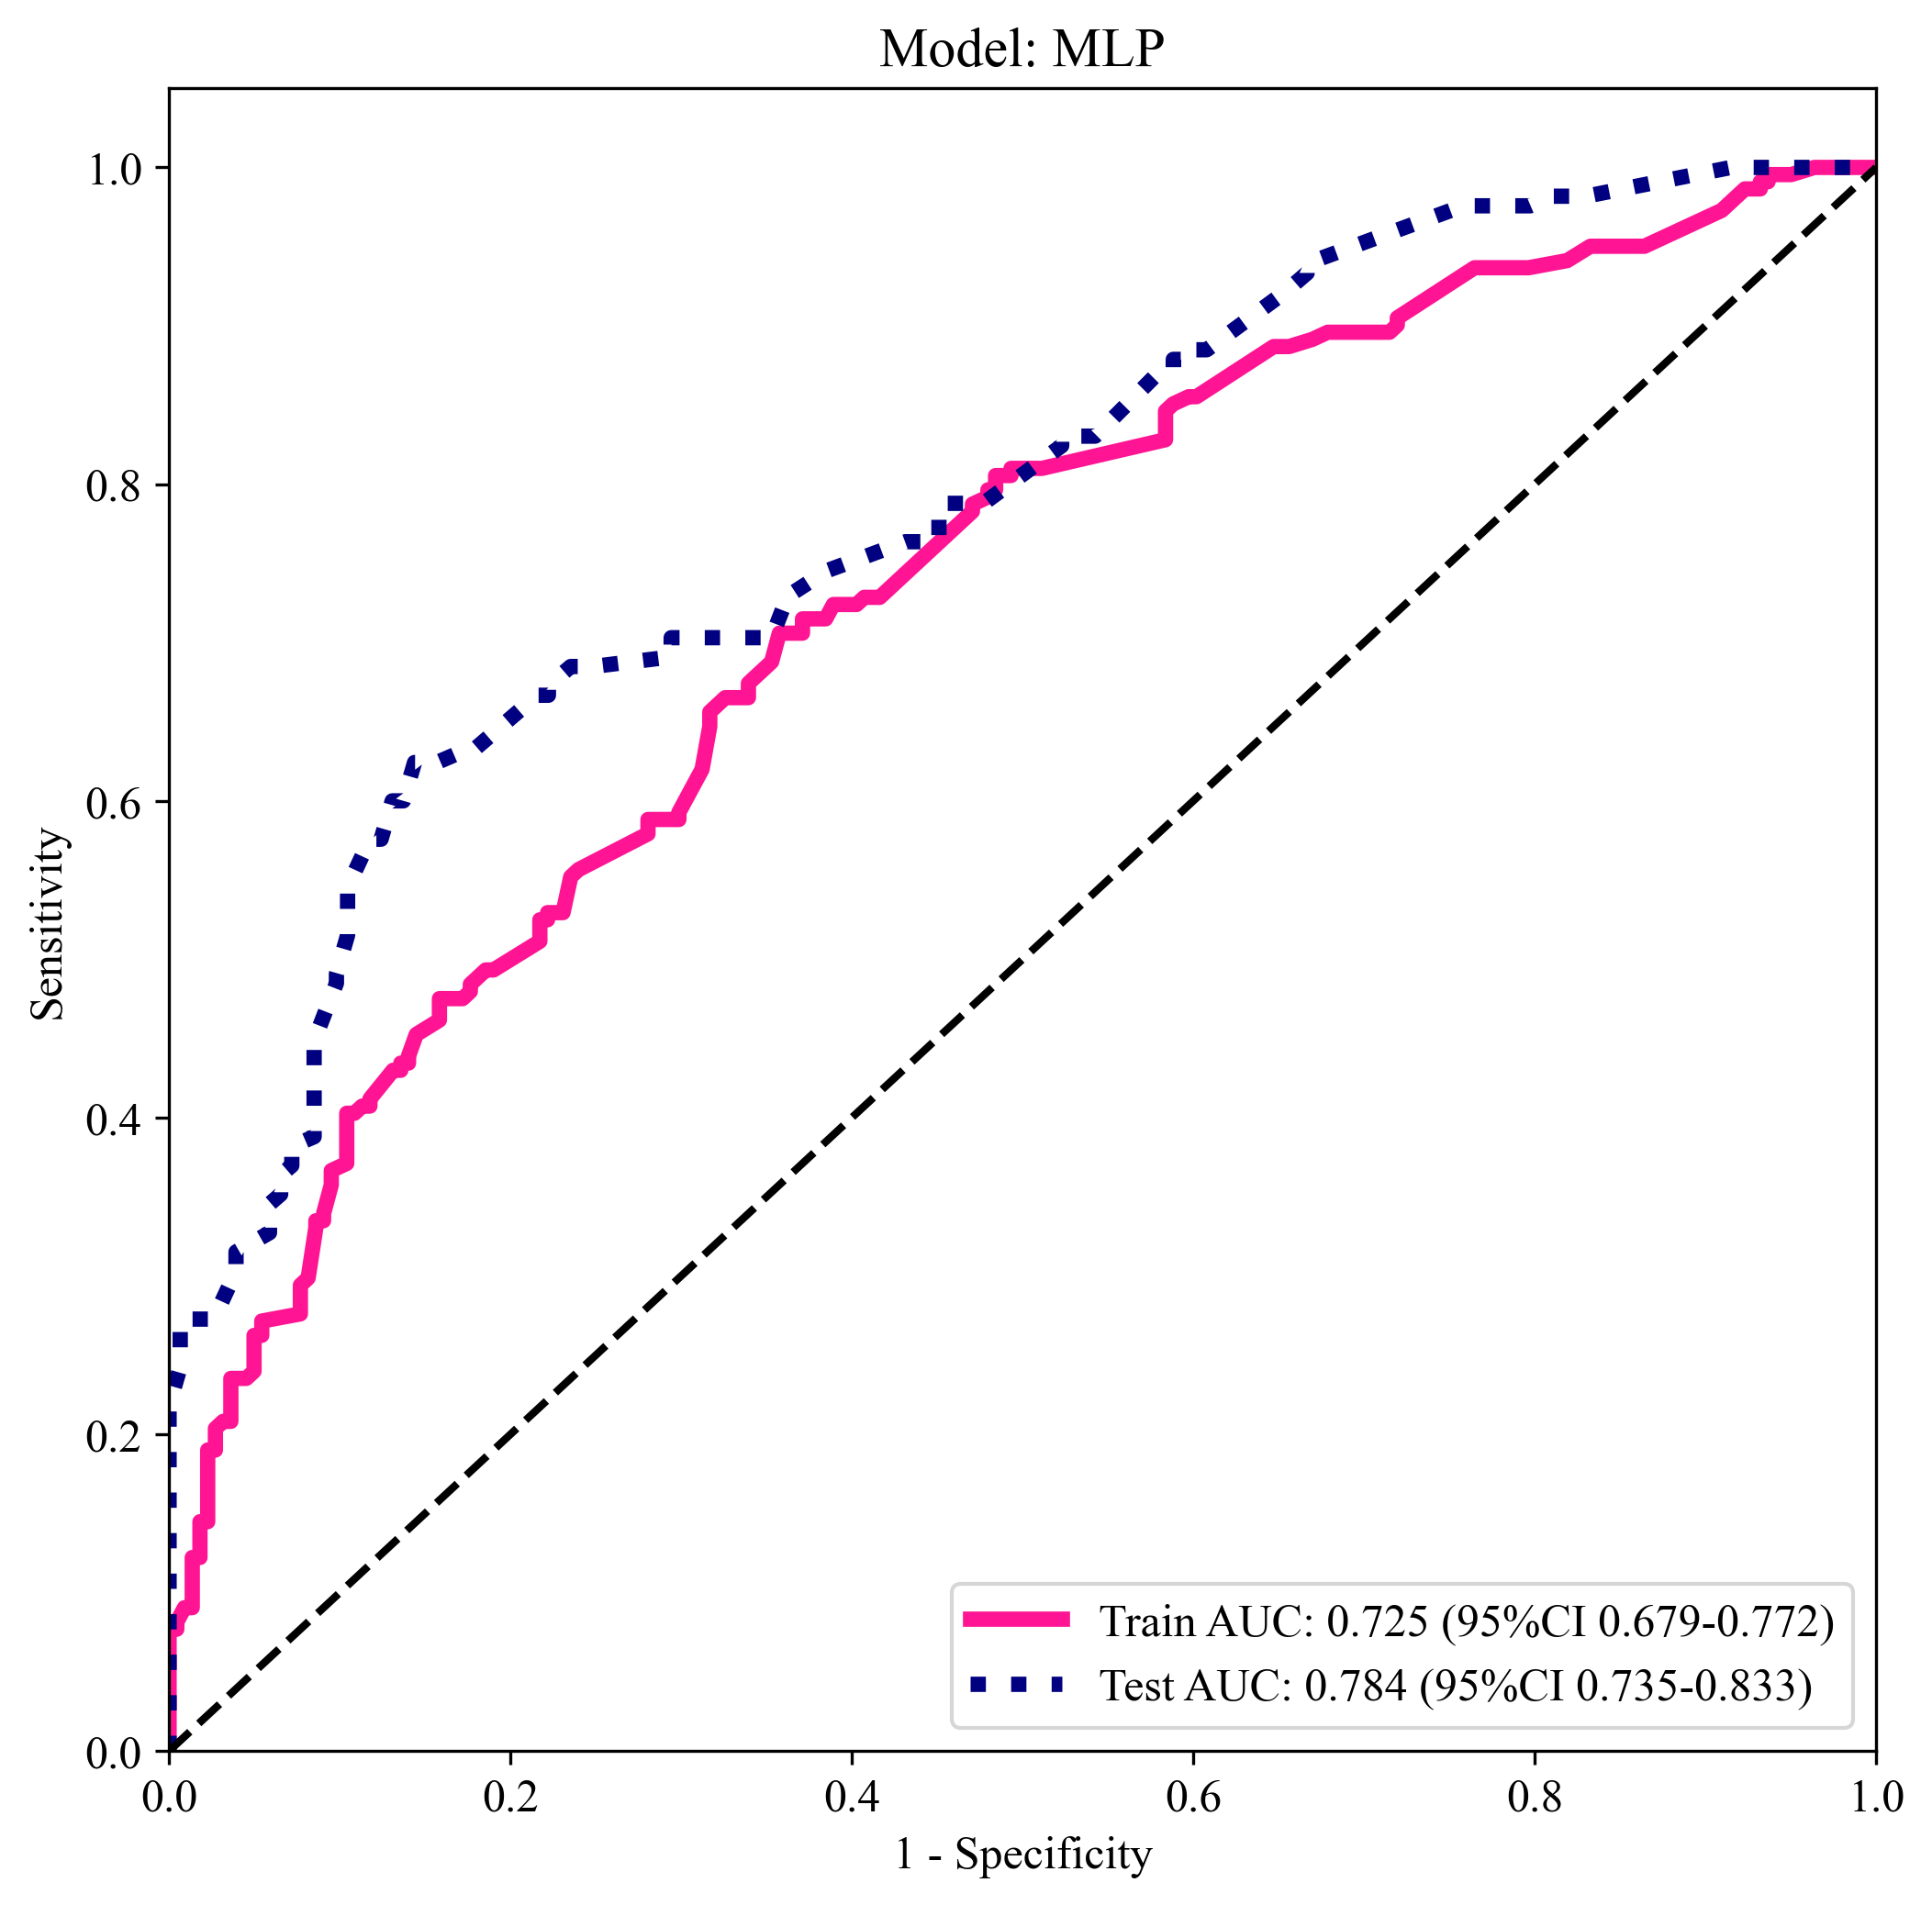

In [242]:
sel_model = model_names

for sm in sel_model:
    if sm in model_names:
        sel_model_idx = model_names.index(sm)
    
        # Plot all ROC curves
        plt.figure(figsize=(8, 8))
        for pred_score, label in zip(pred_scores, labels):
            okcomp.comp1.draw_roc([np.array(y_train_sel[label]), np.array(y_test_sel[label])], 
                                  pred_score[sel_model_idx], 
                                  labels=['Train', 'Test'], title=f"Model: {sm}")
            plt.savefig(f'img/Clinic_model_{sm}_roc_label.svg', bbox_inches = 'tight')

### 汇总所有模型

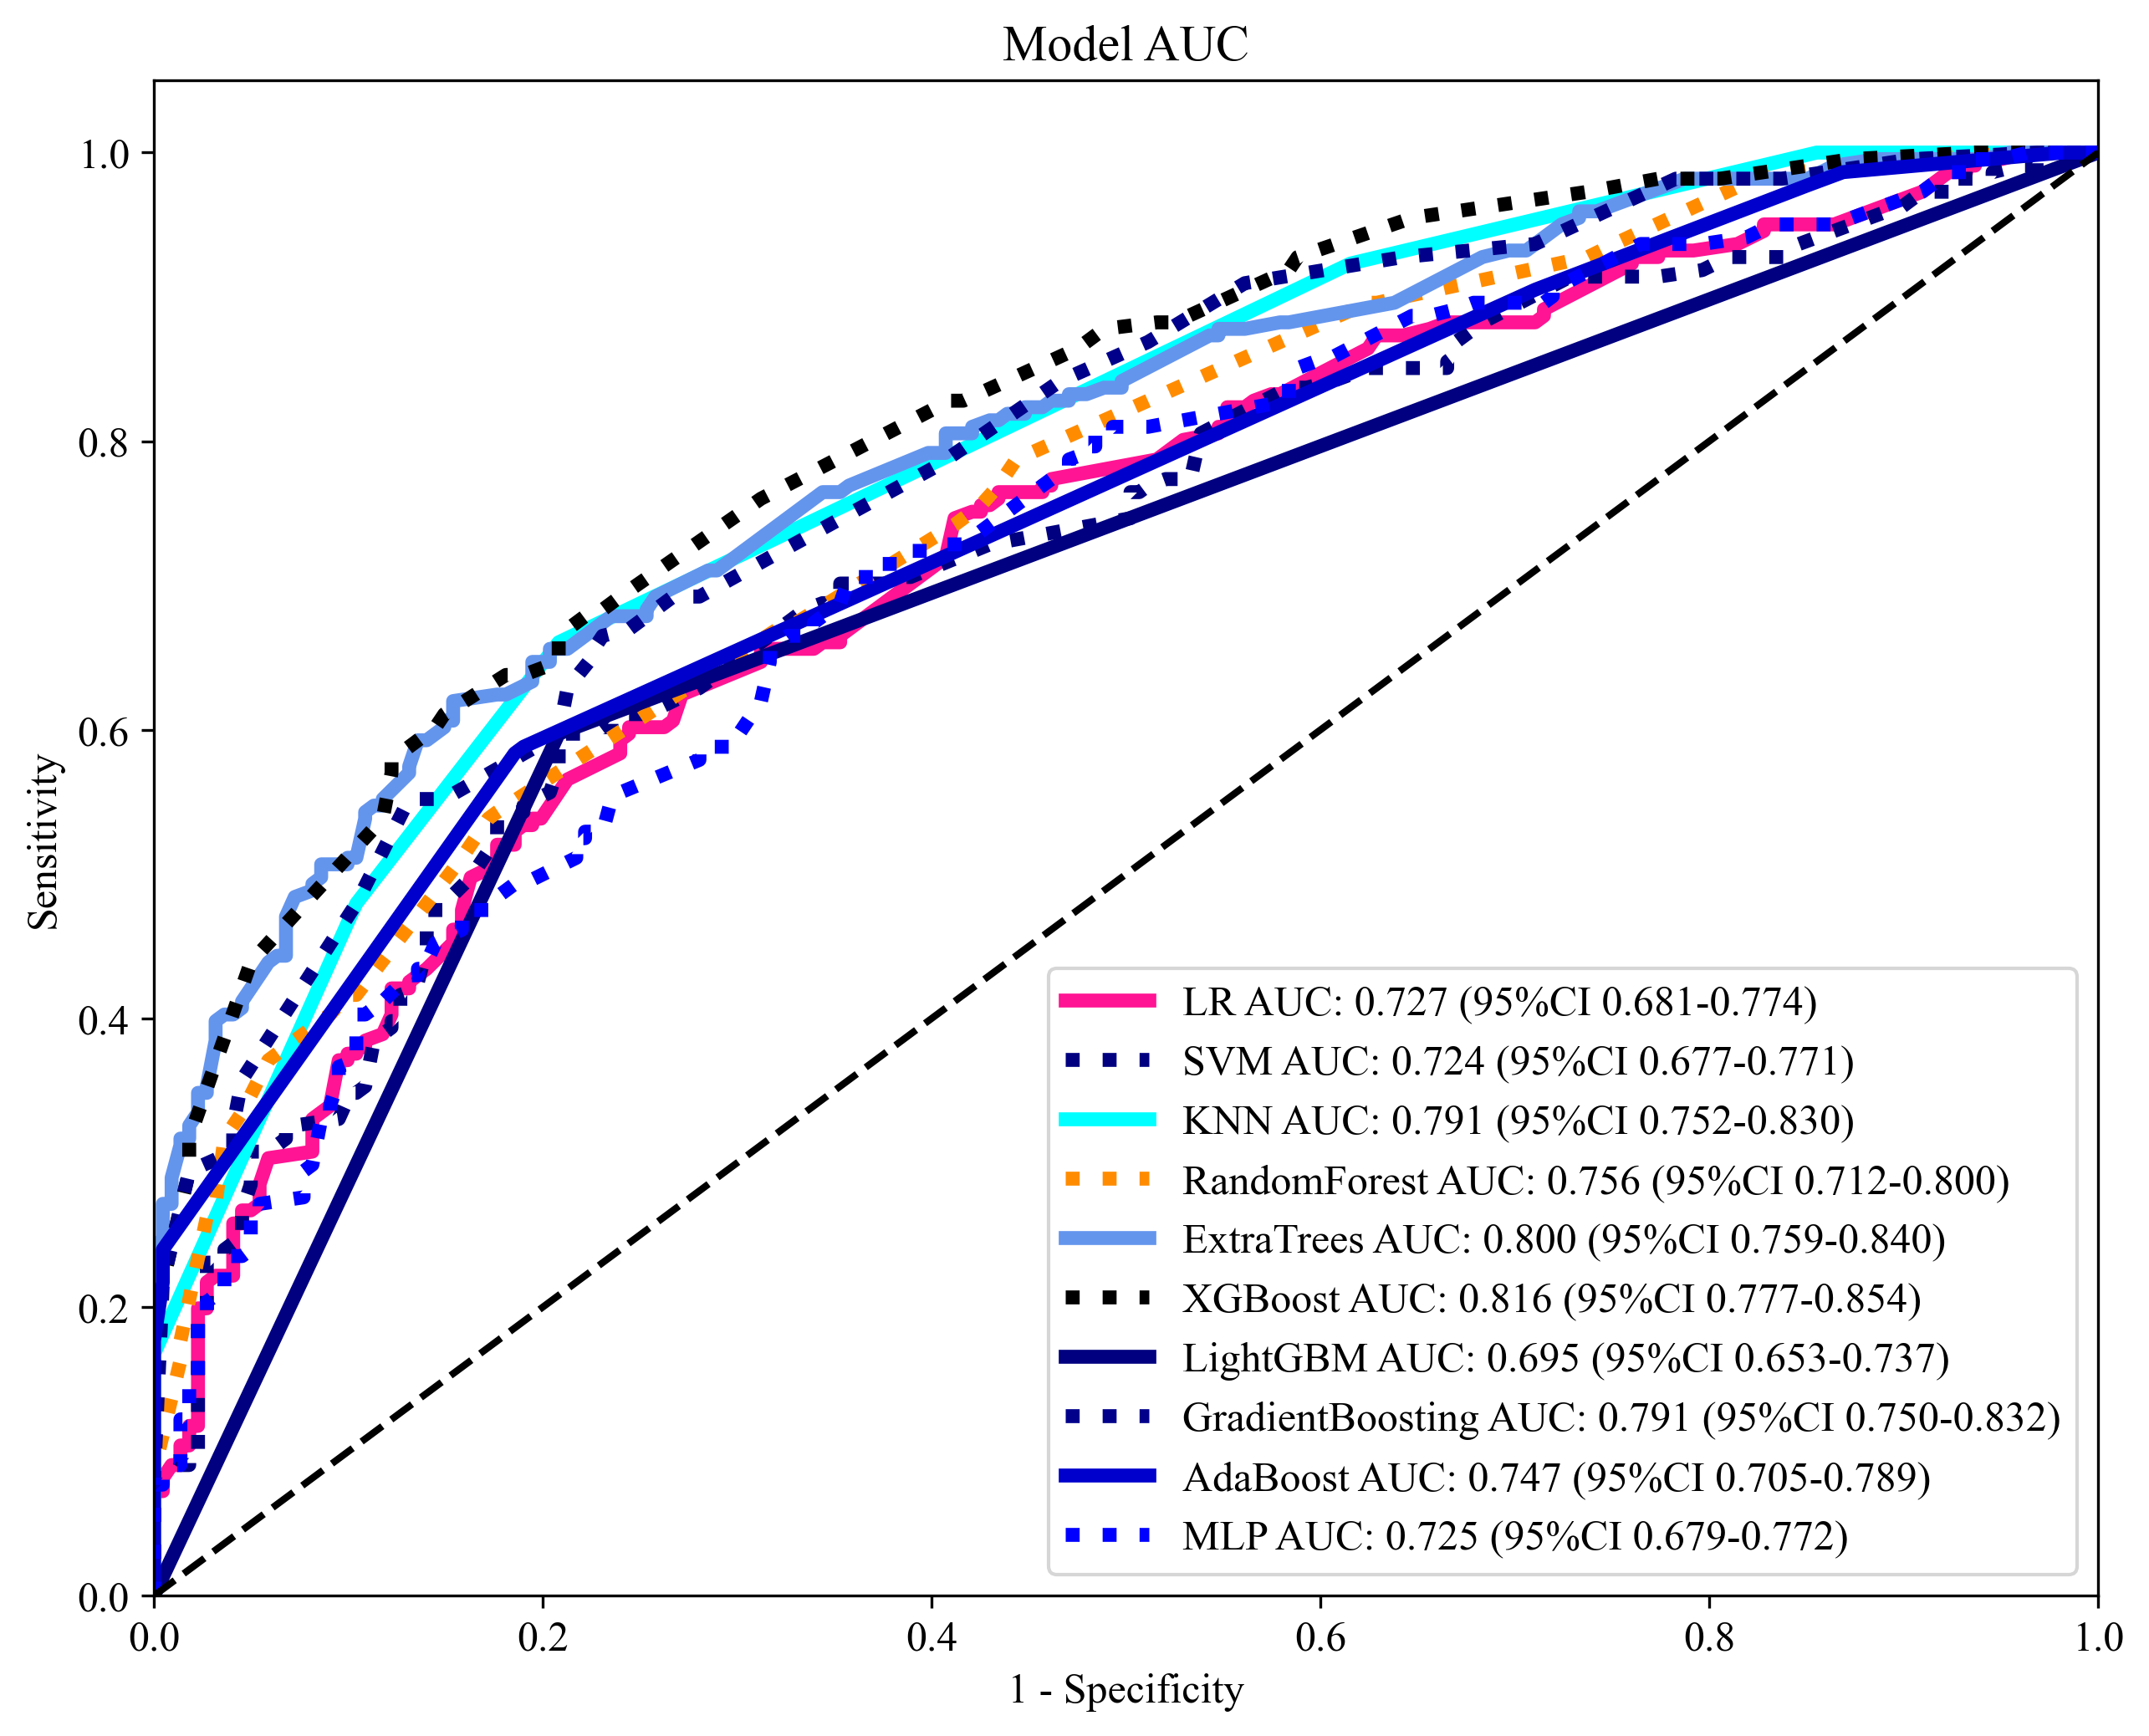

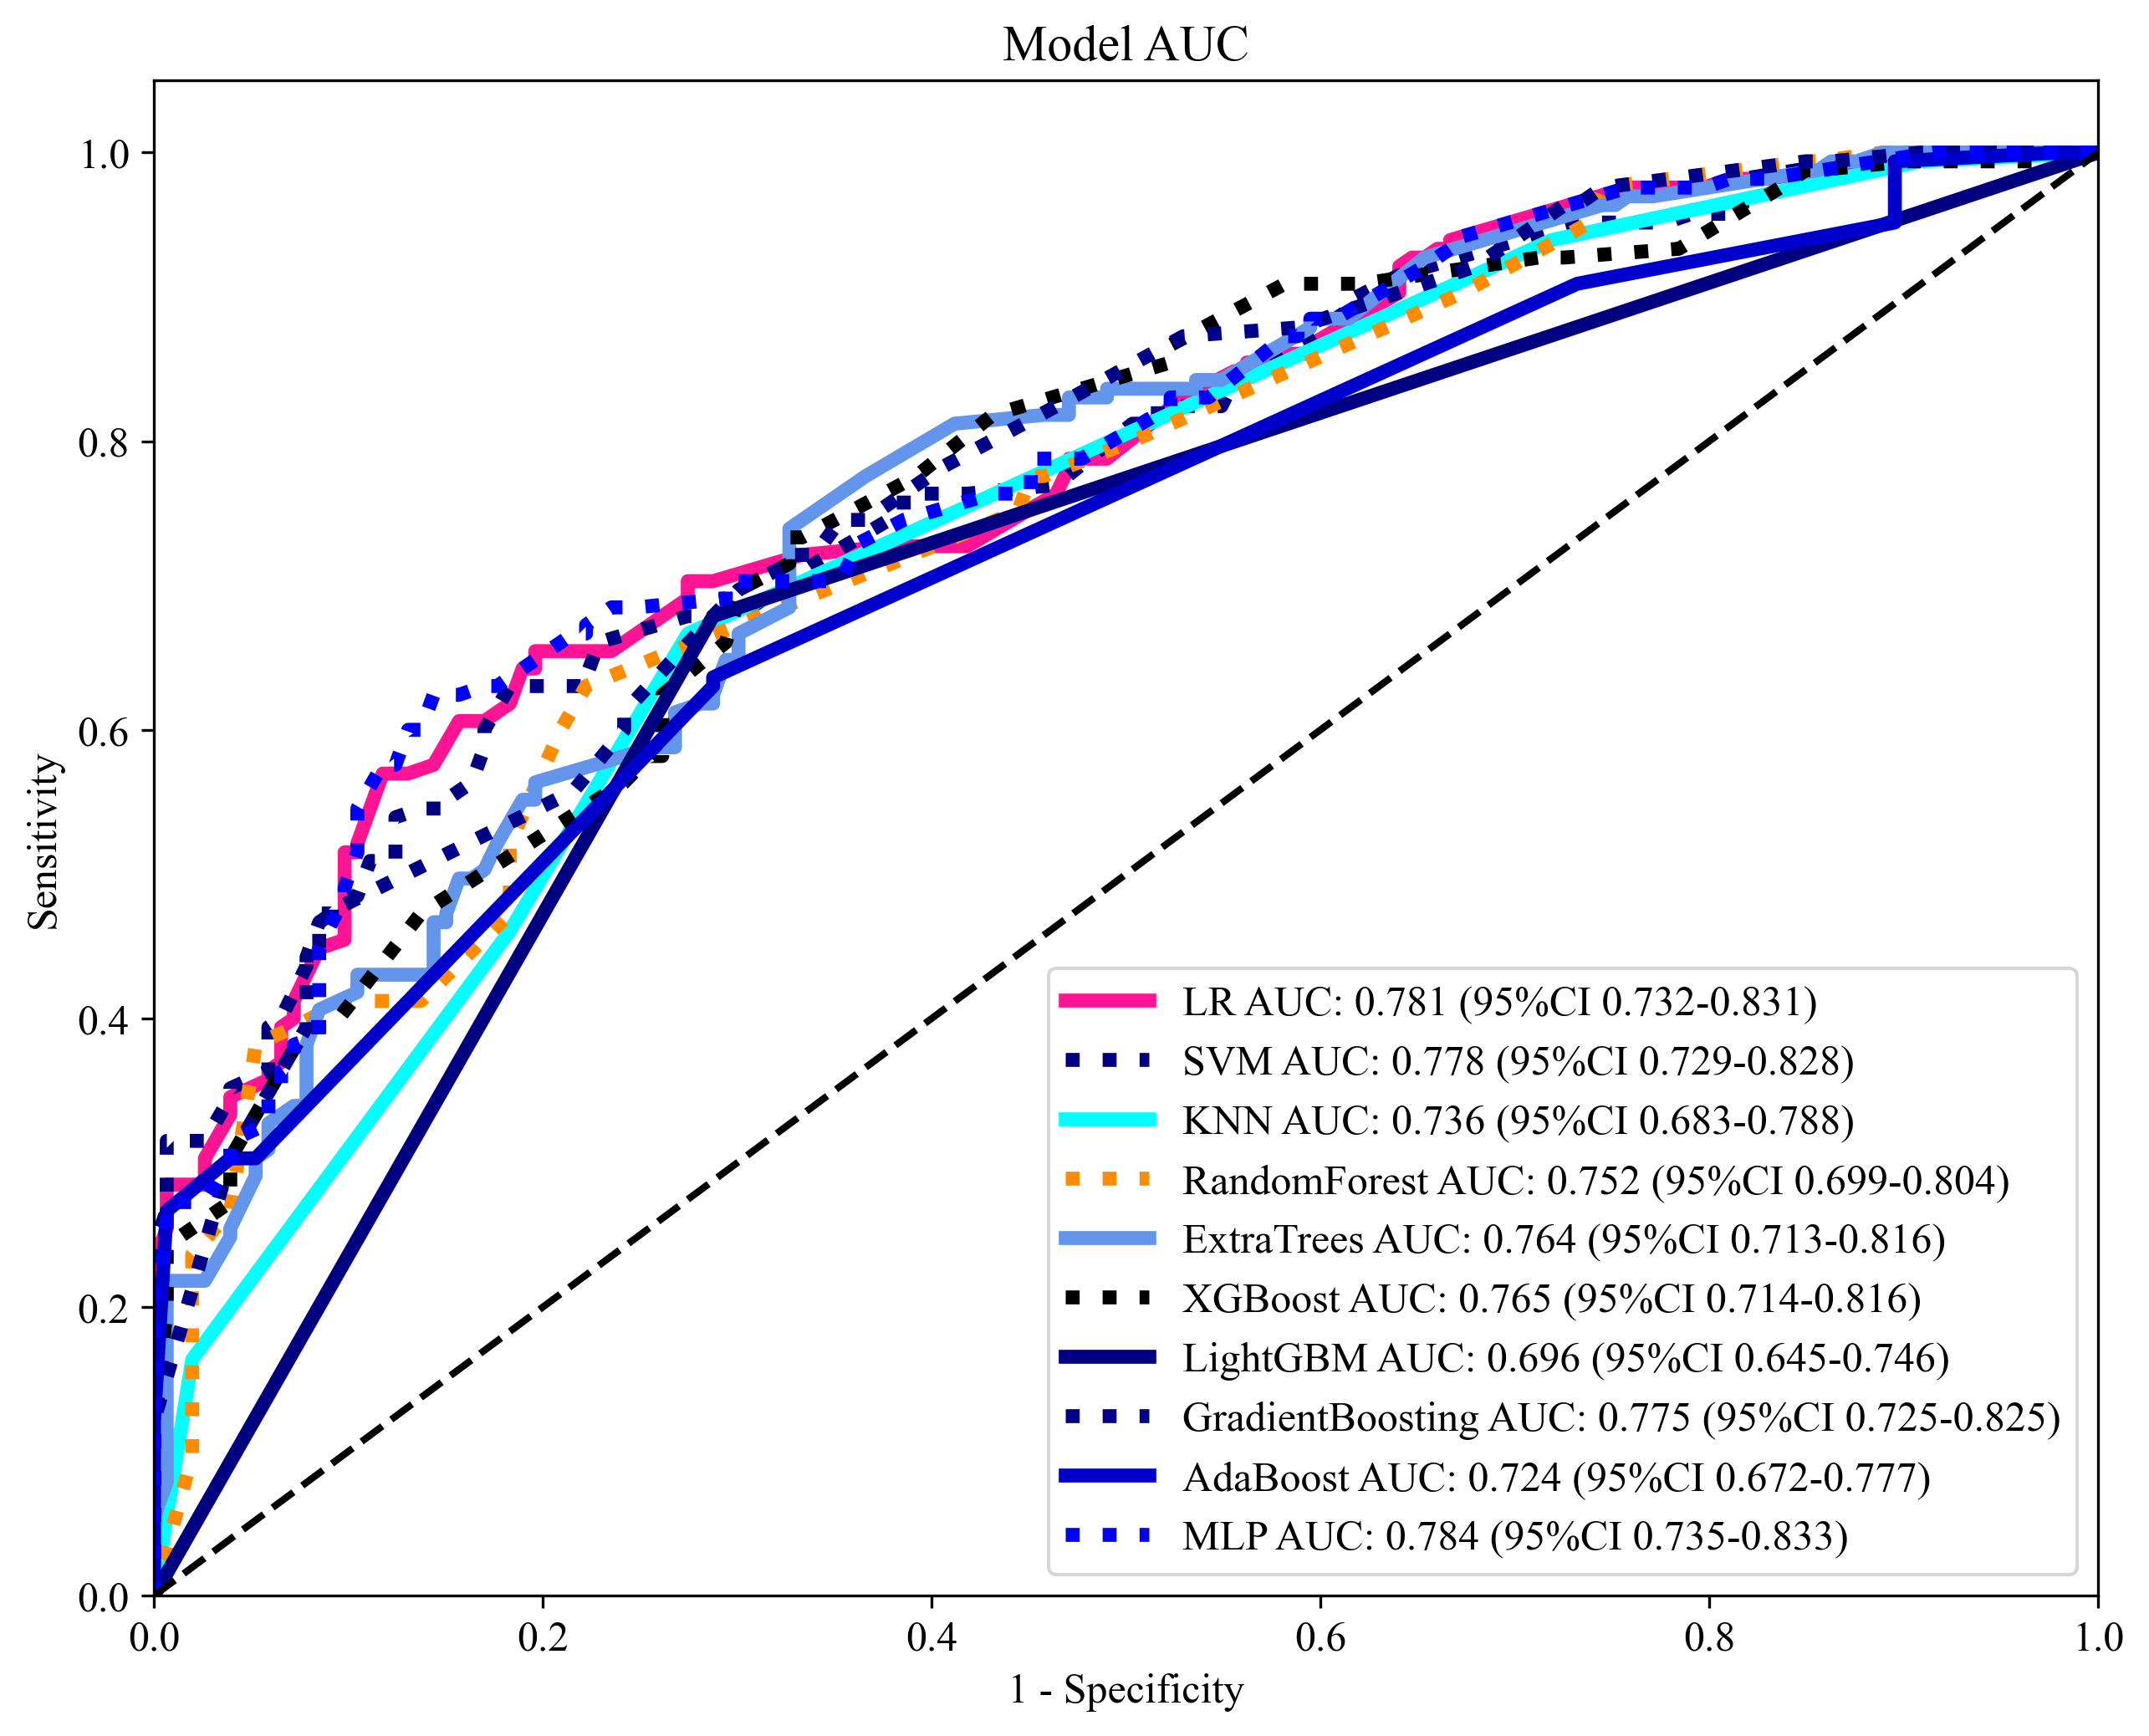

In [243]:
sel_model = model_names

for pred_score, label in zip(pred_scores, labels):
    pred_test_scores = []
    for sm in sel_model:
        if sm in model_names:
            sel_model_idx = model_names.index(sm)
            pred_test_scores.append(pred_score[sel_model_idx][0])
    okcomp.comp1.draw_roc([np.array(y_train_sel[label])] * len(pred_test_scores), 
                          pred_test_scores, 
                          labels=sel_model, title=f"Model AUC")
    plt.savefig(f'img/Clinic_model_roc_train.svg', bbox_inches = 'tight')
    plt.show()

for pred_score, label in zip(pred_scores, labels):
    pred_test_scores = []
    for sm in sel_model:
        if sm in model_names:
            sel_model_idx = model_names.index(sm)
            pred_test_scores.append(pred_score[sel_model_idx][1])
    okcomp.comp1.draw_roc([np.array(y_test_sel[label])] * len(pred_test_scores), 
                          pred_test_scores, 
                          labels=sel_model, title=f"Model AUC")
    plt.savefig(f'img/Clinic_model_roc_test.svg', bbox_inches = 'tight')

### DCA决策曲线

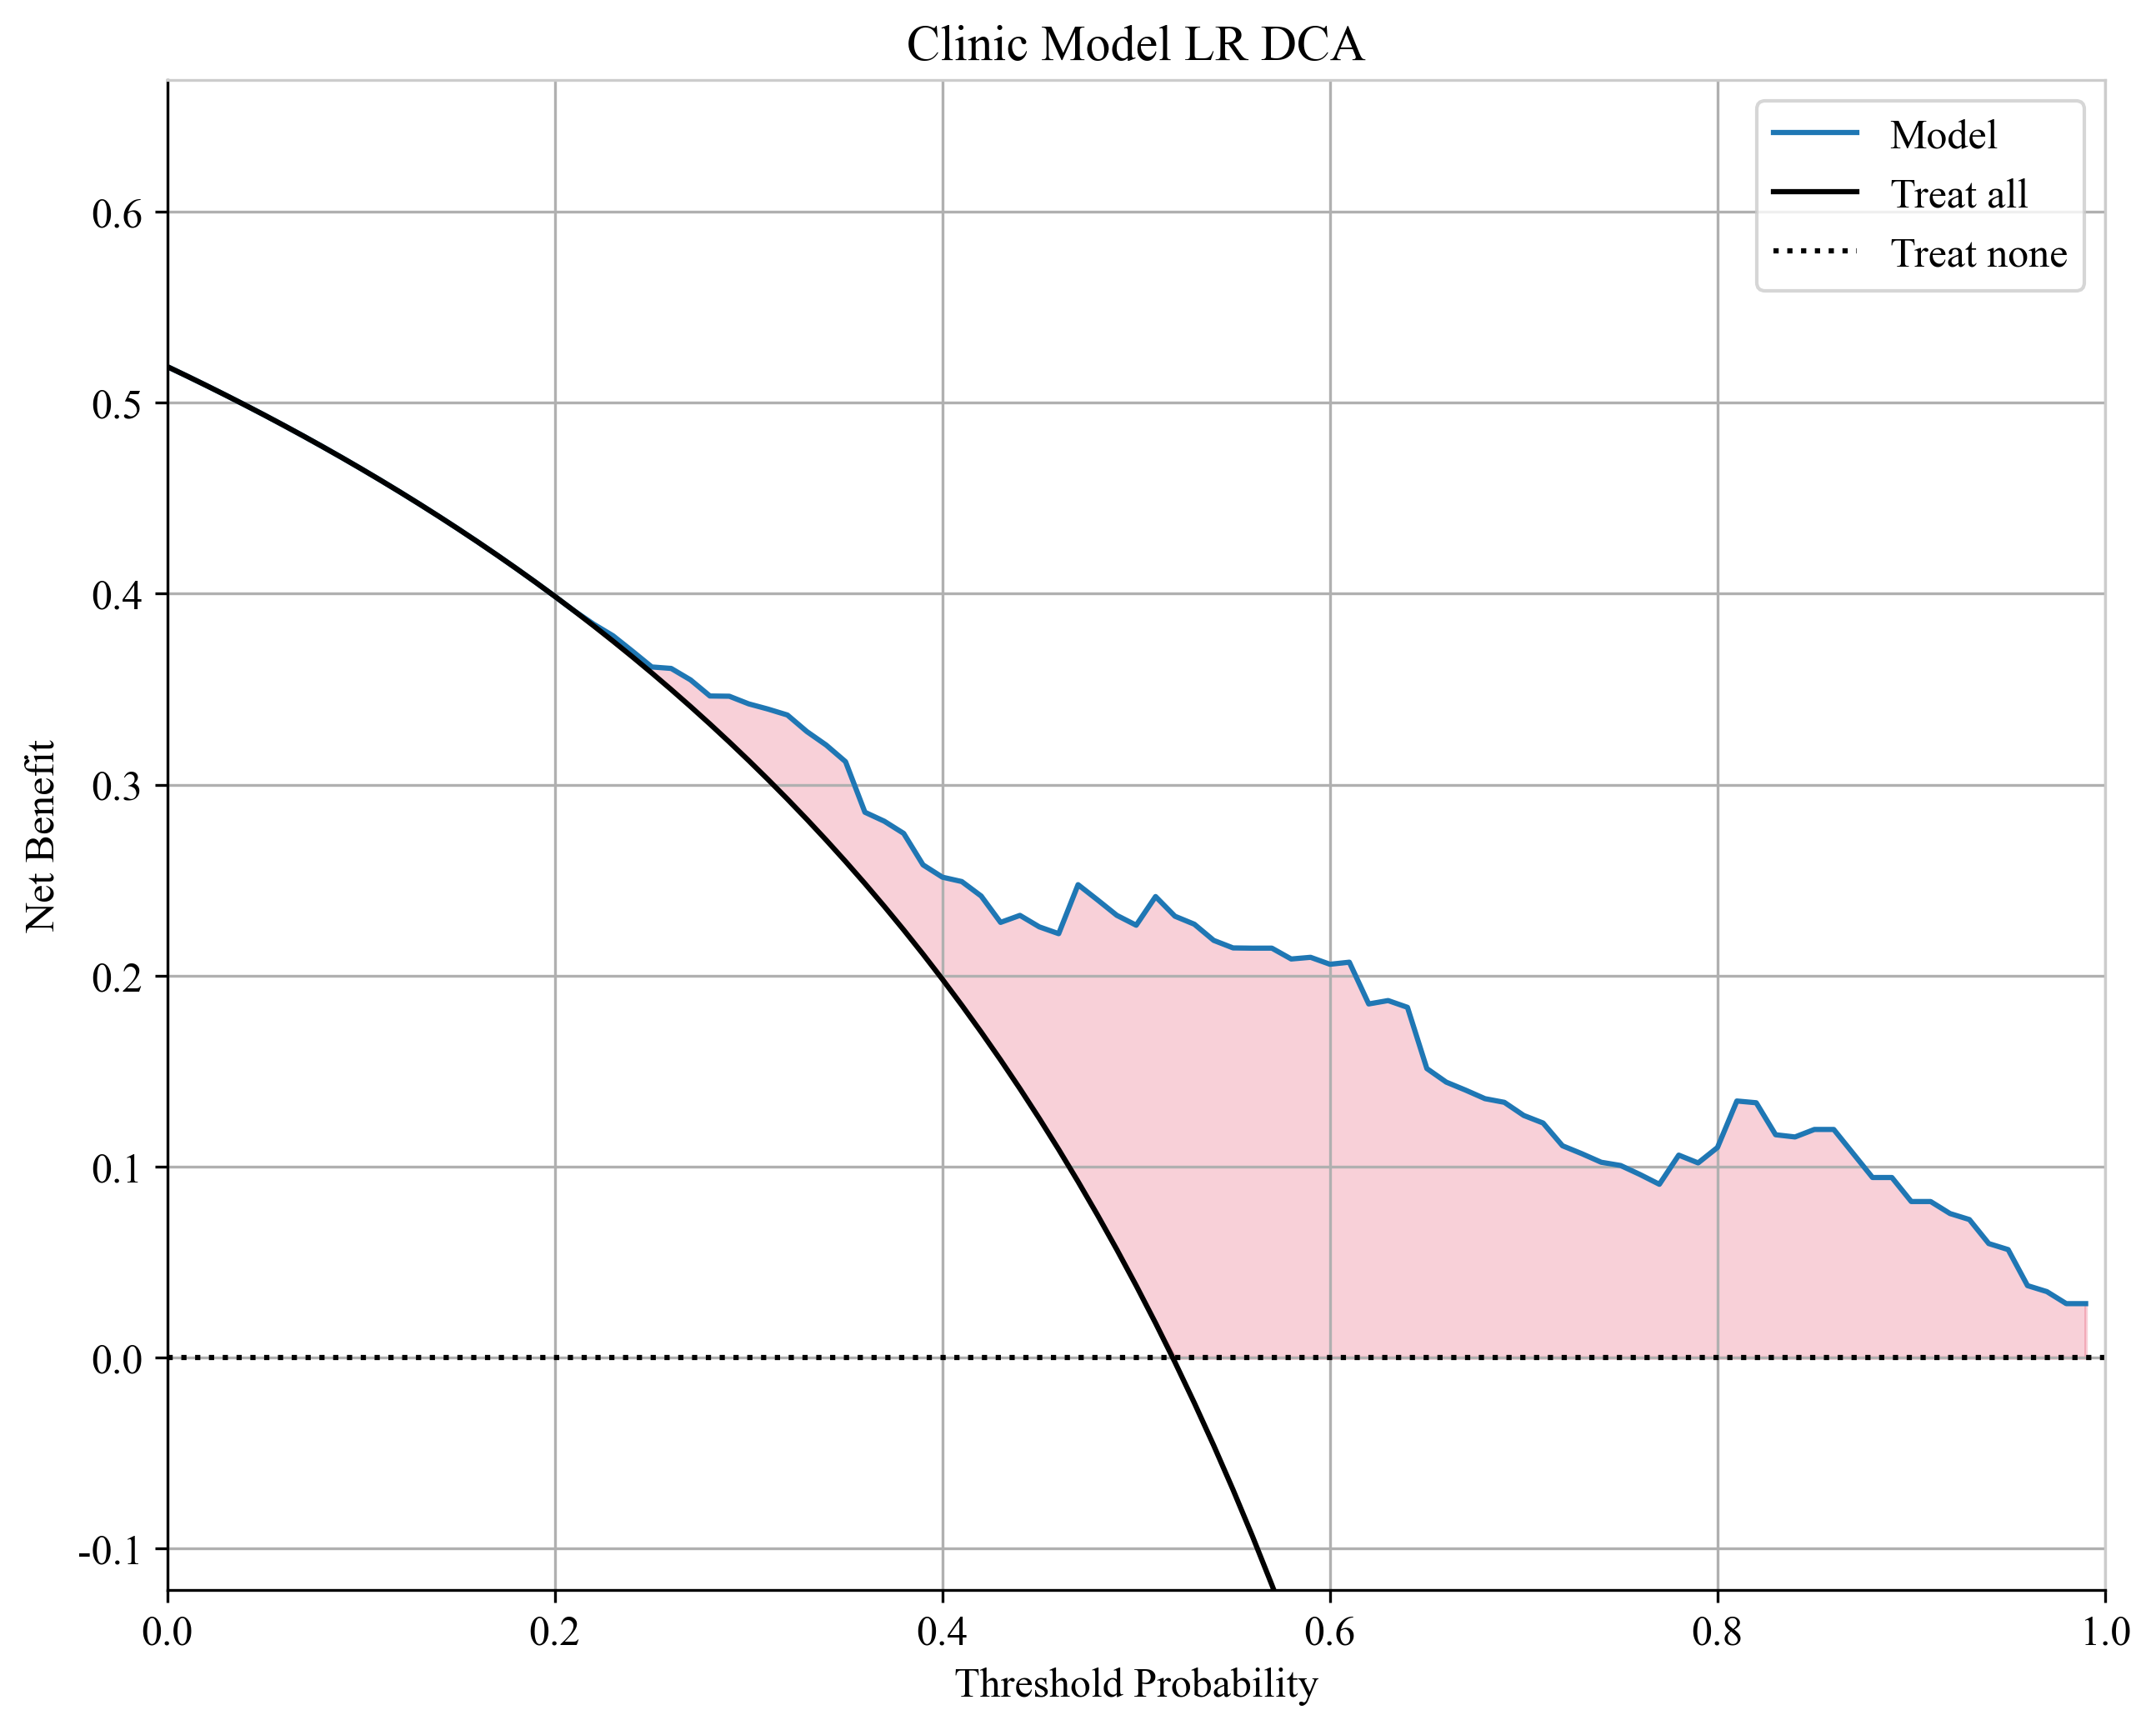

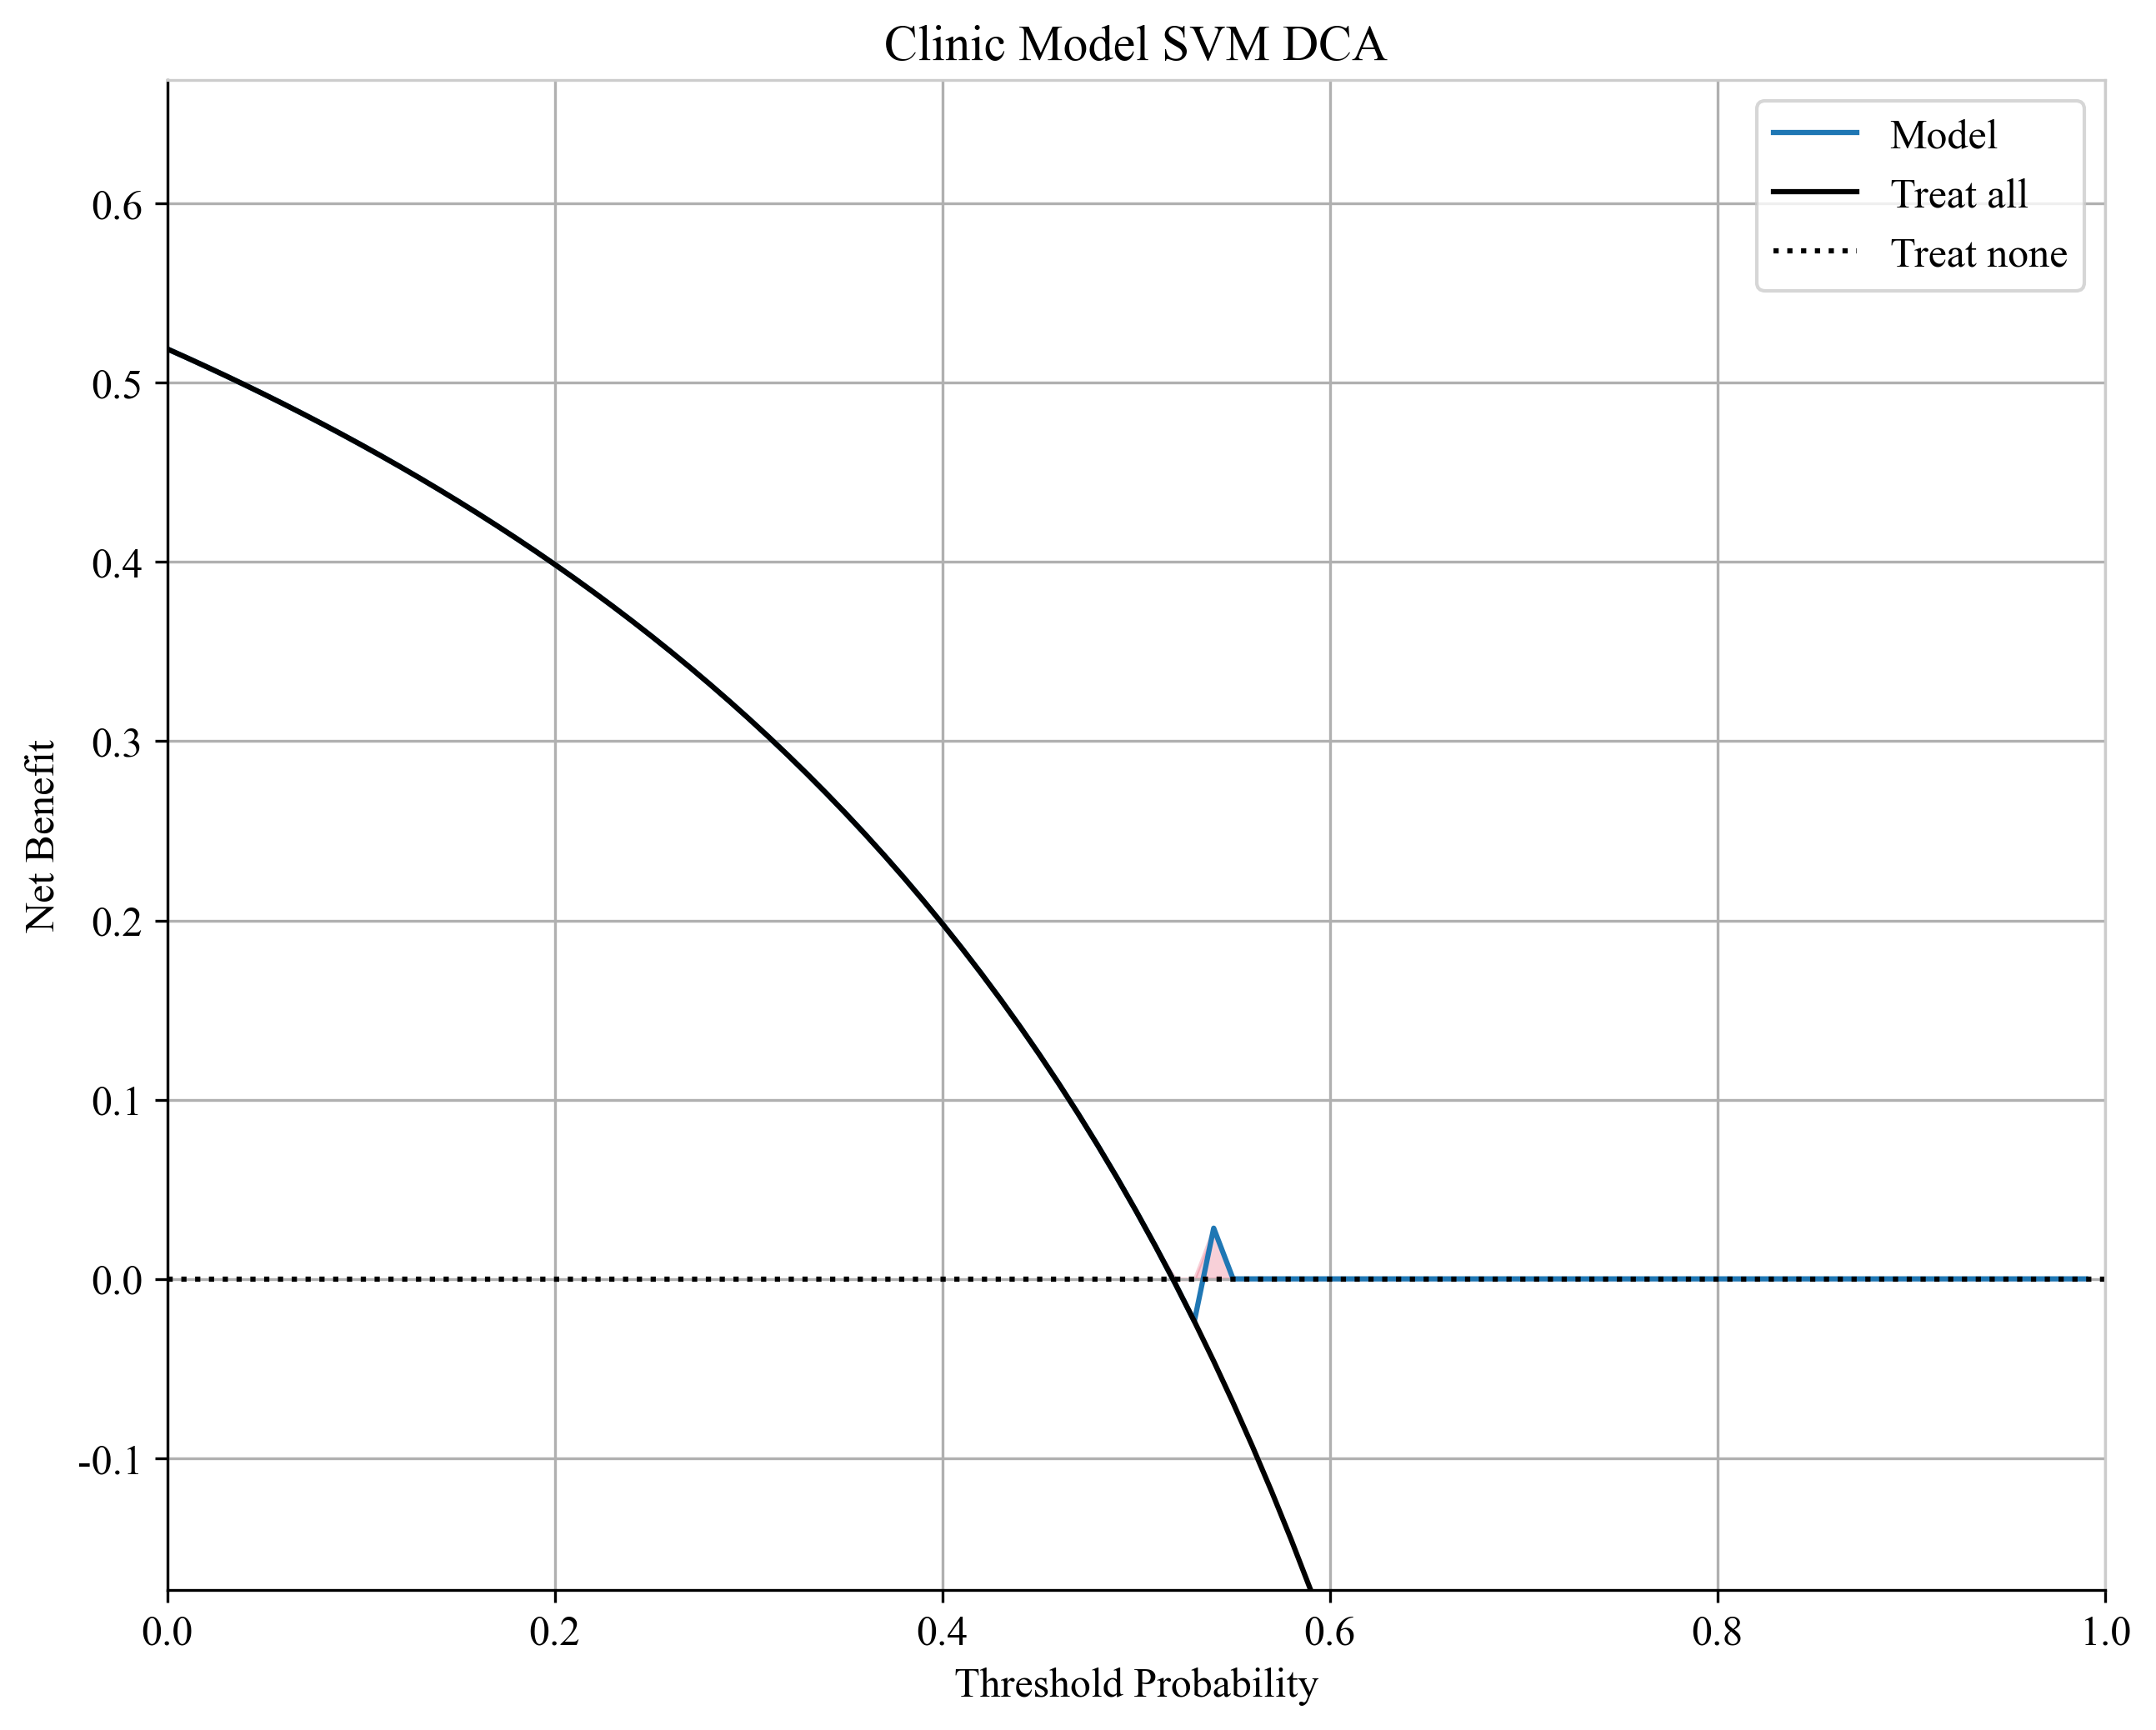

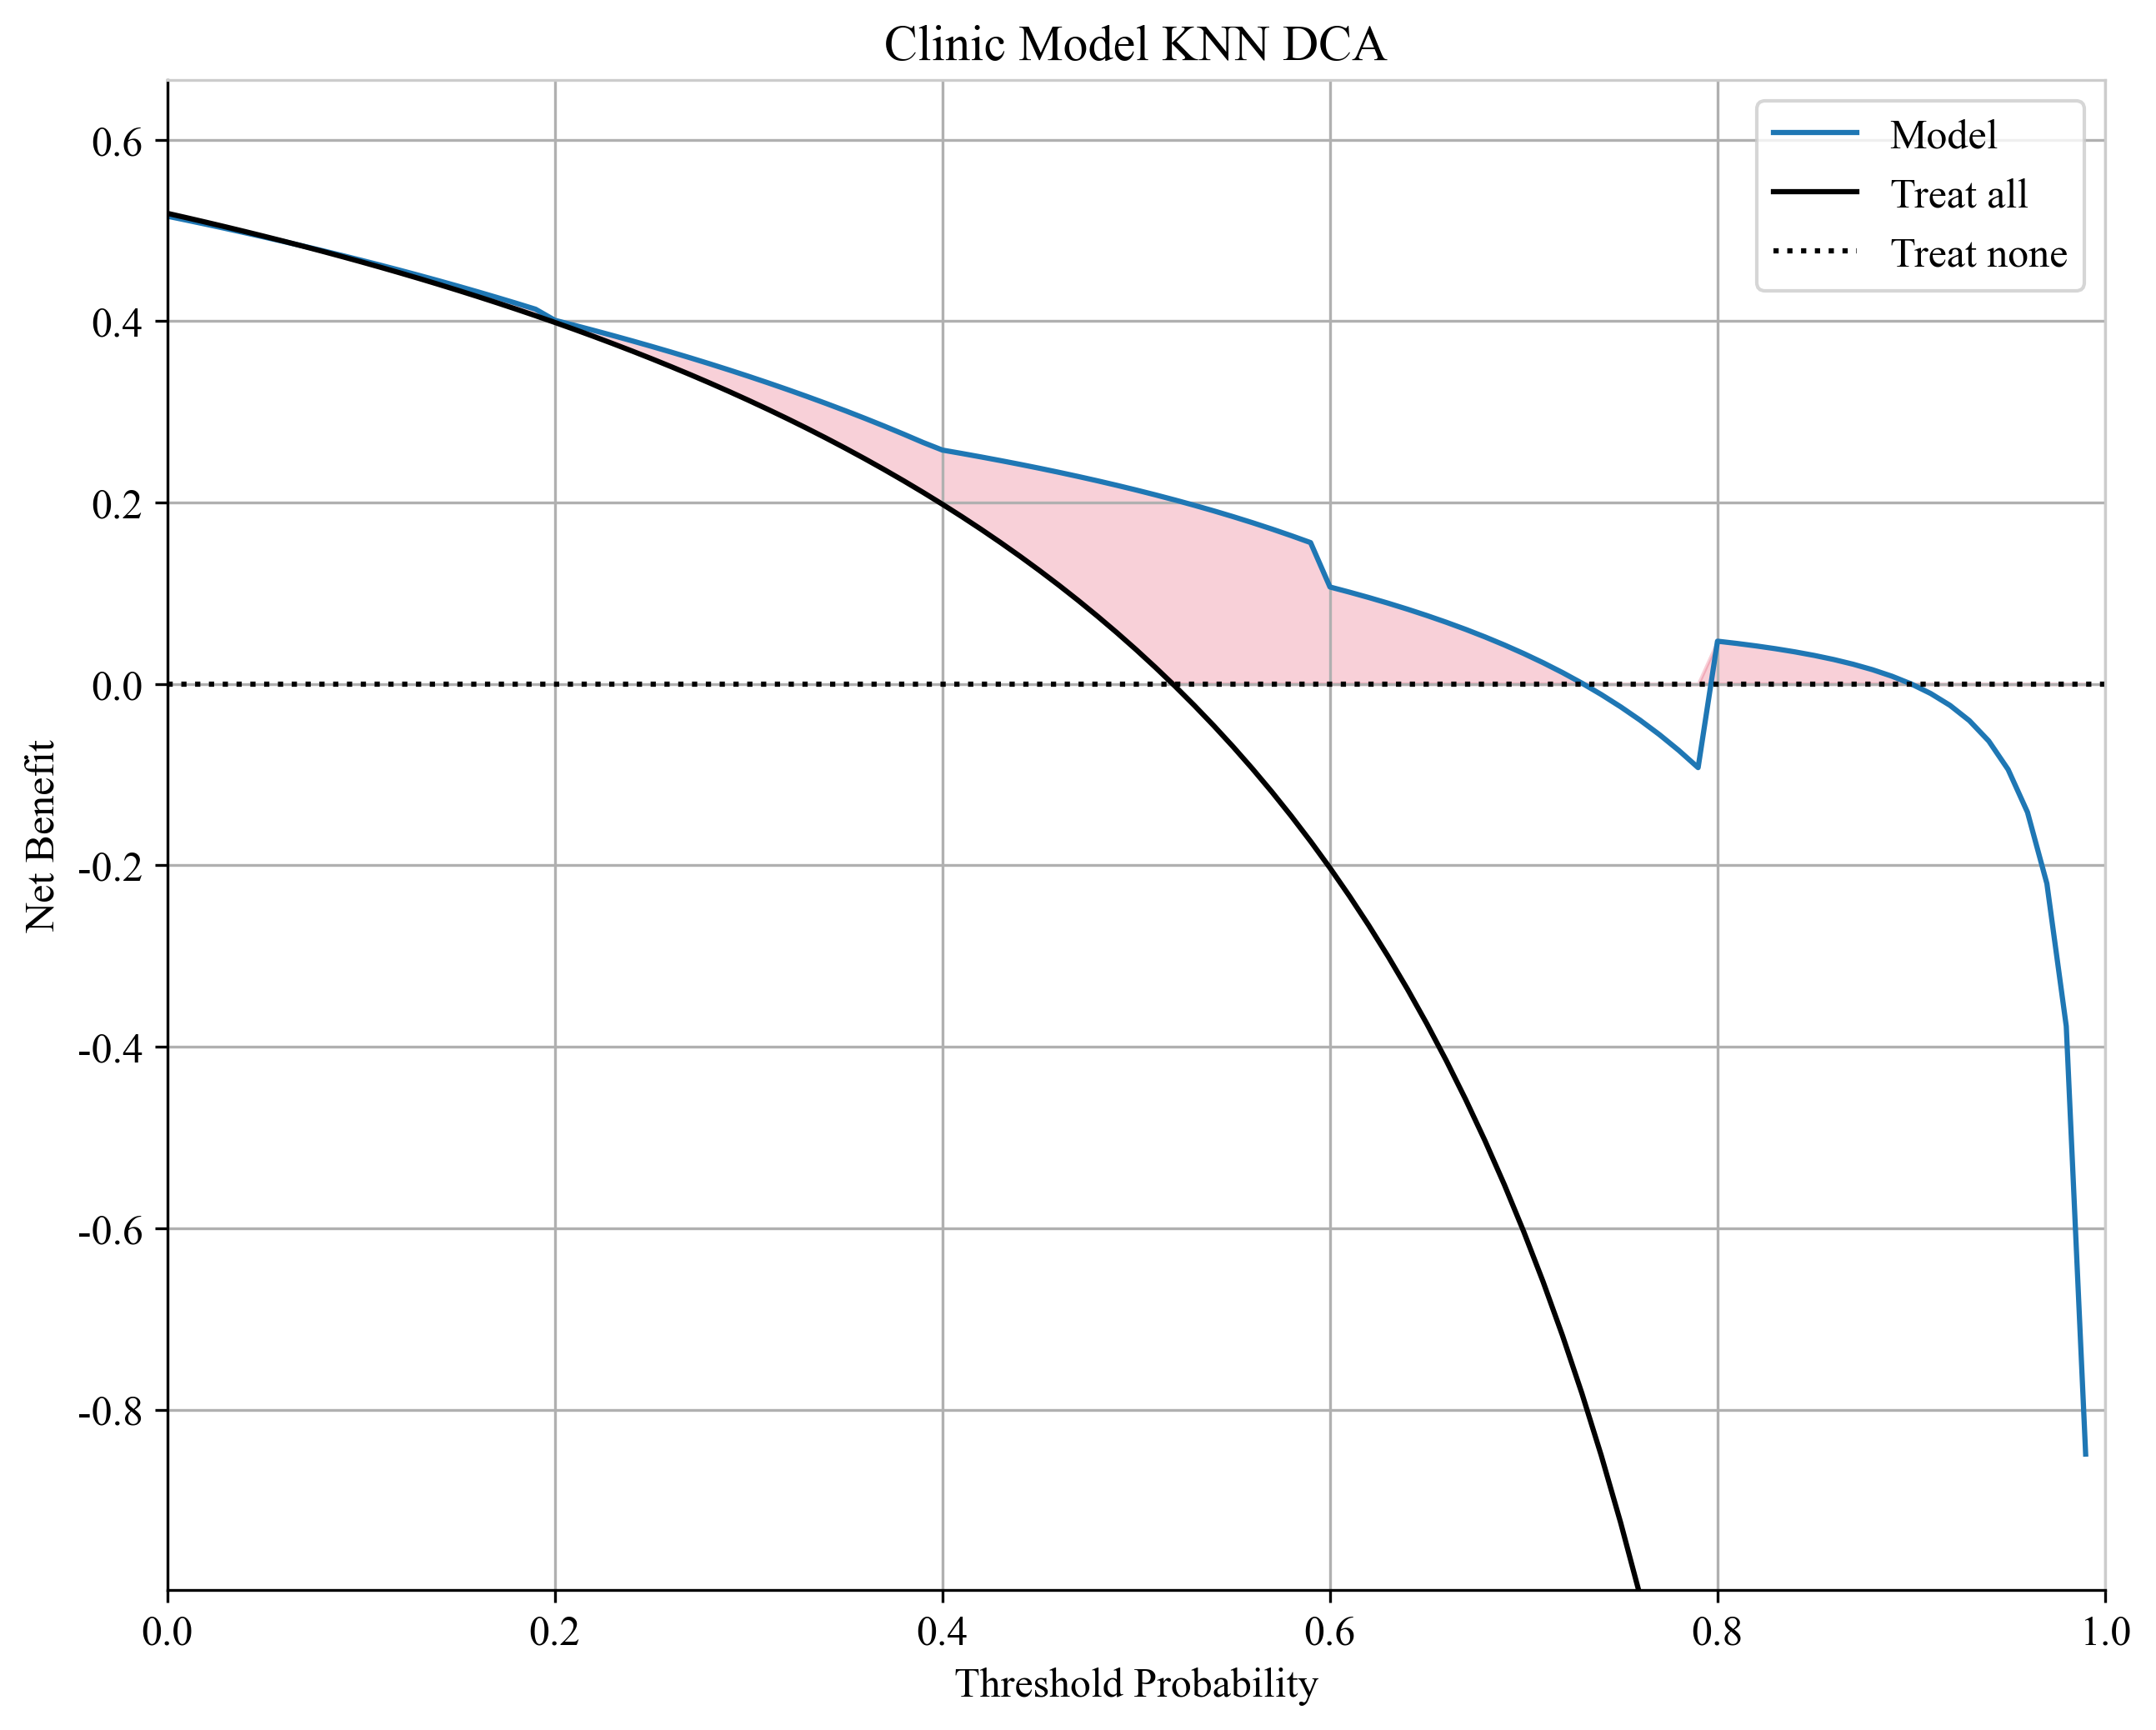

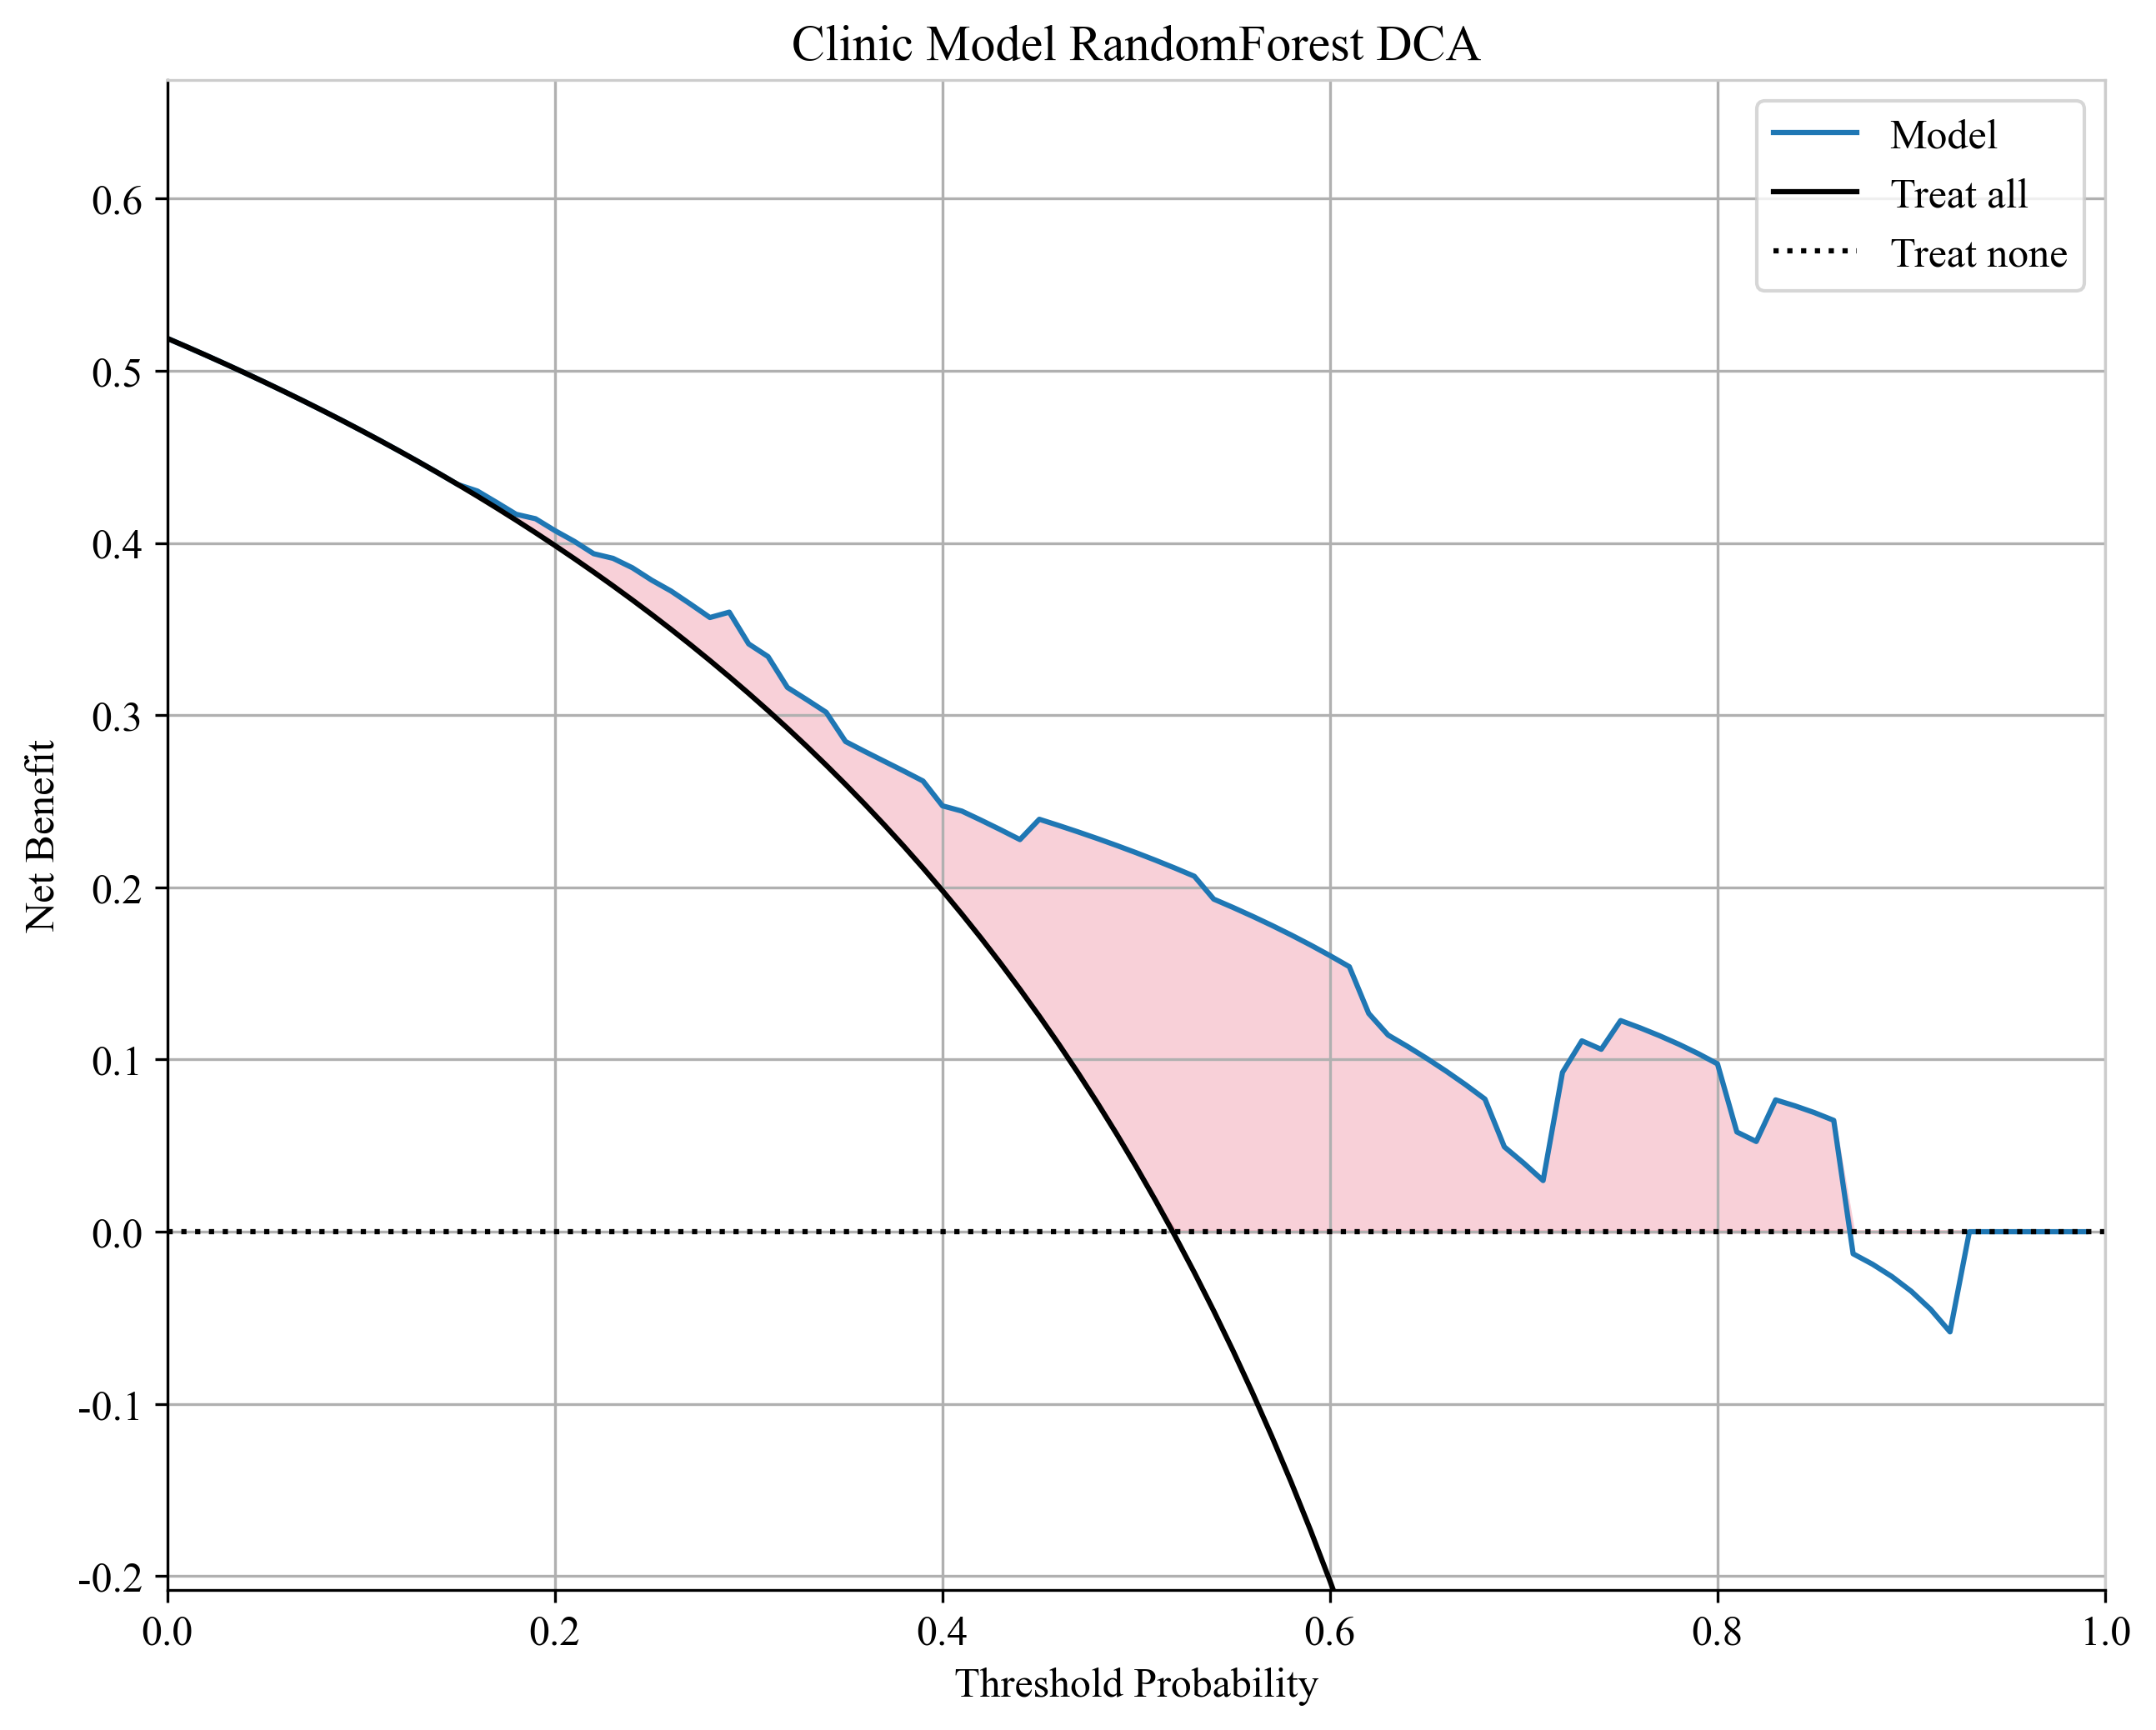

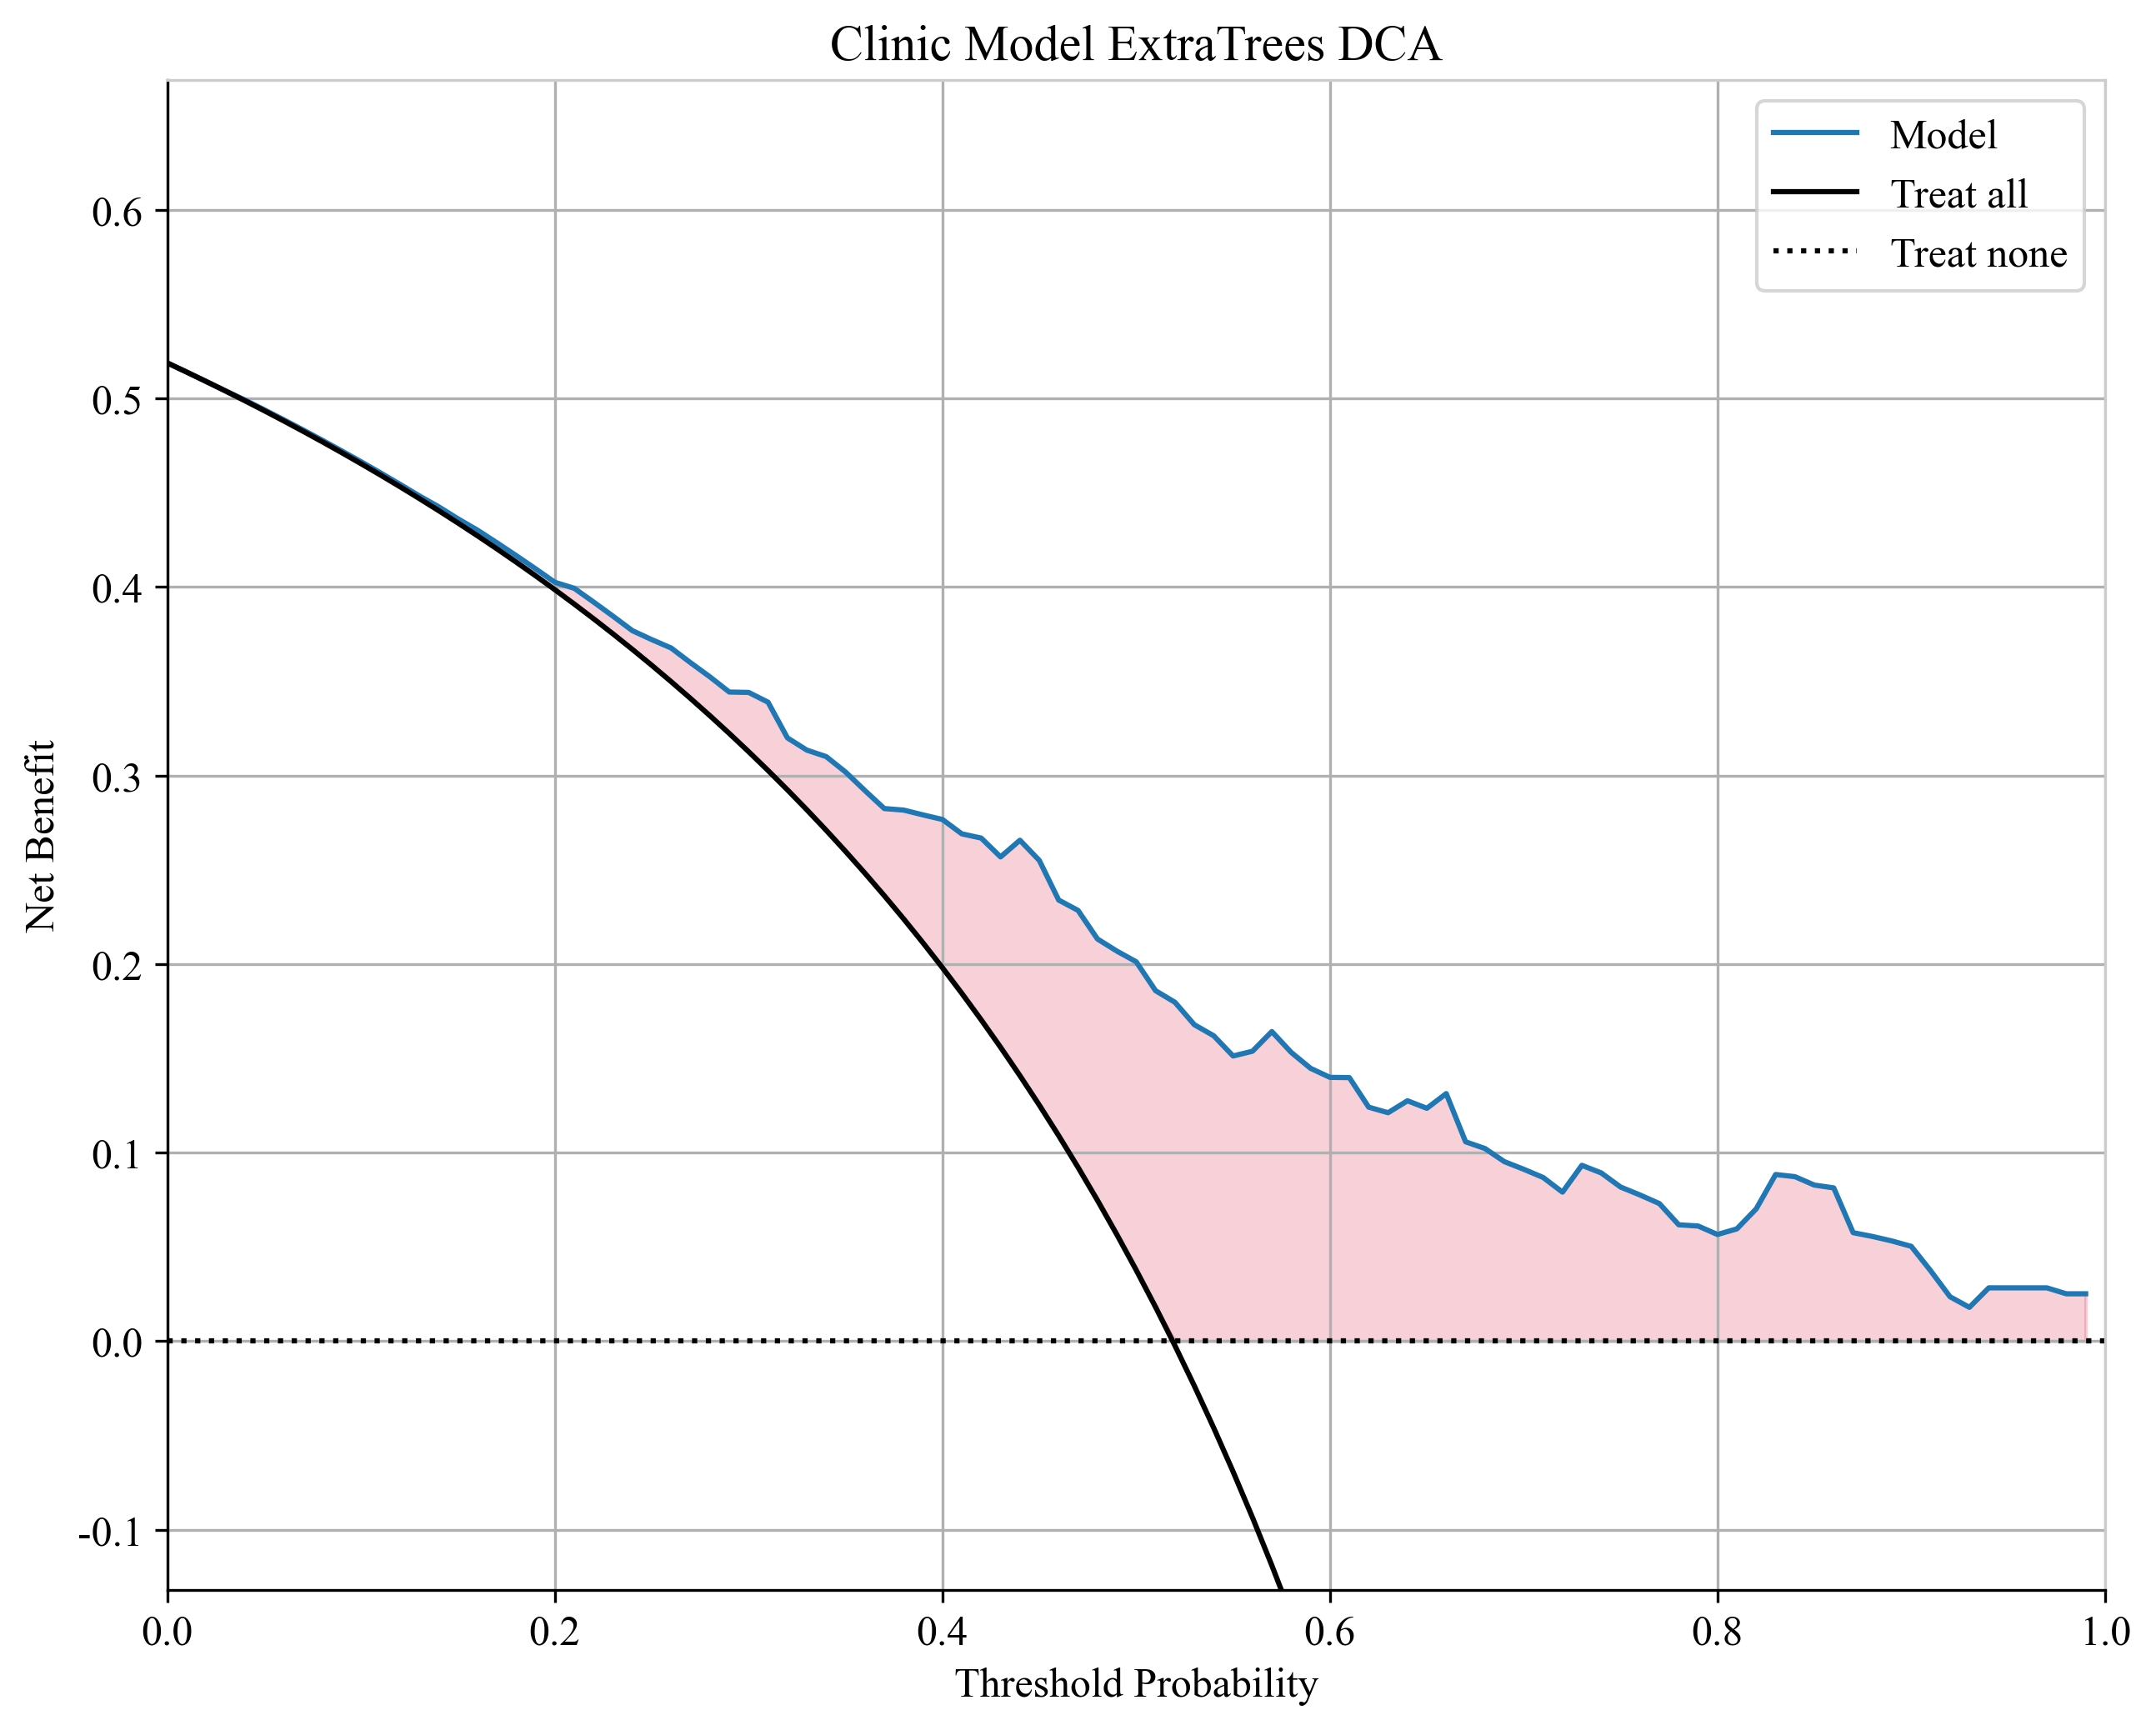

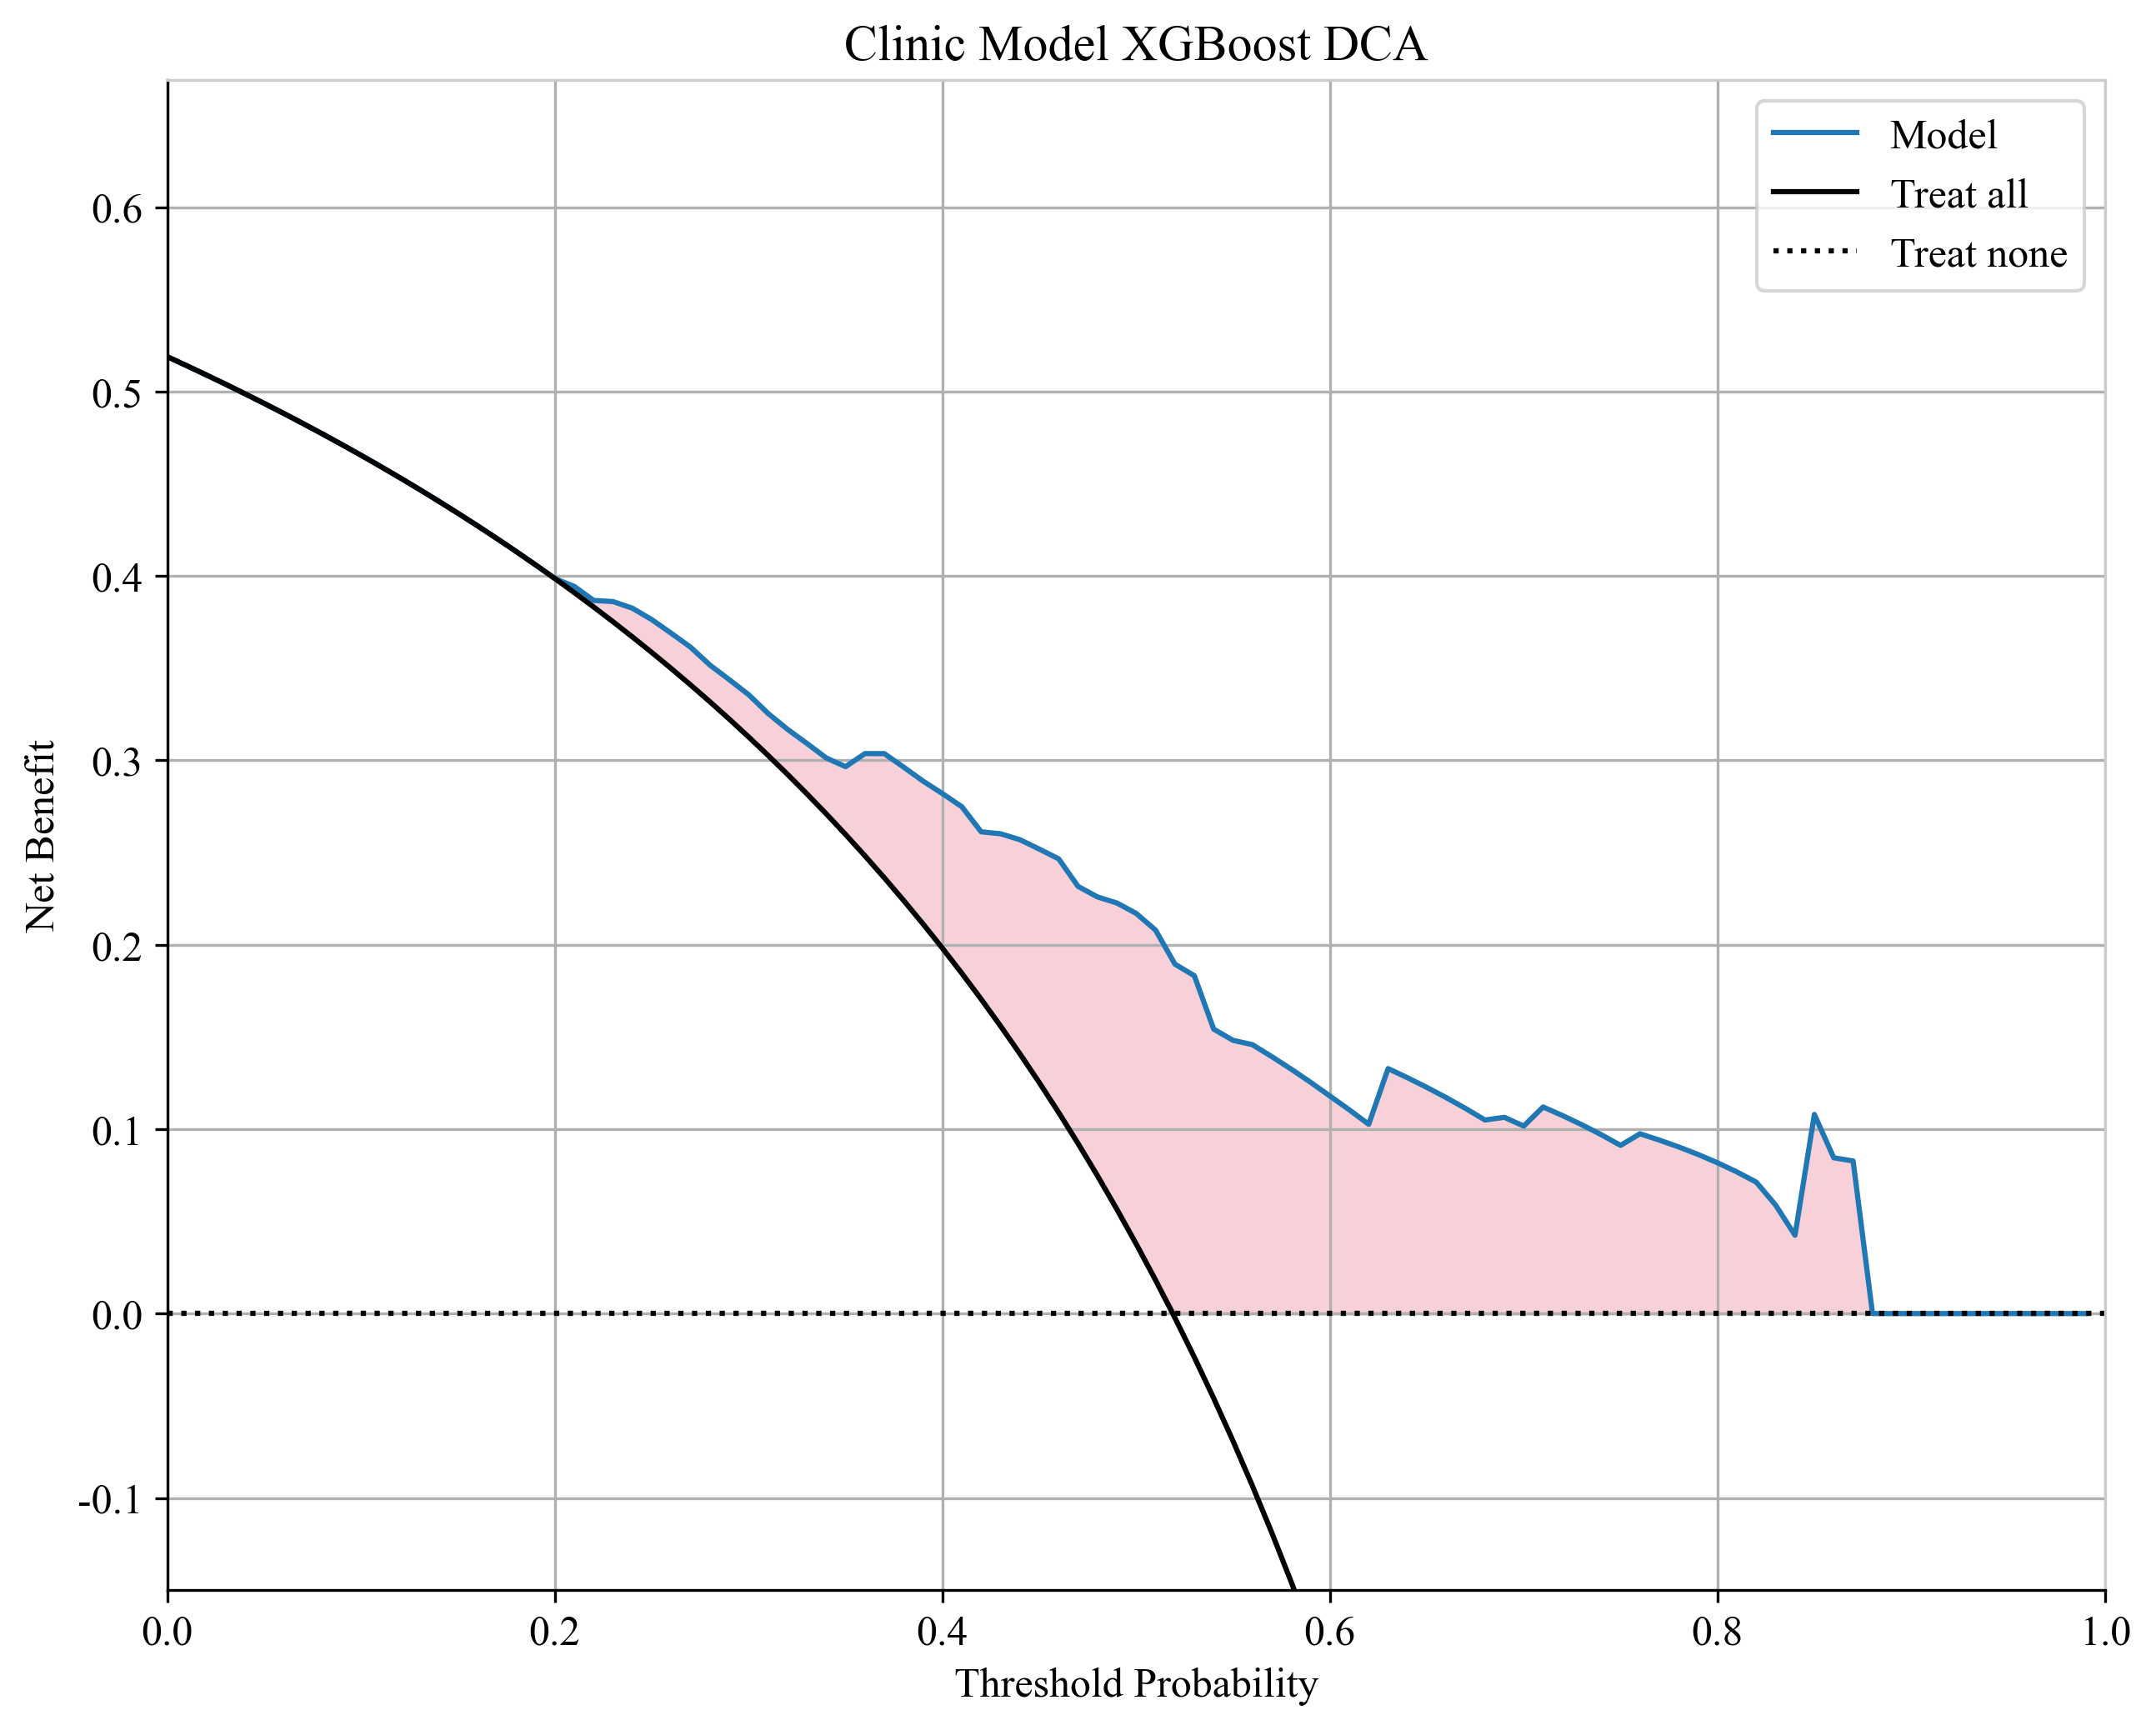

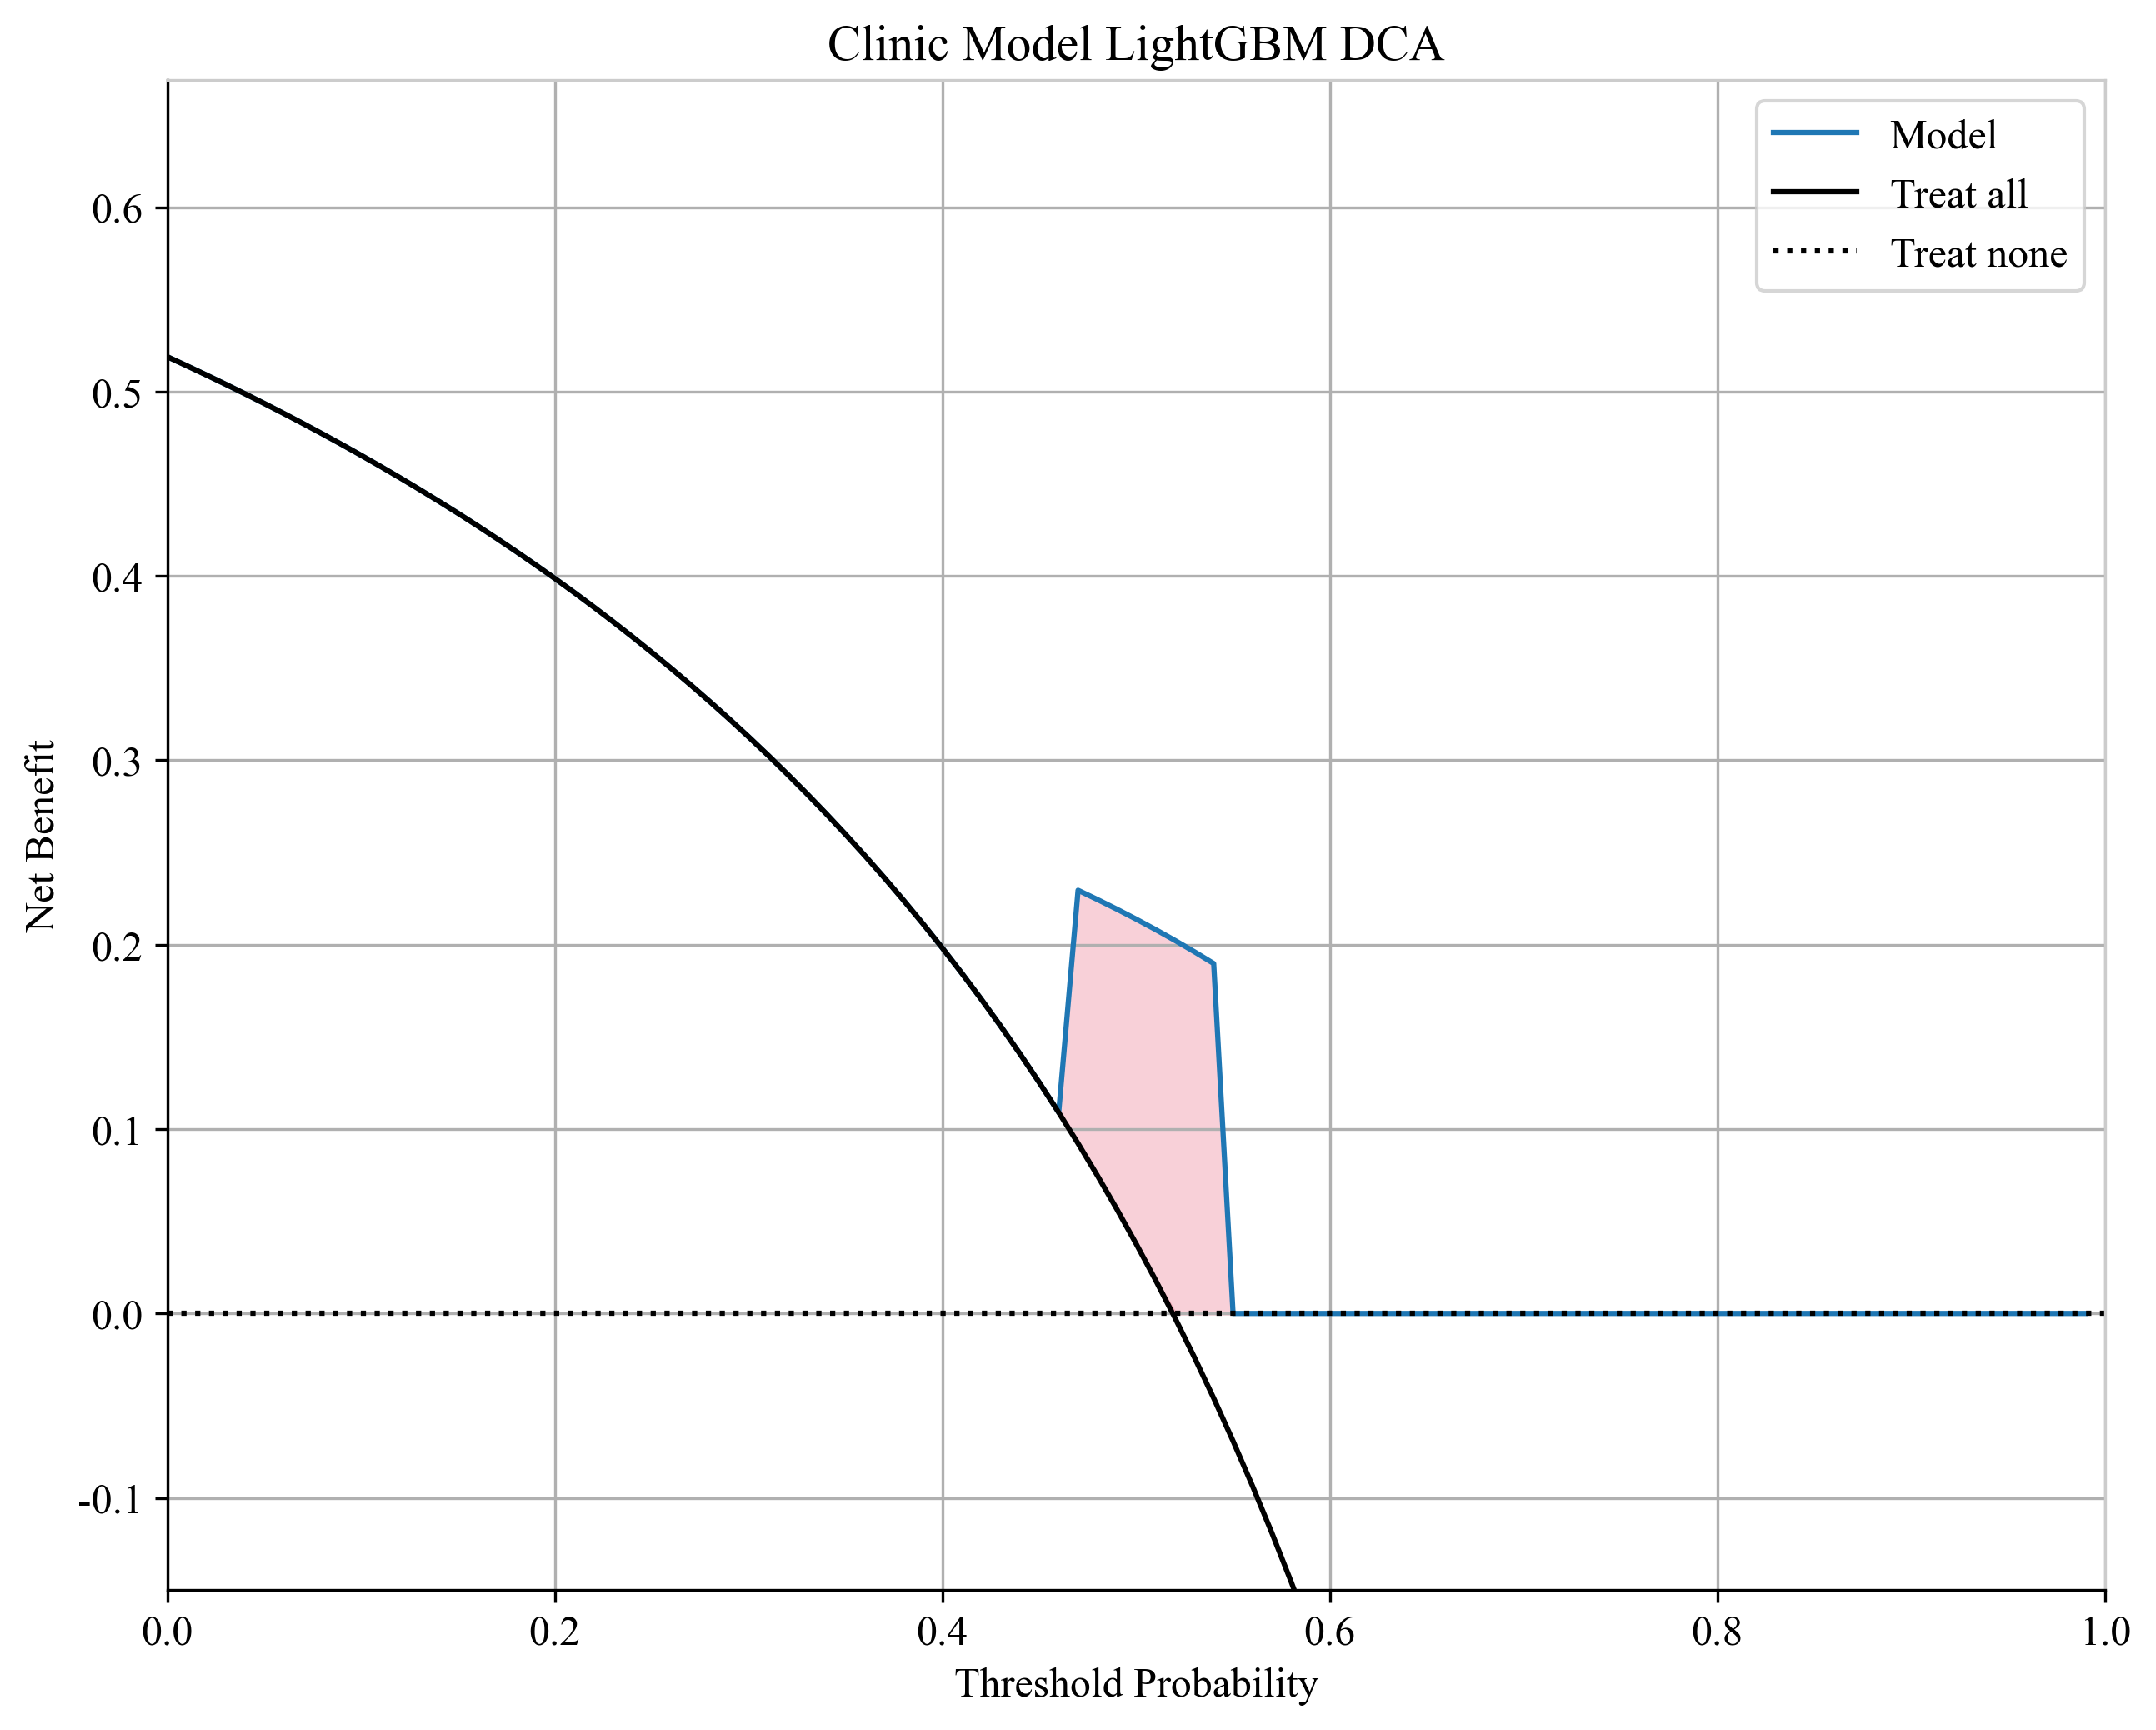

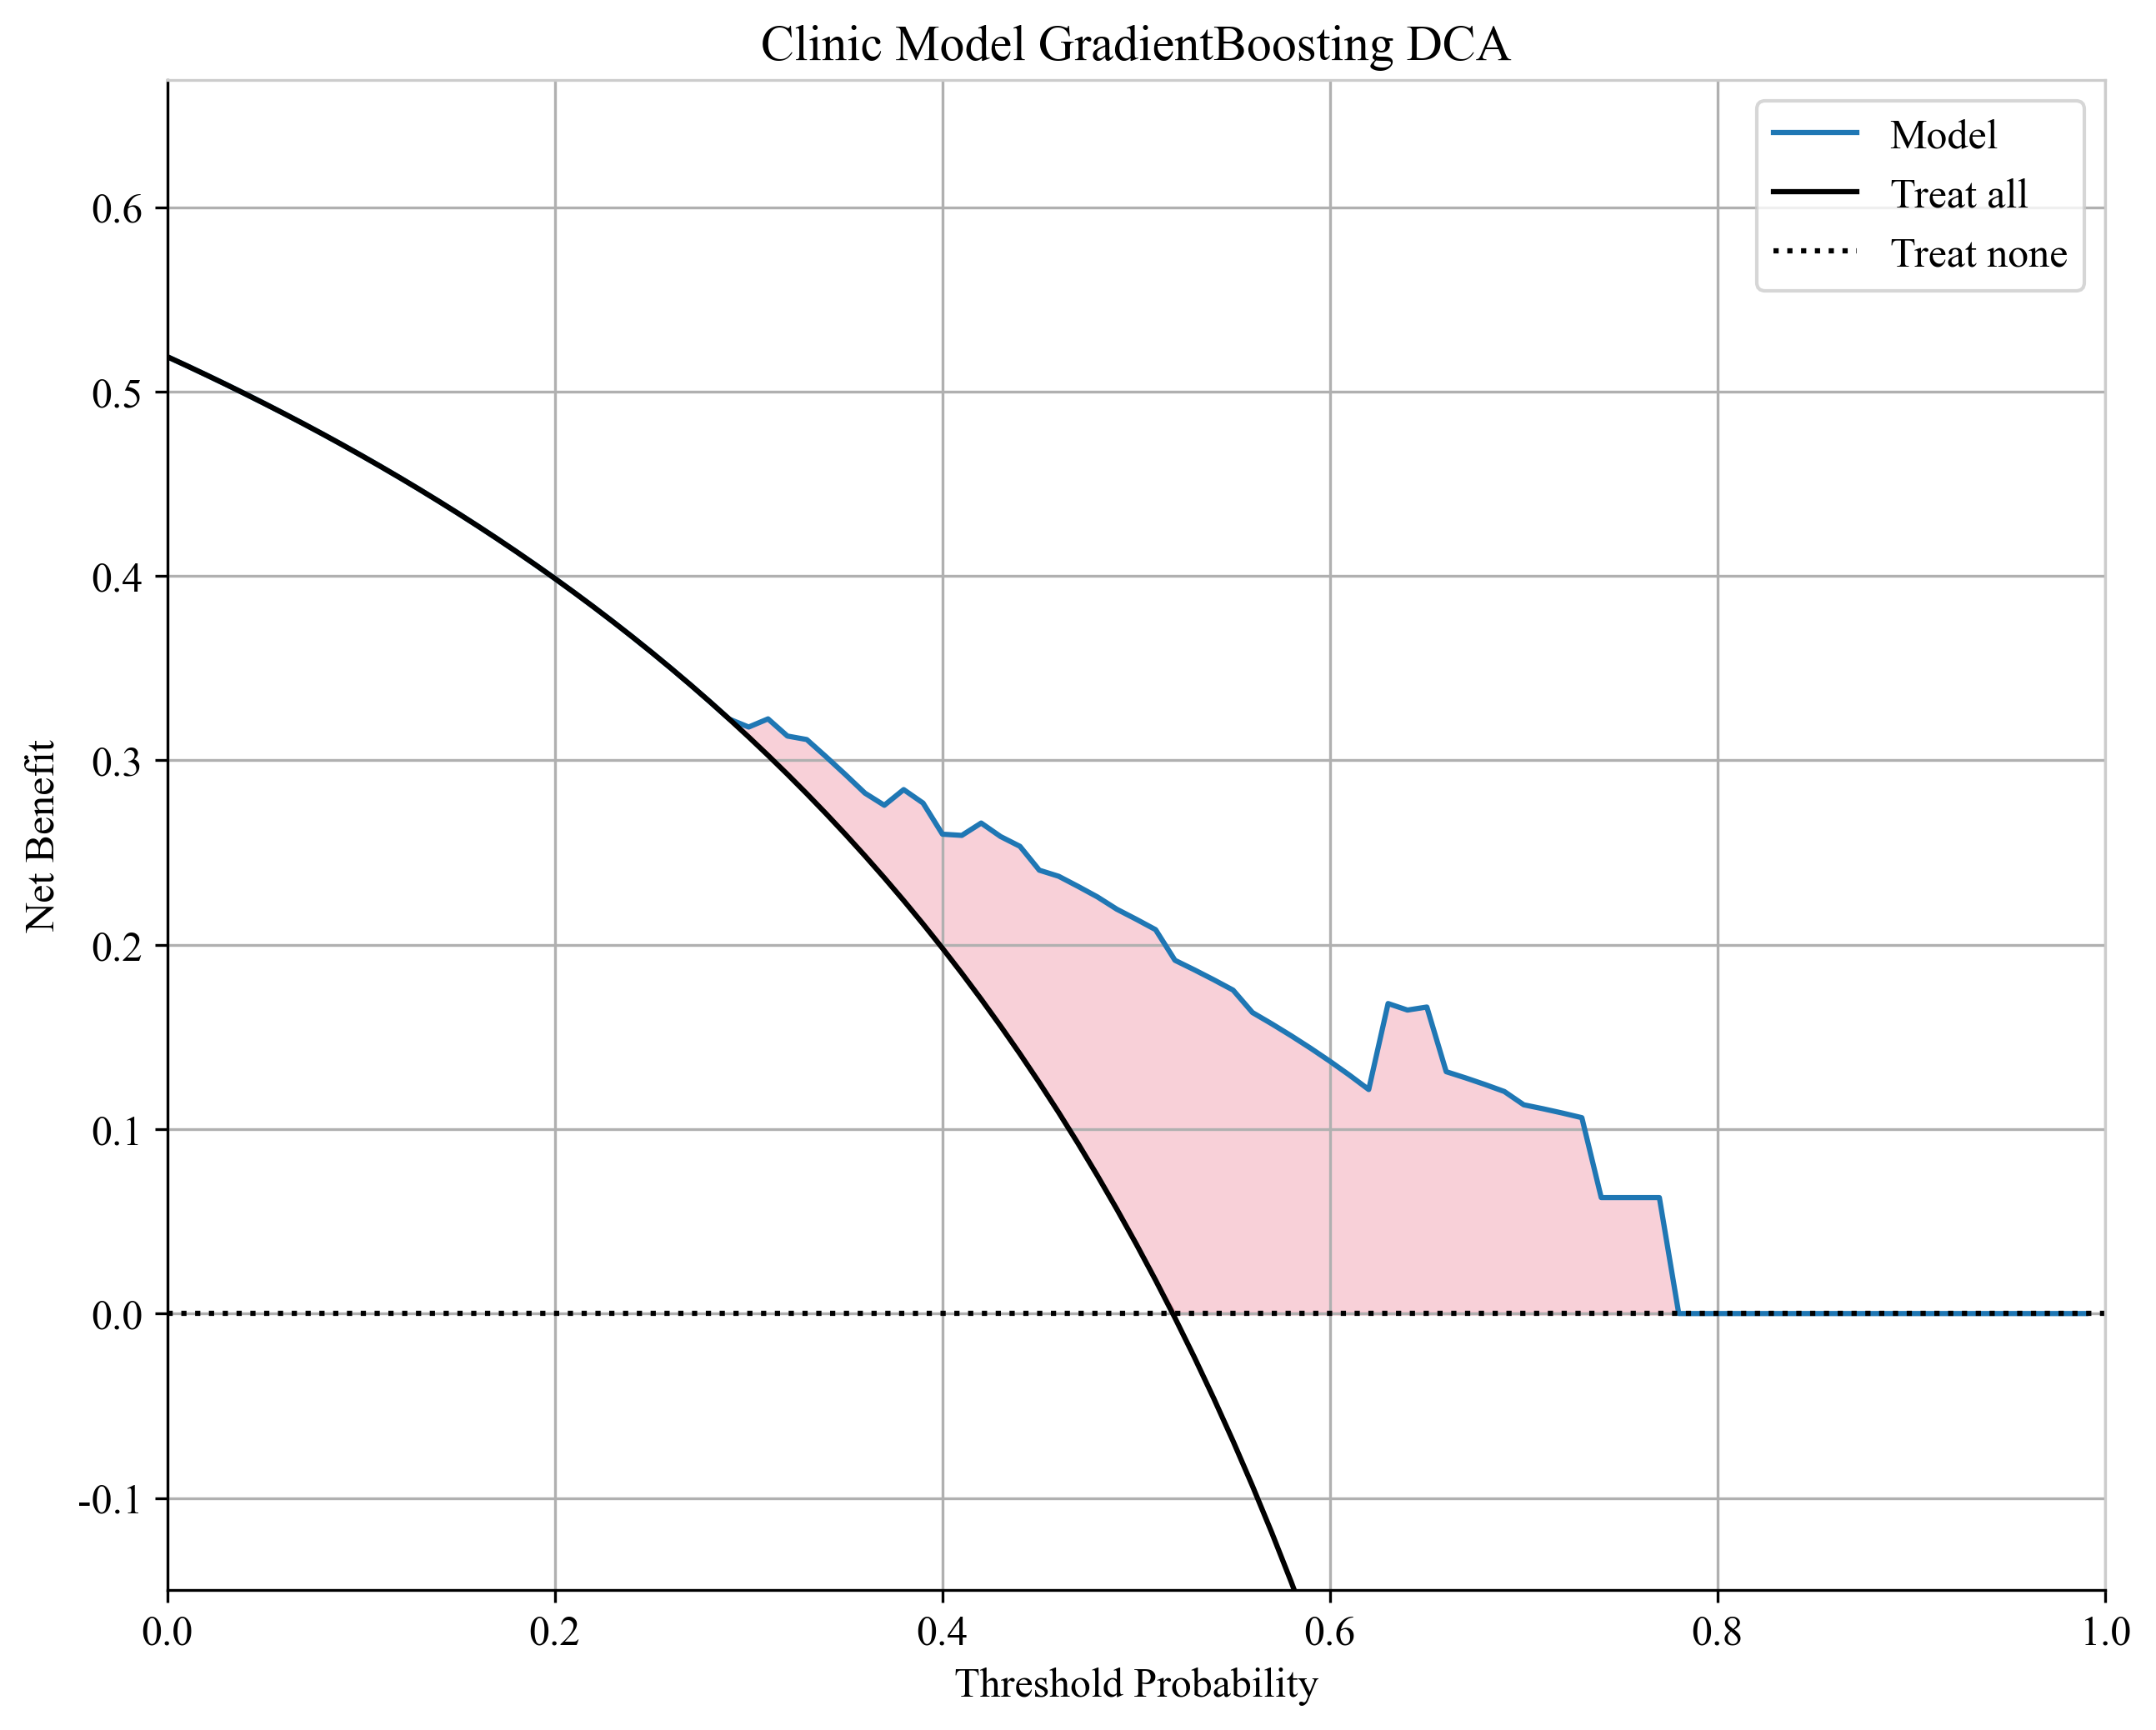

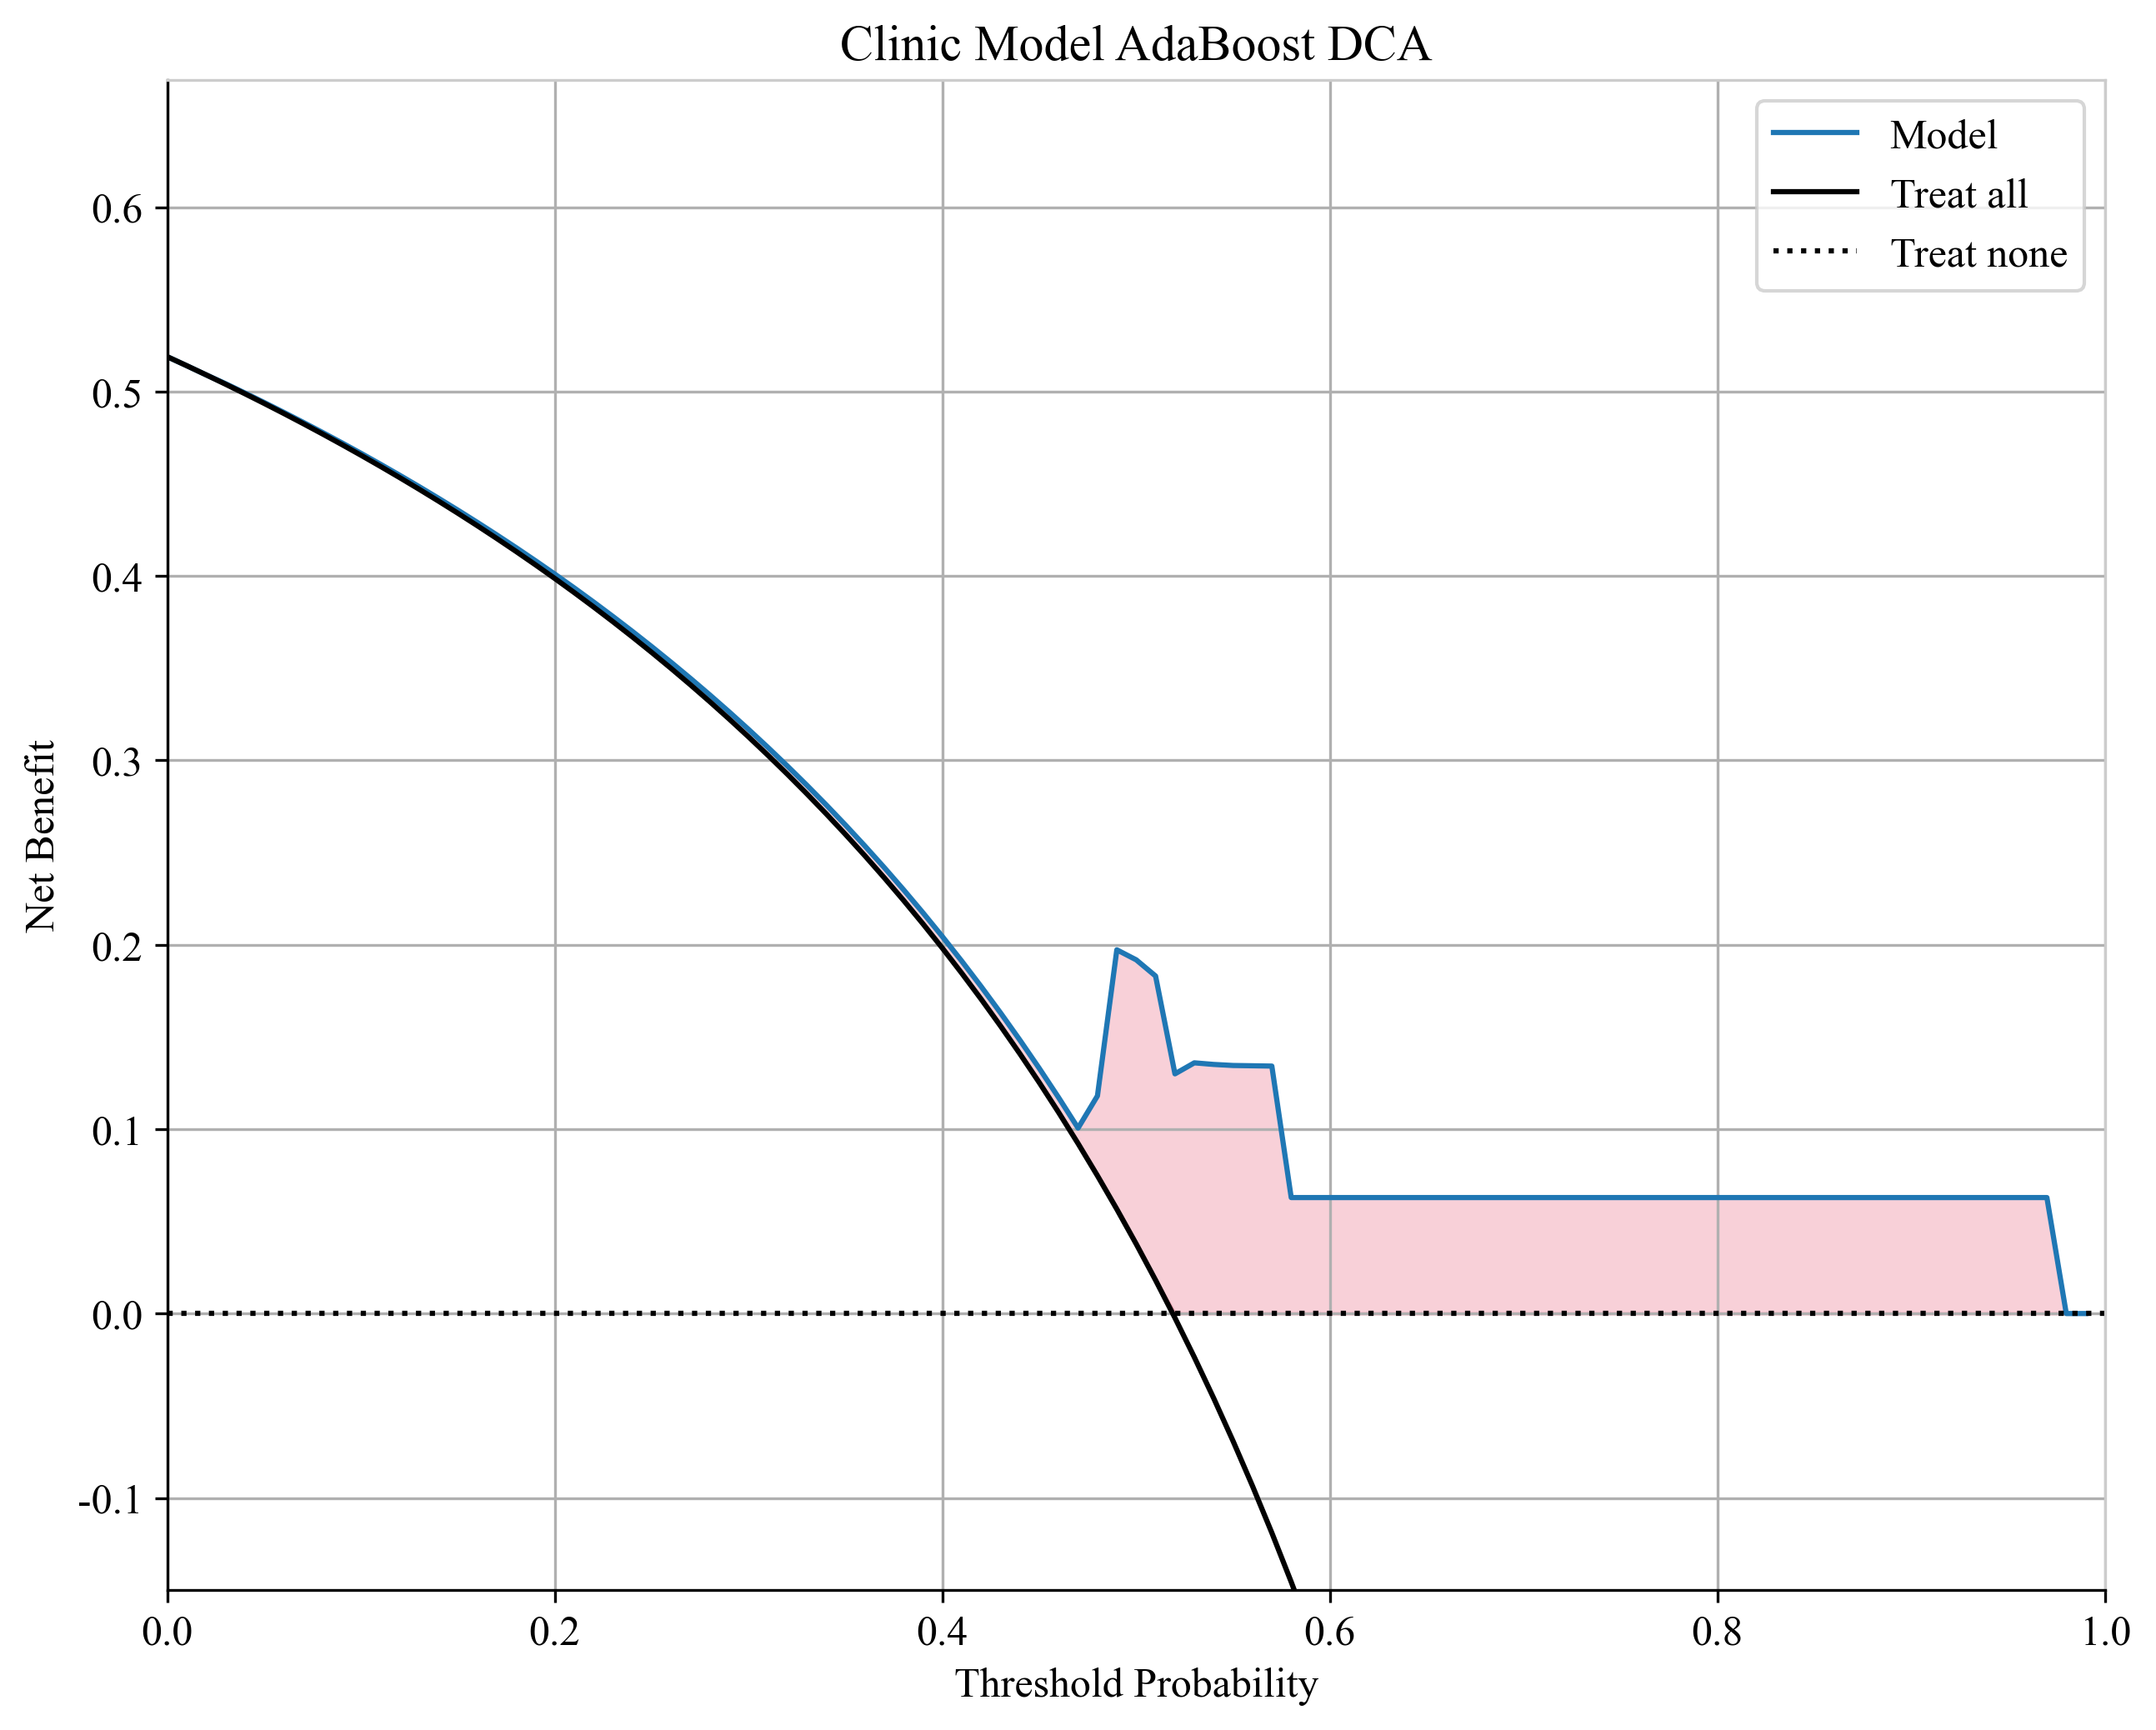

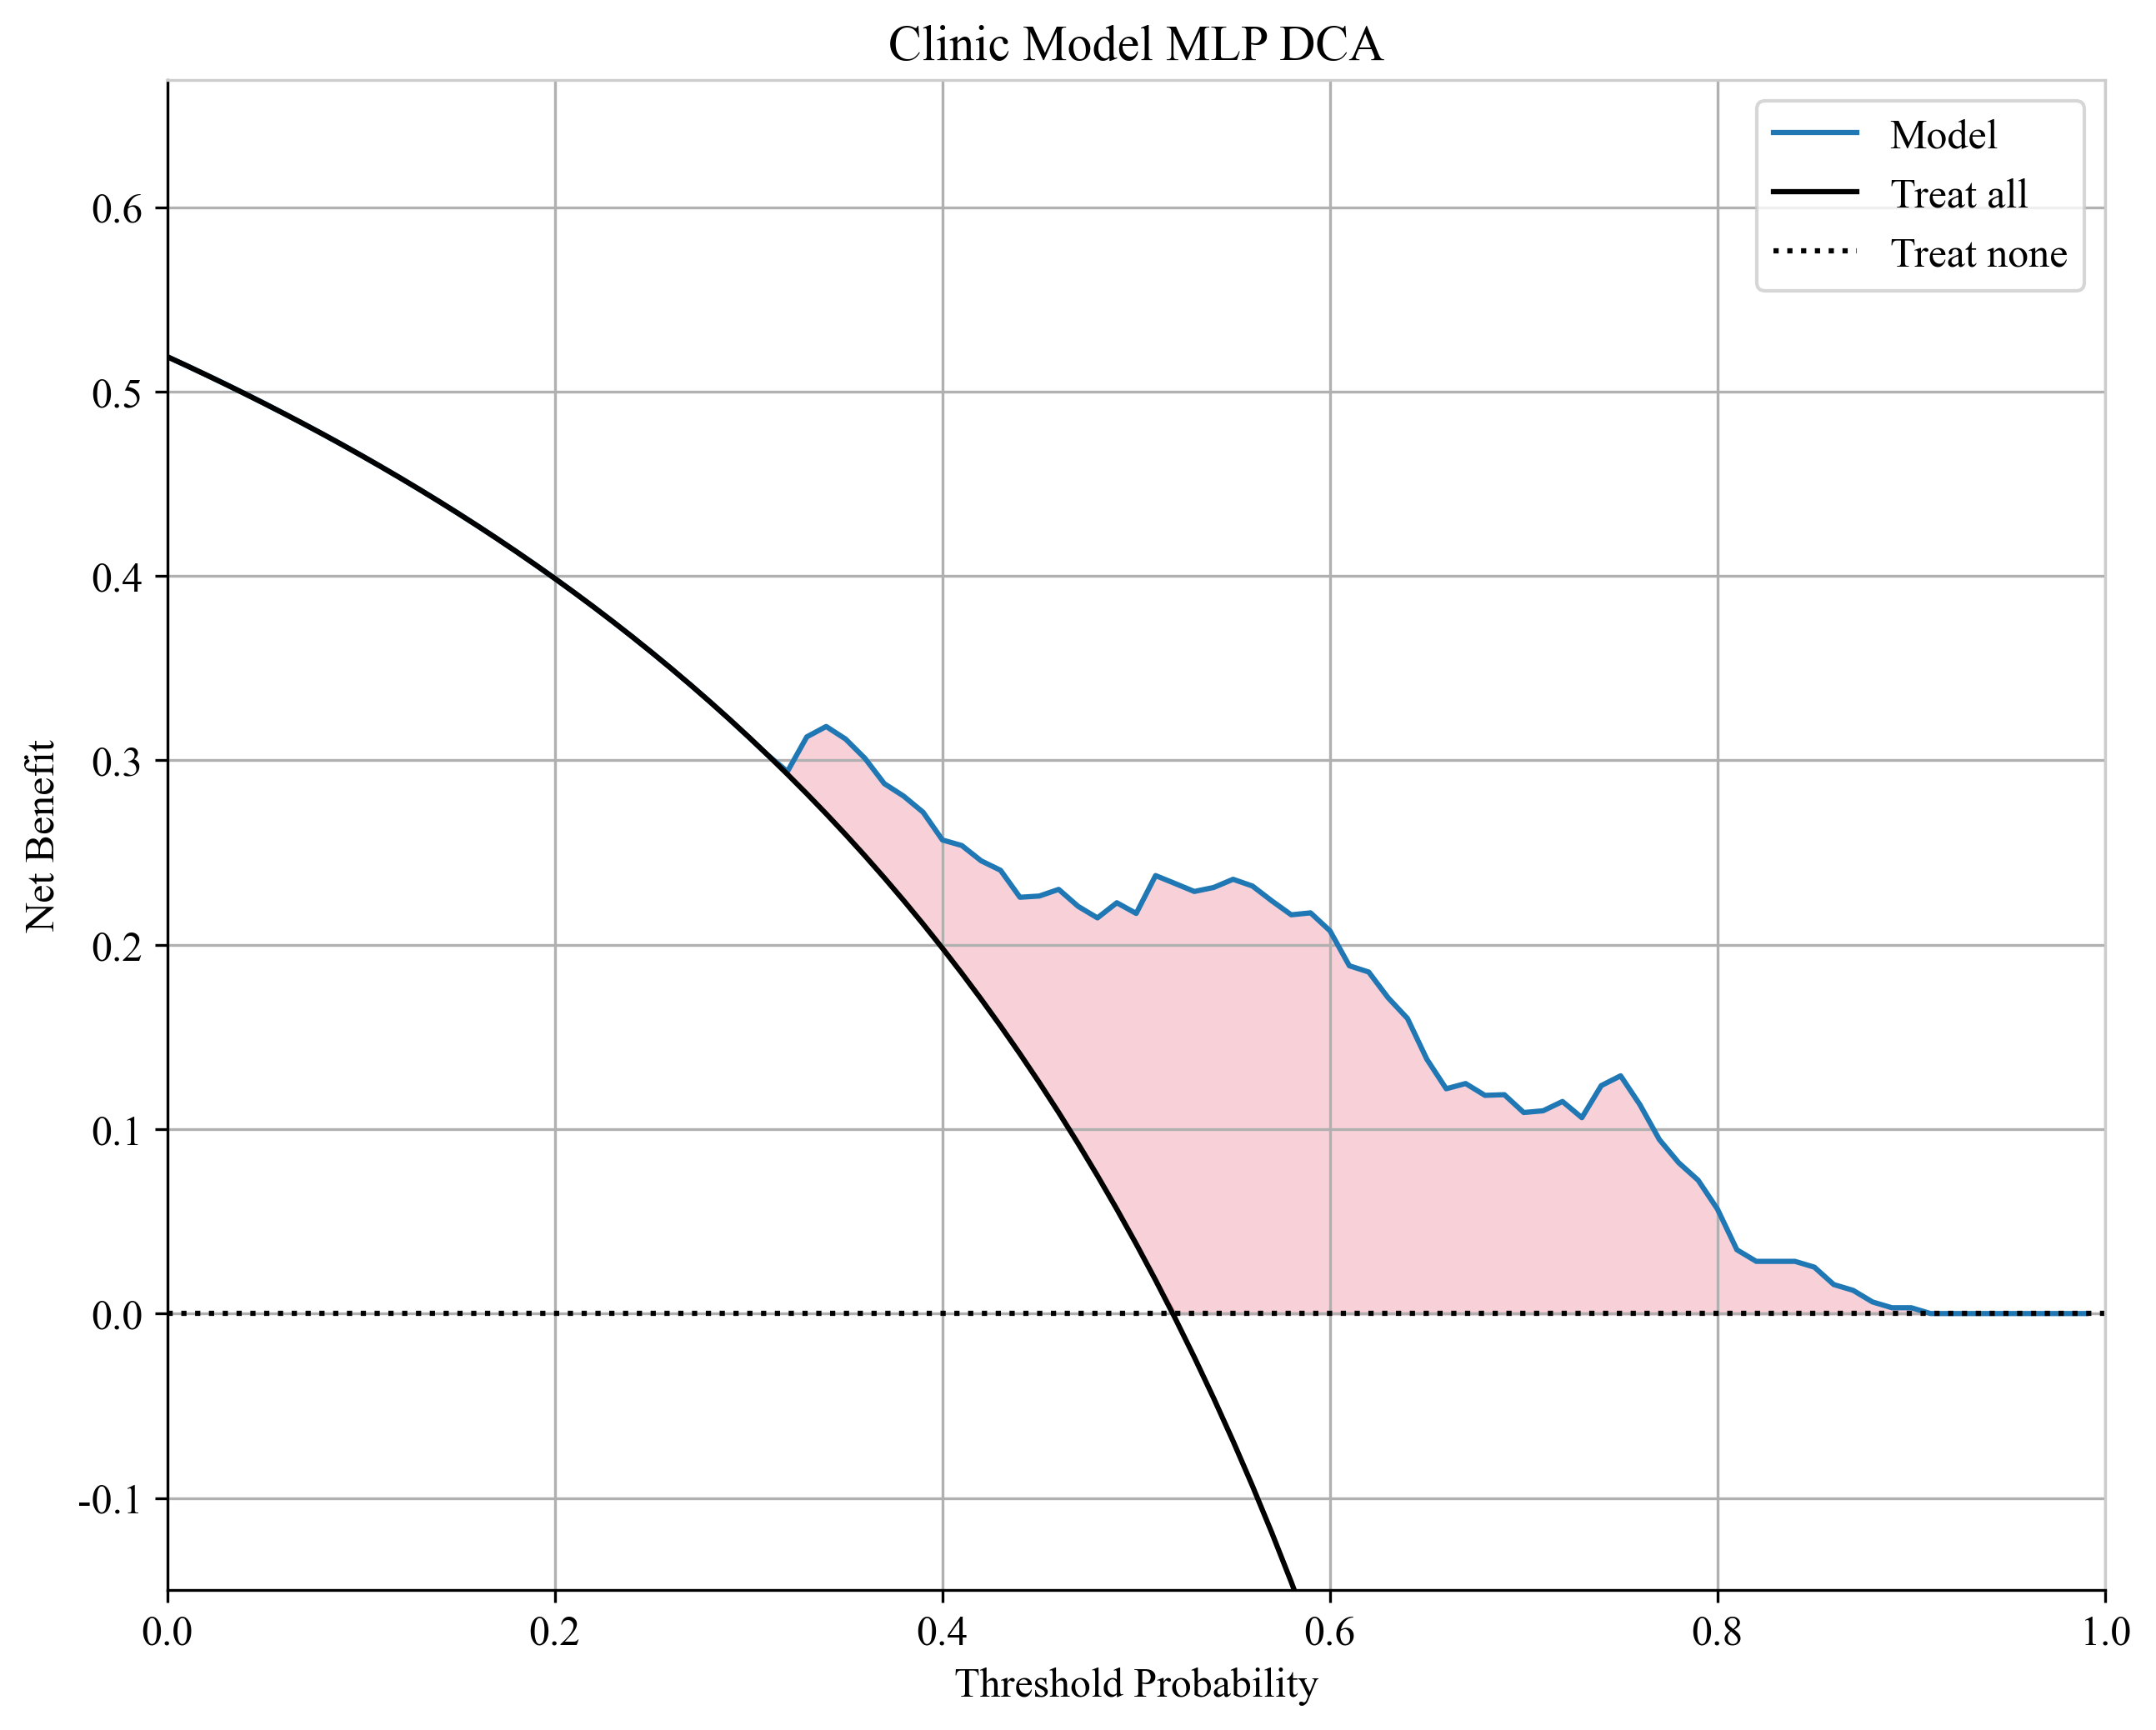

In [244]:
from onekey_algo.custom.components.comp1 import plot_DCA

for pred_score, label in zip(pred_scores, labels):
    pred_test_scores = []
    for sm in sel_model:
        if sm in model_names:
            sel_model_idx = model_names.index(sm)
            okcomp.comp1.plot_DCA(pred_score[sel_model_idx][1][:,1], np.array(y_test_sel[label]),
                                  title=f'Clinic Model {sm} DCA')
            plt.savefig(f'img/Clinic_model_{sm}_dca.svg', bbox_inches = 'tight')

## 绘制混淆矩阵

绘制混淆矩阵，[混淆矩阵解释](https://baike.baidu.com/item/%E6%B7%B7%E6%B7%86%E7%9F%A9%E9%98%B5/10087822?fr=aladdin)
`sel_model = ['SVM', 'KNN']`参数为想要绘制的模型对应的参数。

如果需要修改标签到名称的映射，修改`class_mapping={1:'1', 0:'0'}`

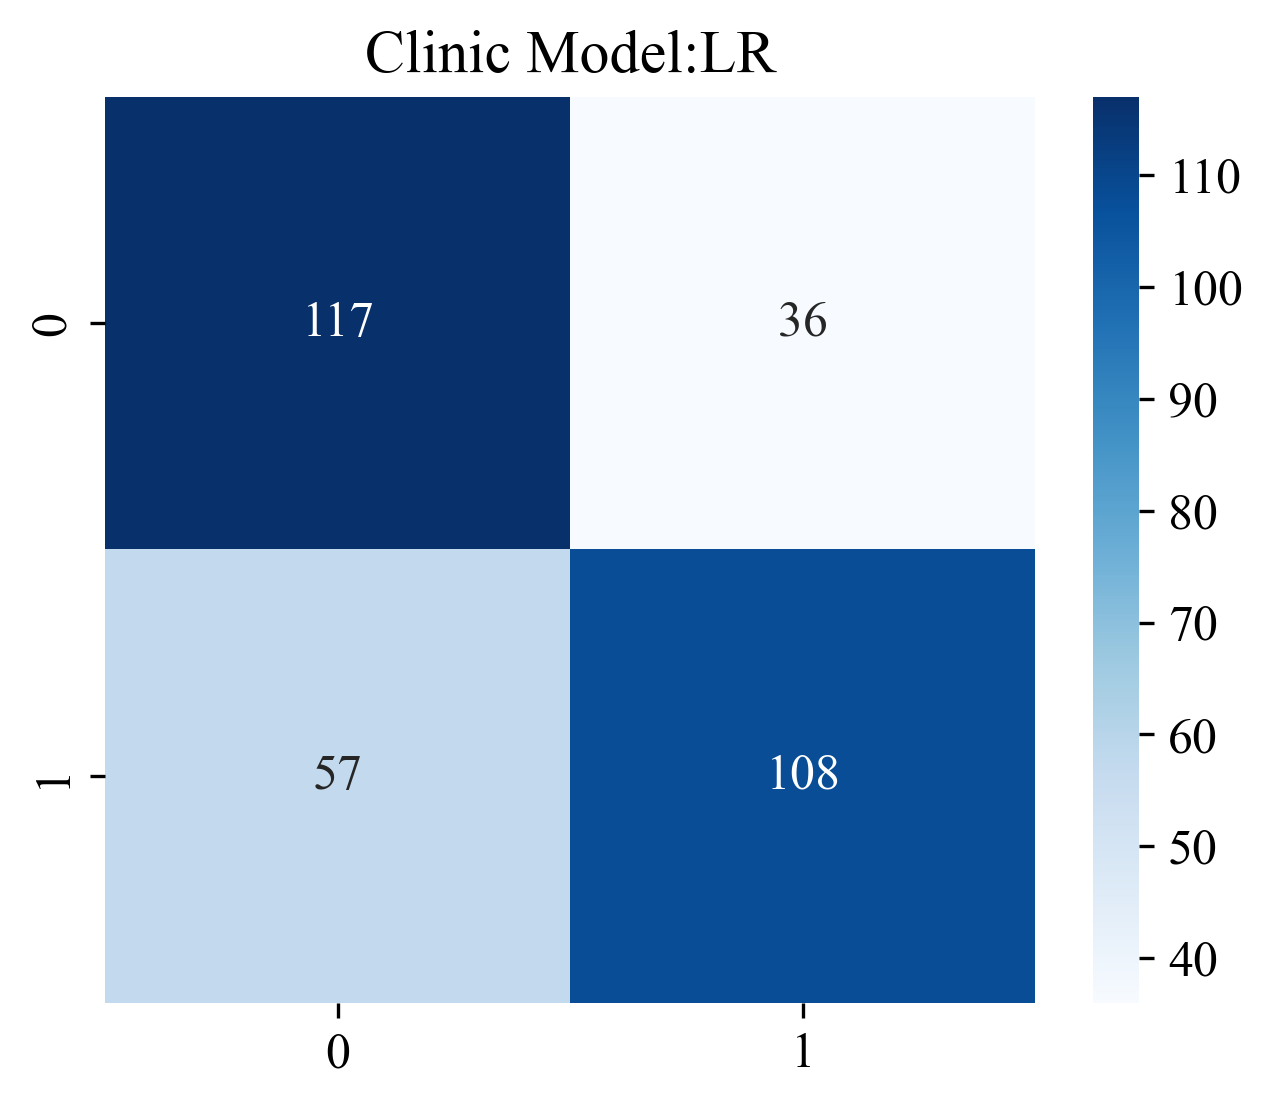

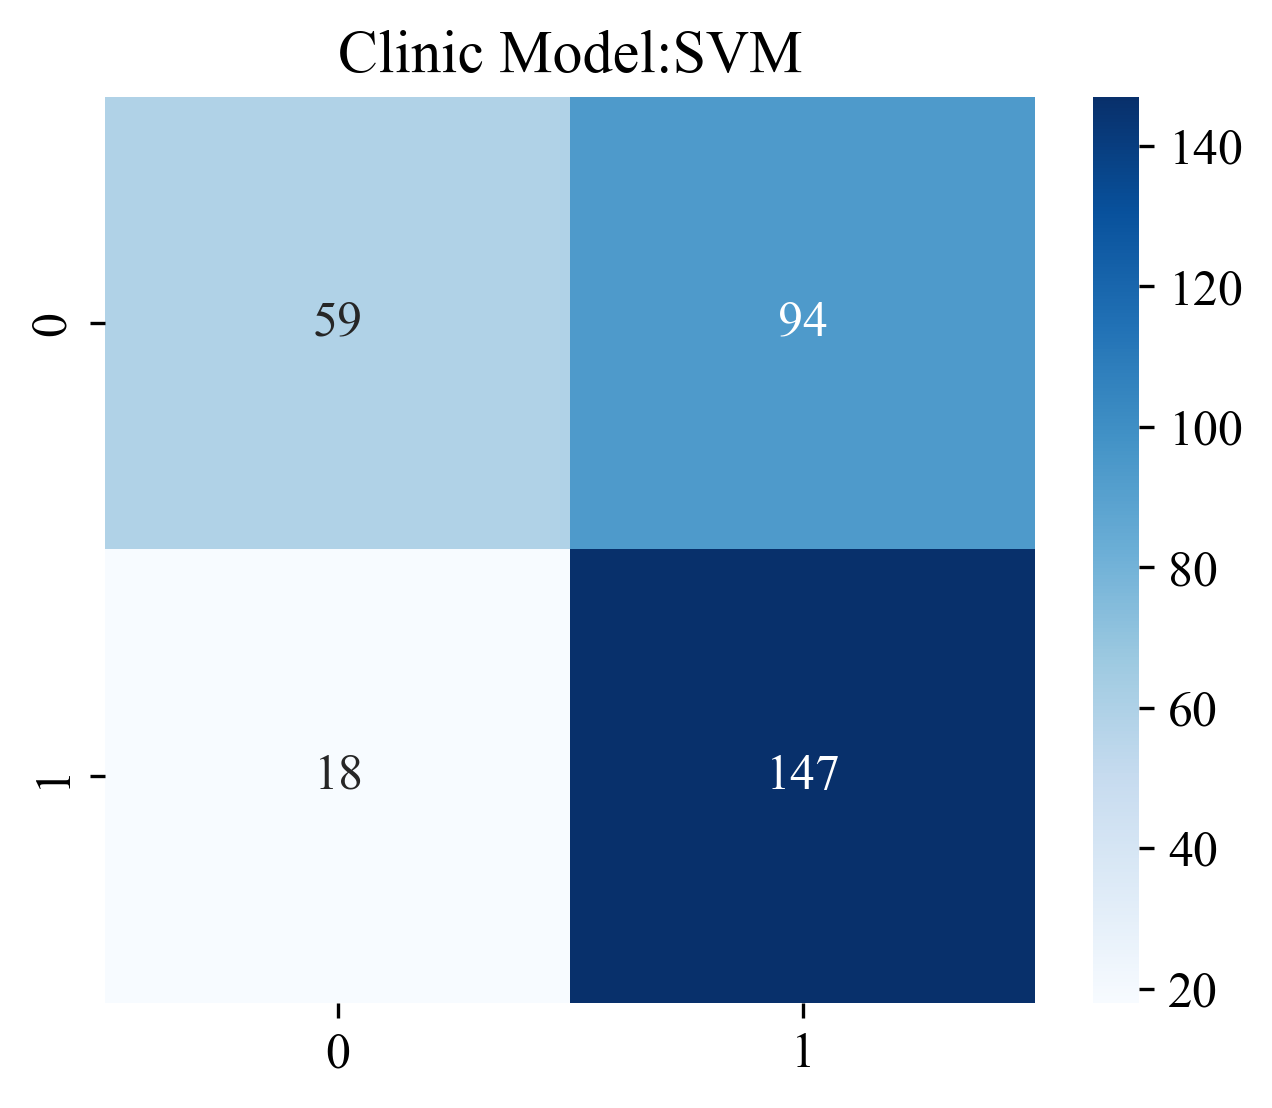

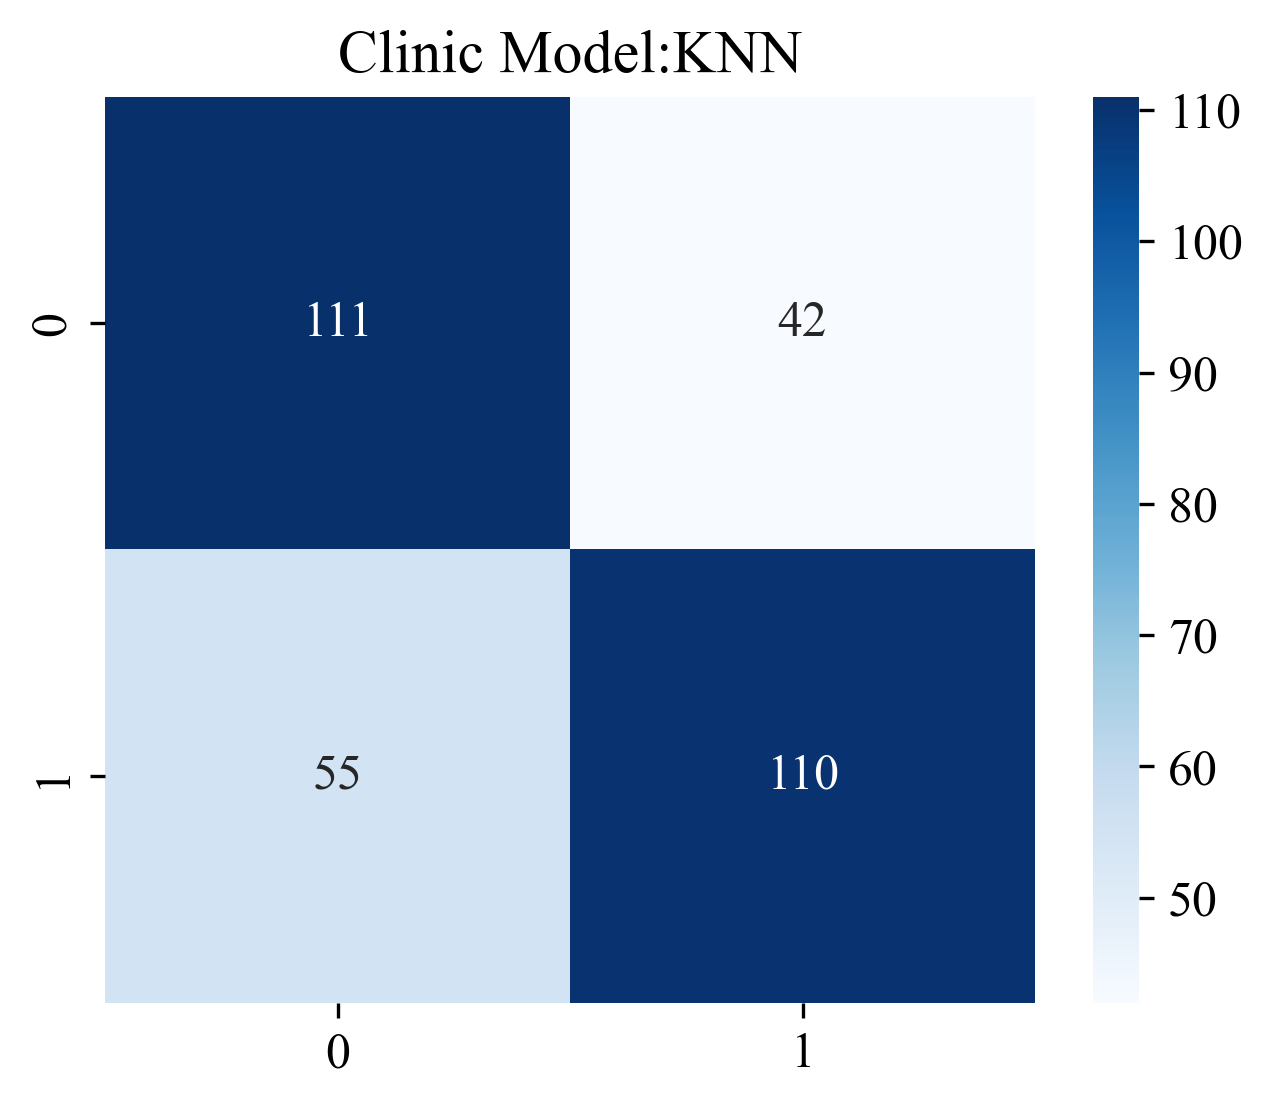

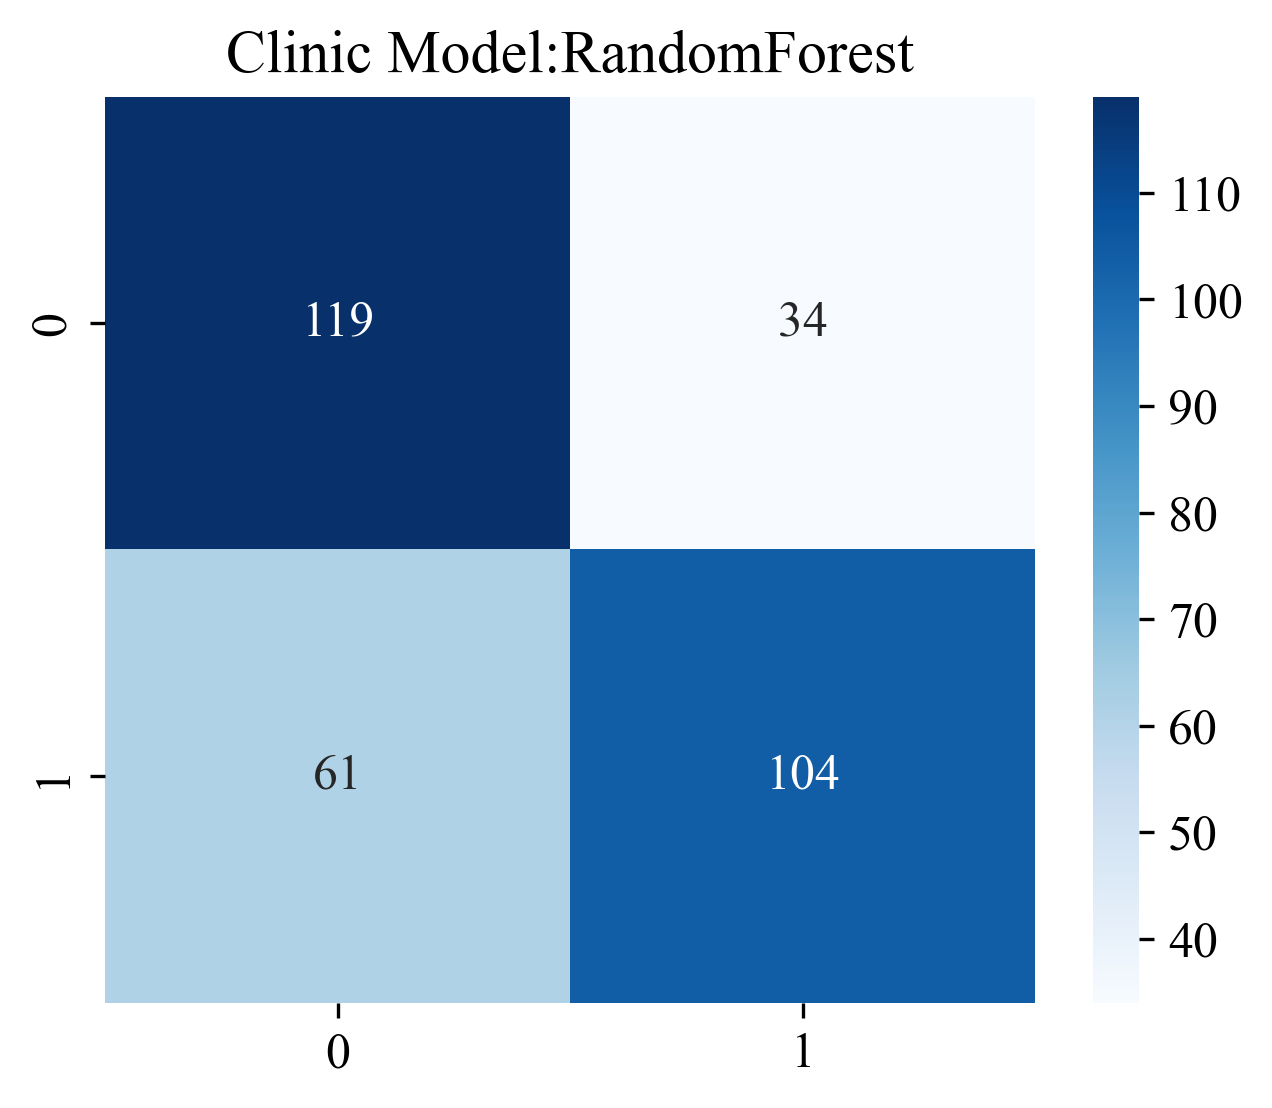

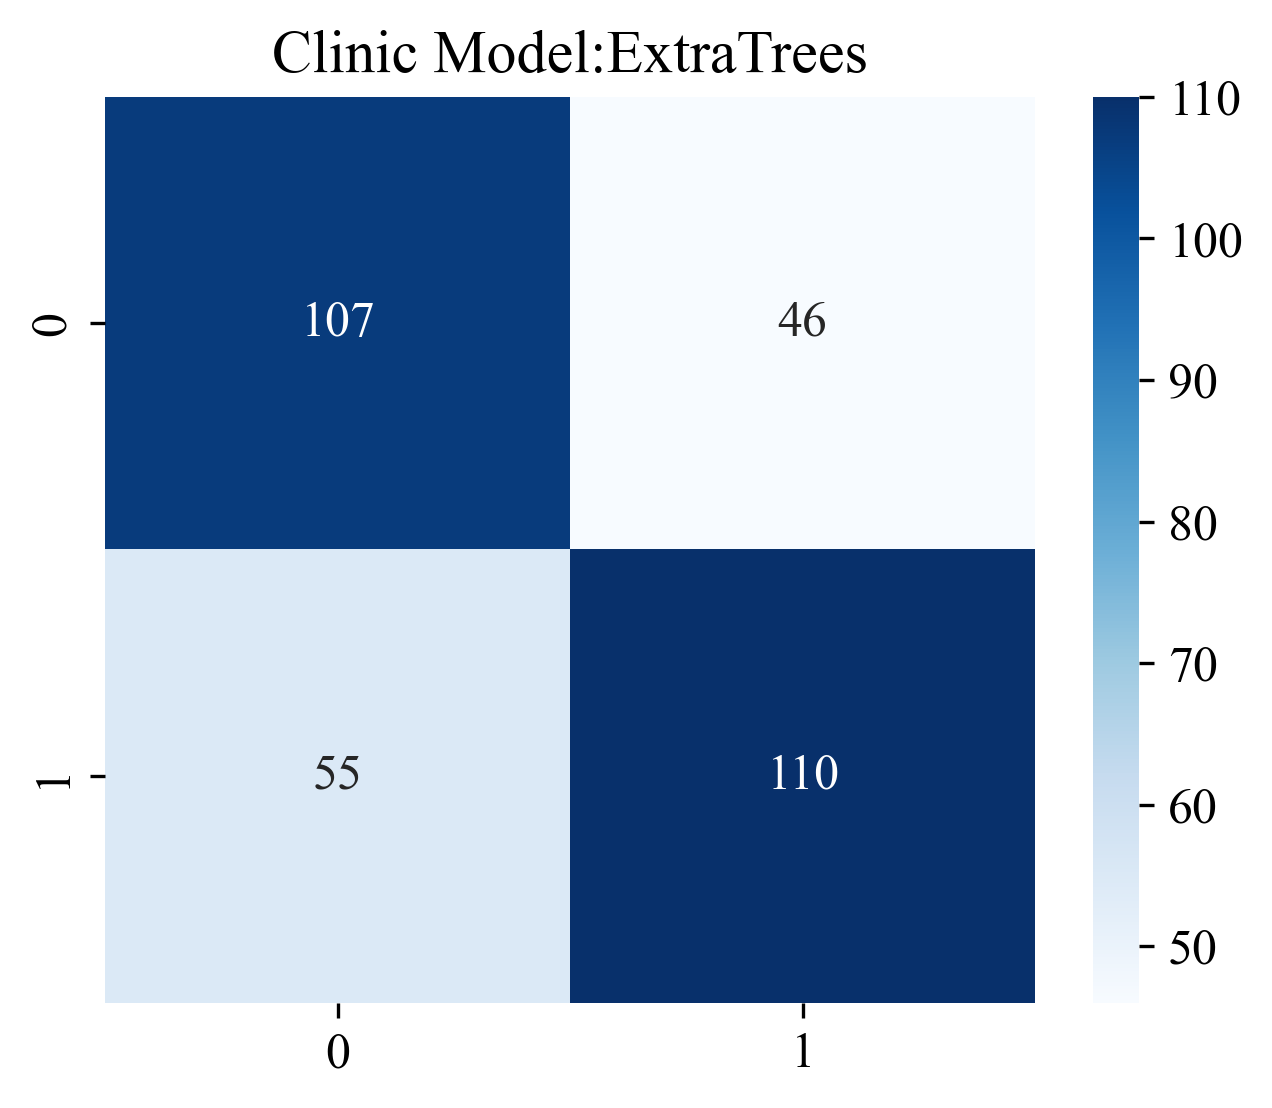

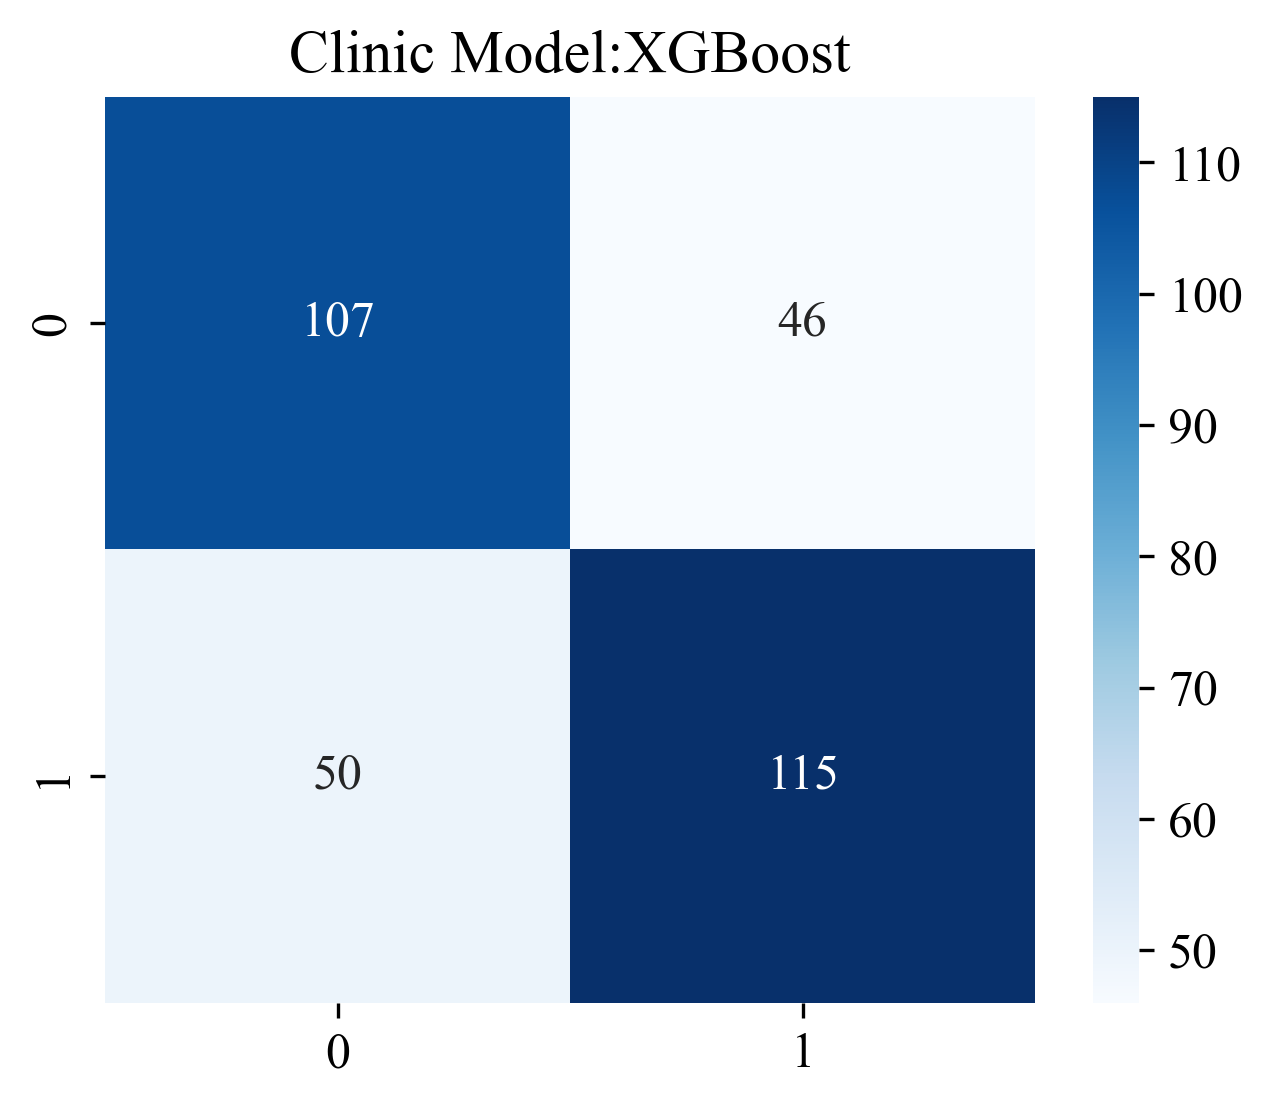

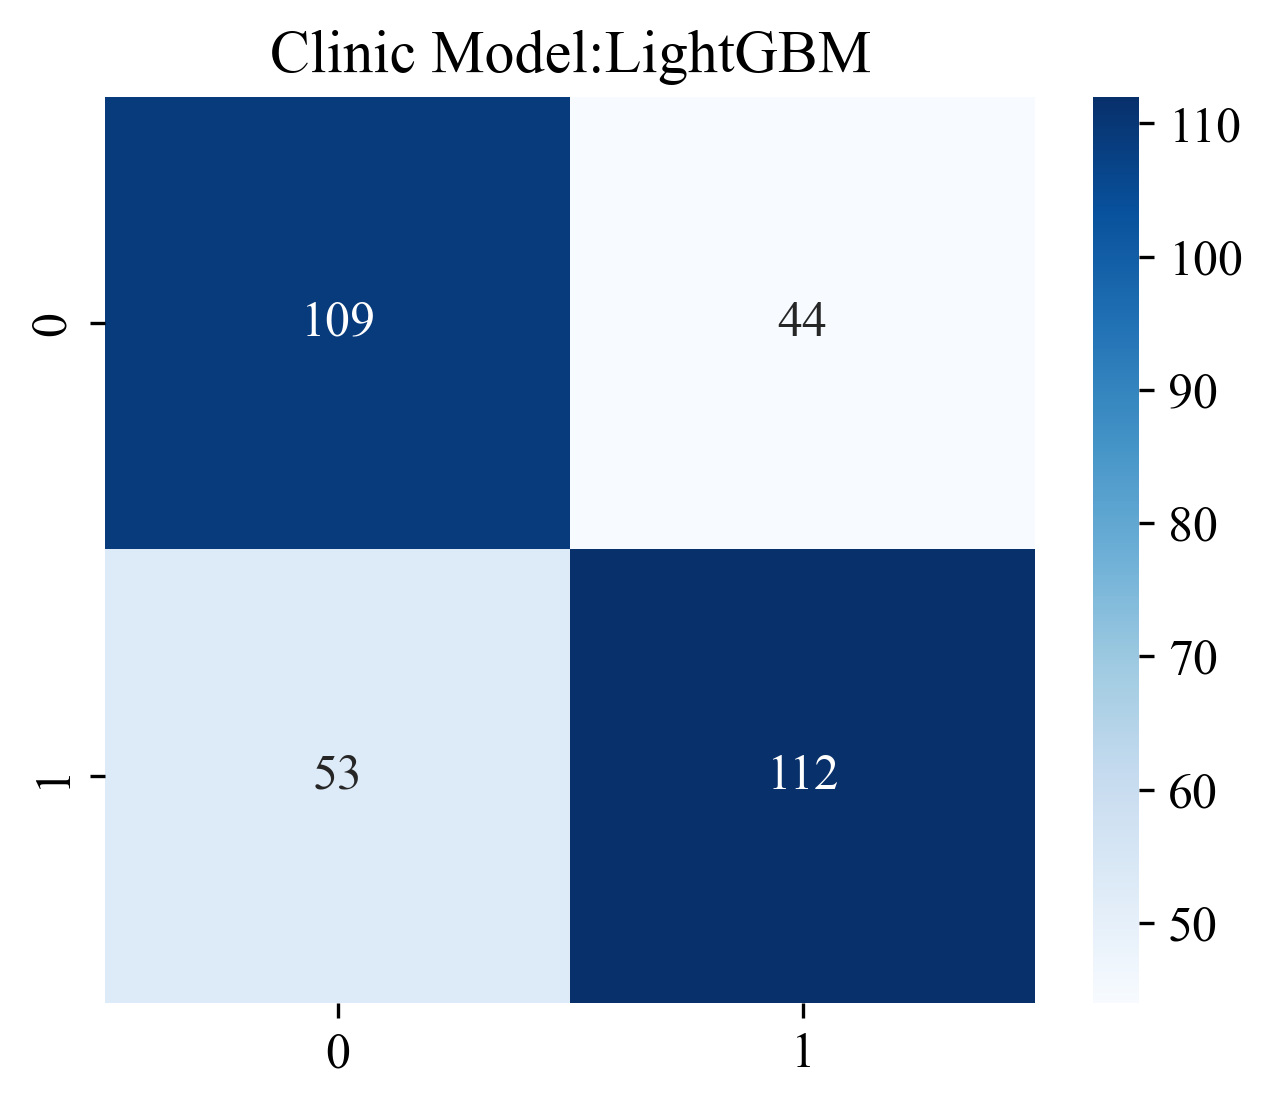

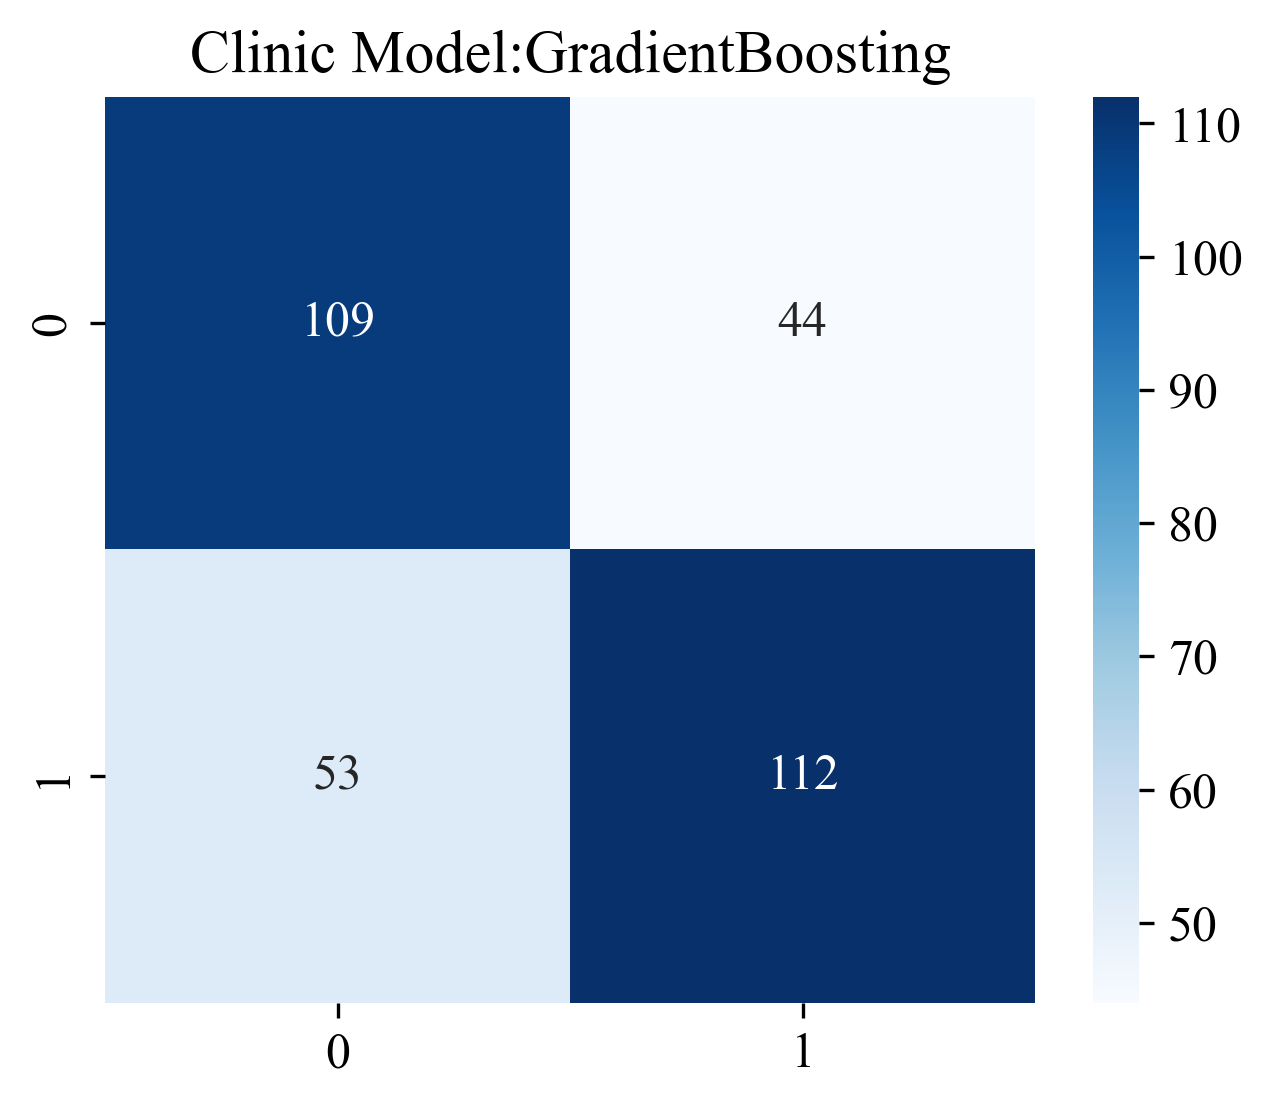

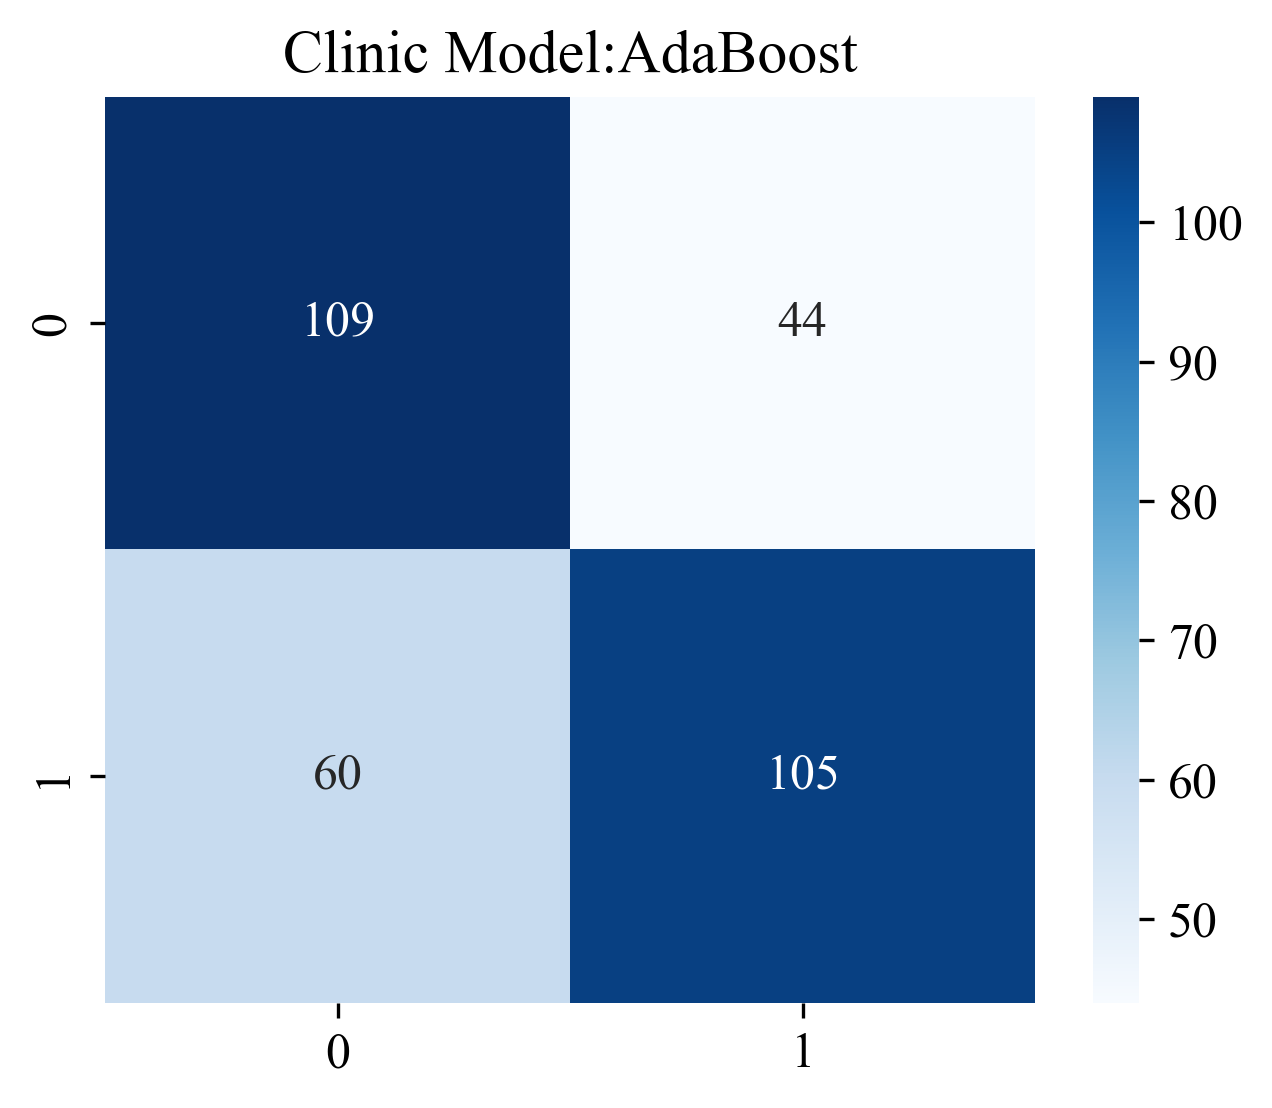

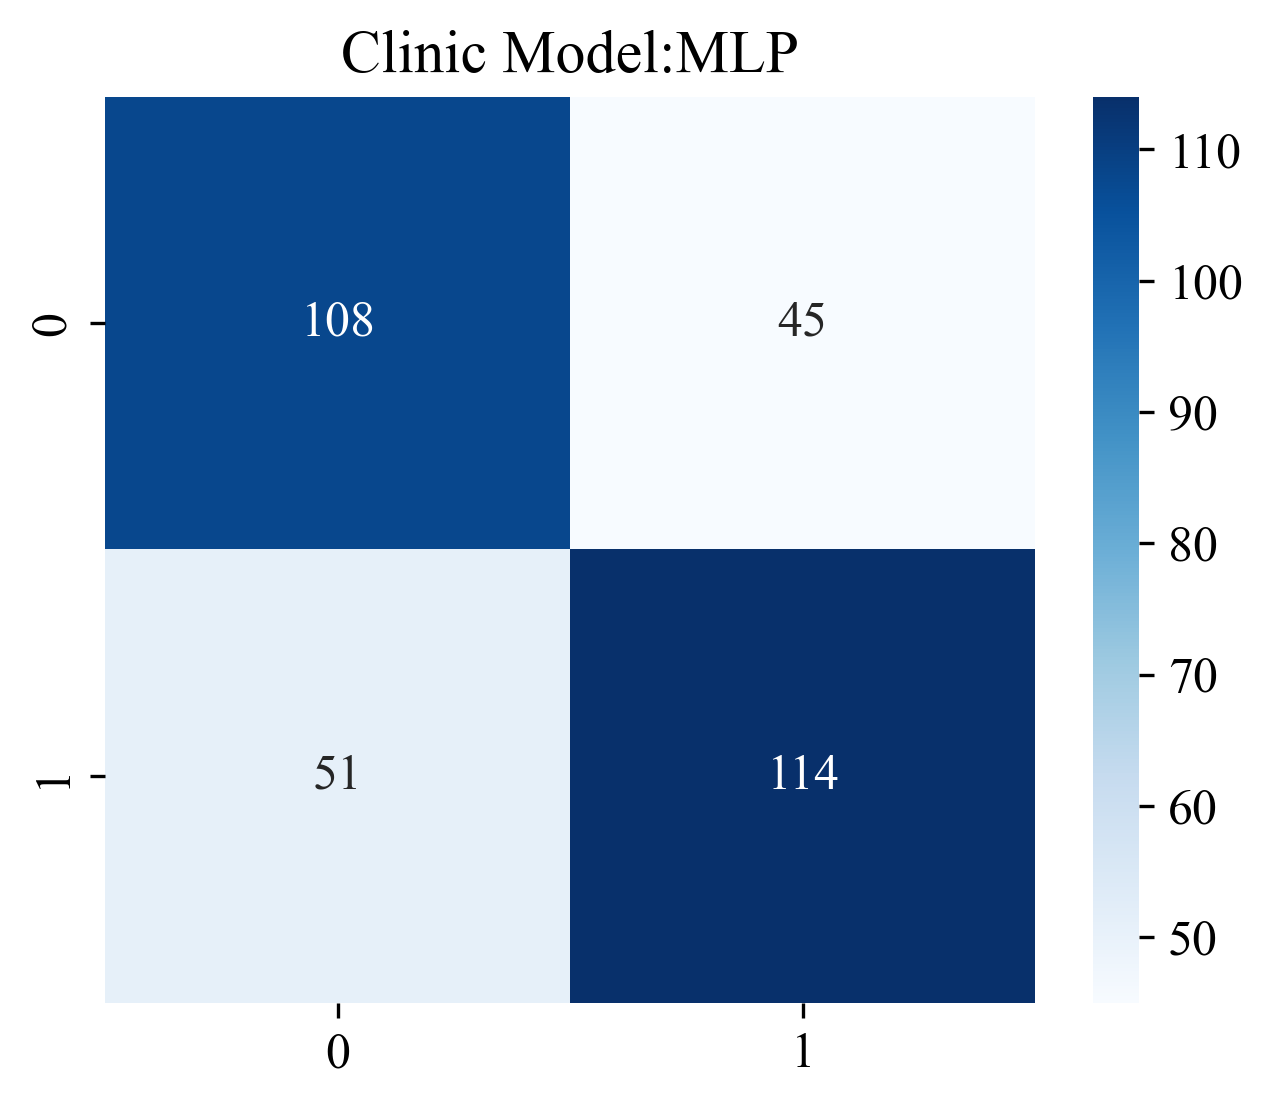

In [245]:
# 设置绘制参数
sel_model = model_names
c_matrix = {}

for sm in sel_model:
    if sm in model_names:
        sel_model_idx = model_names.index(sm)
        for idx, label in enumerate(labels):
            cm = okcomp.comp1.calc_confusion_matrix(predictions[idx][sel_model_idx][-1], y_test_sel[label],
#                                                     sel_idx = pred_sel_idx[idx][sel_model_idx],
                                                    class_mapping={1:'1', 0:'0'}, num_classes=2)
            c_matrix[label] = cm
            plt.figure(figsize=(5, 4))
            plt.title(f'Clinic Model:{sm}')
            okcomp.comp1.draw_matrix(cm, norm=False, annot=True, cmap='Blues', fmt=".3g")
            plt.savefig(f'img/Clinic_model_{sm}_cm.svg', bbox_inches = 'tight')

In [246]:
import os
import numpy as np

sel_model = model_names
os.makedirs('results', exist_ok=True)
for idx, label in enumerate(labels):
    for sm in sel_model:
        if sm in model_names:
            sel_model_idx = model_names.index(sm)
            target = targets[idx][sel_model_idx]
            # 预测训练集和测试集数据。
            train_indexes = np.reshape(np.array(train_ids), (-1, 1)).astype(str)
            test_indexes = np.reshape(np.array(test_ids), (-1, 1)).astype(str)
            y_train_pred_scores = target.predict_proba(X_train_sel)
            y_test_pred_scores = target.predict_proba(X_test_sel)
            columns = ['ID'] + [f"{label}-{i}"for i in range(y_test_pred_scores.shape[1])]
            # 保存预测的训练集和测试集结果
            result_train = pd.DataFrame(np.concatenate([train_indexes, y_train_pred_scores], axis=1), columns=columns)
            result_train.to_csv(f'./results/Clinic_{sm}_train.csv', index=False)
            result_test = pd.DataFrame(np.concatenate([test_indexes, y_test_pred_scores], axis=1), columns=columns)
            result_test.to_csv(f'./results/Clinic_{sm}_test.csv', index=False)